# Интернет-магазин «В один клик»

## Содержание

- [Описание проекта](#intro)
- [Загрузка данных](#data)
- [Промежуточный вывод после загрузки данных](#report_data)
- [Предобработка данных](#prepare)
- [Промежуточный вывод после предобработки данных](#report_prepare)
- [Исследование данных](#research)
- [Промежуточный вывод после исследования данных](#report_research)
- [Объединение таблиц](#merge)
- [Промежуточный вывод после объединения таблиц](#report_merge)
- [Корреляционный анализ](#corr)
- [Промежуточный вывод после корреляционного анализа](#report_corr)
- [Использование пайплайнов](#pipe)
- [Промежуточный  вывод после использования пайплайнов](#report_pipe)
- [Анализ важности признаков](#important)
- [Промежуточный  вывод после анализа важности признаков](#report_important)
- [Сегментация покупателей](#segment)
- [Промежуточный  вывод после сегментации покупателей](#report_segment)
- [Общий вывод](#total_review)

<a id='intro'></a>
## Описание проекта

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

**Целью** работы является:

- построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
- включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
- нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

Для выполнения работы предоставлены данные со следующими признаками:

`market_file.csv` - данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении:

- `id` — номер покупателя в корпоративной базе данных.
- `Покупательская активность` — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
- `Тип сервиса` — уровень сервиса, например «премиум» и «стандарт».
- `Разрешить сообщать` — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- `Маркет_актив_6_мес` — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- `Маркет_актив_тек_мес` — количество маркетинговых коммуникаций в текущем месяце.
- `Длительность` — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- `Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- `Популярная_категория` — самая популярная категория товаров у покупателя за последние 6 месяцев.
- `Средний_просмотр_категорий_за_визит` — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- `Неоплаченные_продукты_штук_квартал` — общее число неоплаченных товаров в корзине за последние 3 месяца.
- `Ошибка_сервиса` — число сбоев, которые коснулись покупателя во время посещения сайта.
- `Страниц_за_визит` — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

`market_money.csv` - данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.:

- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксирована выручка. 
- `Выручка` — сумма выручки за период.

`market_time.csv` - данные о времени (в минутах), которое покупатель провёл на сайте в течение периода.:

- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксировано общее время.
- `минут` — значение времени, проведённого на сайте, в минутах.

`money.csv` - данные о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю:

- `id` — номер покупателя в корпоративной базе данных.
- `Прибыль` — значение прибыли.

<a id='data'></a>
## Загрузка данных

Считаем предоставленные CSV-файлы и изучим общую информацию о каждом датафрейме

#обновляем необходимые библоитеки

!pip install -U phik
!pip install -U scikit-learn
!pip install -U seaborn
!pip install -U shap
#!pip install pandas-profiling
#!pip install -U typing-extensions

!pip install statsmodels

In [1]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [2]:
#импортируем необходимые библоитеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import warnings
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

#import phik
import seaborn as sns
import shap
from phik import phik_matrix
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (roc_auc_score,                            
                             RocCurveDisplay,                              
                             f1_score) 
from sklearn.model_selection import (train_test_split,
                                     RandomizedSearchCV)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (OneHotEncoder, 
                                   StandardScaler, 
                                   MinMaxScaler, 
                                   RobustScaler,
                                   LabelEncoder)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
# from ydata_profiling import ProfileReport

warnings.simplefilter(action='ignore', category=UserWarning)
shap.initjs()


In [3]:
#загрузим все датафреймы
try:
    df = pd.read_csv('/datasets/market_file.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv')

try:
    df_mar_money = pd.read_csv('/datasets/market_money.csv')
except:
    df_mar_money = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv')
    
try:
    df_time = pd.read_csv('/datasets/market_time.csv')
except:
    df_time = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv')
    
try:
    df_money = pd.read_csv('/datasets/money.csv', sep=';', decimal =',')
except:
    df_money = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv', 
                           sep=';', 
                           decimal =',')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [5]:
df_mar_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [6]:
df_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [7]:
df_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


<a id='report_data'></a>
## Предварительный вывод

Мы получили первичные данные по таблицам. К датафрейму `df_money` мы сразу применили `dec` для корректной загрузки чисел с плавающей точкой. В основном датафрейме `df` содержится не так много количество записей, поэтому в дальнейшем стоит сохранить их по-максимуму при работе с дубликатами и аномалиями, если такие будут. Сразу виден общий признак `id` который есть во всех датафреймах и с помощью которого мы будем объединять датафреймы в один. Все признаки содержат одинаковое количество объектов, то есть отсутствуют пустые строки. Использумые типы данных в таблице: целые числа, числа с плавающей точкой и строки. На первый взгляд все признаки соответствуют текущему типу данных. Стоит отметить разное написание признаков, где-то с заглавной буквы, где-то с использованием нижнего подчеркивания. Исправим это на следующем этапе, заодно изучим данные более подробно.

In [8]:
#profile = ProfileReport(df, title="Profiling Report")
#profile

<a id='prepare'></a>
## Предобаботка данных

In [9]:
def show_info(data):
    """
    Функция которая выводит общую информацию по датафрейму
    """
    print('------------- Исходный датафрейм -------------')
    display(data.head())
    print('')
    print('------------- Общая информация о датафрейме -------------')
    print('')
    display(data.info())
    print('------------- Количество пустых значений в датафрейме -------------')
    print('')
    display(data.isna().sum())
    print('------------- Количество явных дубликатов в датафрейме -------------')
    display(data.duplicated().sum())
    print('')
    print('------------- Описательная статистика -------------')
    display(data.describe())
    print('')
    print('------------- Количество уникальных значений -------------')
    display(data.nunique())

Для начала приведем все названия признаков к общему стилю 

In [10]:
f = [df, df_mar_money, df_time, df_money]

In [11]:
for x in f:
    x.columns = [re.sub(r'\s+', '_', i).lower() for i in x.columns]

Теперь рассмотрим более внимательно каждый датафрейм по отдельности

In [12]:
show_info(df)

------------- Исходный датафрейм -------------


id покупательская_активность тип_сервиса разрешить_сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась   стандартт                нет   
3  215351                 Снизилась   стандартт                 да   
4  215352                 Снизилась   стандартт                нет   

   маркет_актив_6_мес  маркет_актив_тек_мес  длительность  акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   

  популярная_категория  средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    6   
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   
3     Товары для детей                                    5   
4     Товары для детей                                    3   

   неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  
0                                   2               1                 5  
1                                   4               2                 5  
2                                   2               1                 5  
3                                   0               6                 4  
4                                   2               3                 2


------------- Общая информация о датафрейме -------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал  

None

------------- Количество пустых значений в датафрейме -------------



id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
dtype: int64

------------- Количество явных дубликатов в датафрейме -------------


0


------------- Описательная статистика -------------


id  маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
count    1300.000000         1300.000000           1300.000000   1300.000000   
mean   215997.500000            4.253769              4.011538    601.898462   
std       375.421985            1.014814              0.696868    249.856289   
min    215348.000000            0.900000              3.000000    110.000000   
25%    215672.750000            3.700000              4.000000    405.500000   
50%    215997.500000            4.200000              4.000000    606.000000   
75%    216322.250000            4.900000              4.000000    806.000000   
max    216647.000000            6.600000              5.000000   1079.000000   

       акционные_покупки  средний_просмотр_категорий_за_визит  \
count        1300.000000                           1300.00000   
mean            0.319808                              3.27000   
std             0.249843                              1.35535   
min             0.000000                              1.00000   
25%             0.170000                              2.00000   
50%             0.240000                              3.00000   
75%             0.300000                              4.00000   
max             0.990000                              6.00000   

       неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  
count                         1300.000000     1300.000000       1300.000000  
mean                             2.840000        4.185385          8.176923  
std                              1.971451        1.955298          3.978126  
min                              0.000000        0.000000          1.000000  
25%                              1.000000        3.000000          5.000000  
50%                              3.000000        4.000000          8.000000  
75%                              4.000000        6.000000         11.000000  
max                             10.000000        9.000000         20.000000


------------- Количество уникальных значений -------------


id                                     1300
покупательская_активность                 2
тип_сервиса                               3
разрешить_сообщать                        2
маркет_актив_6_мес                       41
маркет_актив_тек_мес                      3
длительность                            658
акционные_покупки                        42
популярная_категория                      6
средний_просмотр_категорий_за_визит       6
неоплаченные_продукты_штук_квартал       11
ошибка_сервиса                           10
страниц_за_визит                         20
dtype: int64

В датафрейме отсутствуют явные дубликаты, нет пустых значений, но посмотрим отдельно на признаки с небольшим количеством объектов и строковым типом данных, на случай если там есть одинаковые значения с разным написанием. 

In [13]:
c = ['покупательская_активность', 'тип_сервиса', 'разрешить_сообщать', 'популярная_категория']

In [14]:
for i in c:
    print(df[i].value_counts())

покупательская_активность
Прежний уровень    802
Снизилась          498
Name: count, dtype: int64
тип_сервиса
стандарт     914
премиум      376
стандартт     10
Name: count, dtype: int64
разрешить_сообщать
да     962
нет    338
Name: count, dtype: int64
популярная_категория
Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: count, dtype: int64


Нашли неявный дубликат в признаке `тип_сервиса`, исправим его

In [15]:
df['тип_сервиса'].replace('стандартт', 'стандарт', inplace=True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_17240\1944693496.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['тип_сервиса'].replace('стандартт', 'стандарт', inplace=True)


In [16]:
show_info(df_mar_money)

------------- Исходный датафрейм -------------


id               период  выручка
0  215348  препредыдущий_месяц      0.0
1  215348        текущий_месяц   3293.1
2  215348     предыдущий_месяц      0.0
3  215349  препредыдущий_месяц   4472.0
4  215349        текущий_месяц   4971.6


------------- Общая информация о датафрейме -------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


None

------------- Количество пустых значений в датафрейме -------------



id         0
период     0
выручка    0
dtype: int64

------------- Количество явных дубликатов в датафрейме -------------


0


------------- Описательная статистика -------------


id        выручка
count    3900.000000    3900.000000
mean   215997.500000    5025.696051
std       375.325686    1777.704104
min    215348.000000       0.000000
25%    215672.750000    4590.150000
50%    215997.500000    4957.500000
75%    216322.250000    5363.000000
max    216647.000000  106862.200000


------------- Количество уникальных значений -------------


id         1300
период        3
выручка    2776
dtype: int64

В датафрейме отсутствуют явные дубликаты, нет пустых значений, признак `период` содержит три записи, но их видно при выводе первых строк, поэтому тут неявных дубликатов нет.

In [17]:
show_info(df_time)

------------- Исходный датафрейм -------------


id            период  минут
0  215348     текущий_месяц     14
1  215348  предыдцщий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдцщий_месяц     12
4  215350     текущий_месяц     13


------------- Общая информация о датафрейме -------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


None

------------- Количество пустых значений в датафрейме -------------



id        0
период    0
минут     0
dtype: int64

------------- Количество явных дубликатов в датафрейме -------------


0


------------- Описательная статистика -------------


id        минут
count    2600.000000  2600.000000
mean   215997.500000    13.336154
std       375.349754     4.080198
min    215348.000000     4.000000
25%    215672.750000    10.000000
50%    215997.500000    13.000000
75%    216322.250000    16.000000
max    216647.000000    23.000000


------------- Количество уникальных значений -------------


id        1300
период       2
минут       20
dtype: int64

В датафрейме отсутствуют явные дубликаты, нет пустых значений, признак `период` содержит две записи, их видно при выводе первых строк и видно что одно из значений написано с опечаткой, исправим это. 

In [18]:
df_time['период'].replace('предыдцщий_месяц', 'предыдущий_месяц', inplace=True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_17240\3641326387.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_time['период'].replace('предыдцщий_месяц', 'предыдущий_месяц', inplace=True)


In [19]:
show_info(df_money)

------------- Исходный датафрейм -------------


id  прибыль
0  215348     0.98
1  215349     4.16
2  215350     3.13
3  215351     4.87
4  215352     4.21


------------- Общая информация о датафрейме -------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


None

------------- Количество пустых значений в датафрейме -------------



id         0
прибыль    0
dtype: int64

------------- Количество явных дубликатов в датафрейме -------------


0


------------- Описательная статистика -------------


id      прибыль
count    1300.000000  1300.000000
mean   215997.500000     3.996631
std       375.421985     1.013722
min    215348.000000     0.860000
25%    215672.750000     3.300000
50%    215997.500000     4.045000
75%    216322.250000     4.670000
max    216647.000000     7.430000


------------- Количество уникальных значений -------------


id         1300
прибыль     400
dtype: int64

В датафрейме отсутствуют явные дубликаты, нет пустых значений, на неявные дубликаты тут нечего проверять.

Посмотрим что получилось, после предобработки данных, вызвав по очереди все датафреймы.

In [20]:
df.head()

id покупательская_активность тип_сервиса разрешить_сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась    стандарт                нет   
3  215351                 Снизилась    стандарт                 да   
4  215352                 Снизилась    стандарт                нет   

   маркет_актив_6_мес  маркет_актив_тек_мес  длительность  акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   

  популярная_категория  средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    6   
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   
3     Товары для детей                                    5   
4     Товары для детей                                    3   

   неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  
0                                   2               1                 5  
1                                   4               2                 5  
2                                   2               1                 5  
3                                   0               6                 4  
4                                   2               3                 2

In [21]:
df_mar_money.head()

id               период  выручка
0  215348  препредыдущий_месяц      0.0
1  215348        текущий_месяц   3293.1
2  215348     предыдущий_месяц      0.0
3  215349  препредыдущий_месяц   4472.0
4  215349        текущий_месяц   4971.6

In [22]:
df_money.head()

id  прибыль
0  215348     0.98
1  215349     4.16
2  215350     3.13
3  215351     4.87
4  215352     4.21

In [23]:
df_time.head()

id            период  минут
0  215348     текущий_месяц     14
1  215348  предыдущий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдущий_месяц     12
4  215350     текущий_месяц     13

In [24]:
print(f'Количество объектов в датафрейме df: {df.shape[0]}, \
количество признаков {df.shape[1]}')
print(f'Количество объектов в датафрейме df_buy: {df_mar_money.shape[0]}, \
количество признаков {df_mar_money.shape[1]}')
print(f'Количество объектов в датафрейме df_dad: {df_money.shape[0]}, \
количество признаков {df_money.shape[1]}')
print(f'Количество объектов в датафрейме df_dad: {df_time.shape[0]}, \
количество признаков {df_time.shape[1]}')

Количество объектов в датафрейме df: 1300, количество признаков 13
Количество объектов в датафрейме df_buy: 3900, количество признаков 3
Количество объектов в датафрейме df_dad: 1300, количество признаков 2
Количество объектов в датафрейме df_dad: 2600, количество признаков 3


<a id='report_prepare'></a>
## Предварительный вывод

На этапе предобработки данных мы внимательно изучили каждый датафрейм по отдельности. Везде отсутствовали явные дубликаты, пустые строки, а тип данных соответствовал значениям. В `df` и `df_time` были выявлены неявные дубликаты которые мы исправили. 
После предобработки данных, основной датафрейм `df` содержит 1300 объектов и 13 признаков. Кроме того, на данном этапе мы привели к единому названию все признаки во всех датафреймах. На следующем этапе мы проведем исследовательский анализ на поиск различных аномалий. 

<Axes: >

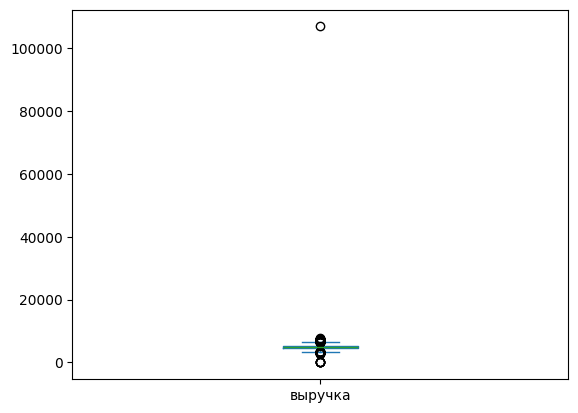

In [25]:
df_mar_money['выручка'].plot(kind='box')

In [26]:
df_mar_money[df_mar_money['выручка'] > 100000]

id         период   выручка
98  215380  текущий_месяц  106862.2

In [27]:
df_mar_money[df_mar_money['id'] == 215380]

id               период   выручка
96  215380  препредыдущий_месяц    5051.0
97  215380     предыдущий_месяц    6077.0
98  215380        текущий_месяц  106862.2

In [28]:
df_mar_money.at[98, 'выручка'] = df_mar_money.at[98, 'выручка'] / 10

<a id='research'></a>
## Исследовательский анализ

In [29]:
def show_hist_box(col):
    """
    Функция которая принимает на вход признак (col) 
    и строит по нему histplot и boxplot
    """
    fig, axes = plt.subplots(nrows=2, 
                             ncols=1, 
                             figsize=(8,4), 
                             gridspec_kw = {'height_ratios': (.30, .70)})
    sns.histplot(data = df[col], bins = 15, ax = axes[1])
    sns.boxplot(x = df[col], ax = axes[0])
    axes[1].set_title('Распределение признака ' + col, fontsize = 15)
    axes[0].set_title('Диаграмма размаха признака ' + col, fontsize = 15)
    axes[1].axvline(df[col].mean(), c="r", label='Среднее')
    axes[1].axvline(df[col].median(), c="r", ls="--", label='Медиана')
    axes[1].set_ylabel('Частота')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [30]:
def show_piegraph(col):
    """
    Функиця принимает на вход признак и строит пай-чарт
    с количеством значений входящих в этот признак
    """
    df[col].value_counts().plot(kind='pie', 
                                y=df[col], 
                                autopct='%1.2f%%', 
                                shadow=True, 
                                figsize=(8,5))
    plt.title('Распределение значений среди признака - ' + col)
    plt.ylabel('')
    plt.rcParams['font.size'] = '12'

In [31]:
def show_countplot(x, leg):
    """
    Функиця принимает на вход два признака, 
    первый используется в качестве оси Х, 
    второй в качестве цветого распределения 
    и строит countplot
    """
    plt.figure(figsize=(10,7))
    plt.title('Распределение значений по типу сервиса для признака ' + i)
    ax = sns.countplot(data=df_group_comm,x=x, hue=leg)
    for container in ax.containers:
        ax.bar_label(container, fontsize=15)
    plt.show();

In [32]:
def plot_hist(df, by, col):    
    """
    Функиця принимает на вход датафрейм и два
    признака, по одному производим группировку, 
    второй используем для суммы и строим 
    график используя полученную группировку
    """
    t = (df
          .groupby(by)
          .agg({col: sum})
          .sort_values(by=col))
    ax = sns.barplot(t, x=by, y=col)
    plt.rcParams["figure.figsize"] = (10, 5)
    plt.plot(t, color='red')
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f')
    ax.yaxis.get_major_formatter().set_scientific(False)
    return t

In [33]:
#получим отдельно количественные и категориальные столбцы
num_subset = df.select_dtypes('number').columns
cat_subset = df.select_dtypes('object').columns
print(f'Датафрейм имеет следующие количественные признаки - \n{pd.Series(num_subset)} \
\n и следующие категориальные признаки - \n{pd.Series(cat_subset)}')

Датафрейм имеет следующие количественные признаки - 
0                                     id
1                     маркет_актив_6_мес
2                   маркет_актив_тек_мес
3                           длительность
4                      акционные_покупки
5    средний_просмотр_категорий_за_визит
6     неоплаченные_продукты_штук_квартал
7                         ошибка_сервиса
8                       страниц_за_визит
dtype: object 
 и следующие категориальные признаки - 
0    покупательская_активность
1                  тип_сервиса
2           разрешить_сообщать
3         популярная_категория
dtype: object


Для начала посмотрим на простые графики для категориальных и количественных признаков.

Построим график типа 'pie' для всех категориальных признаков.

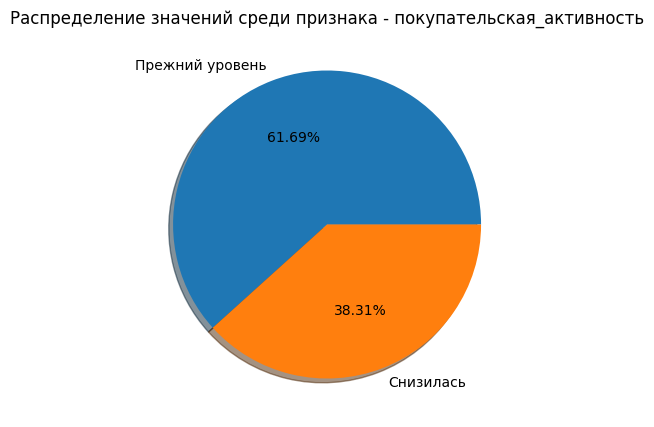

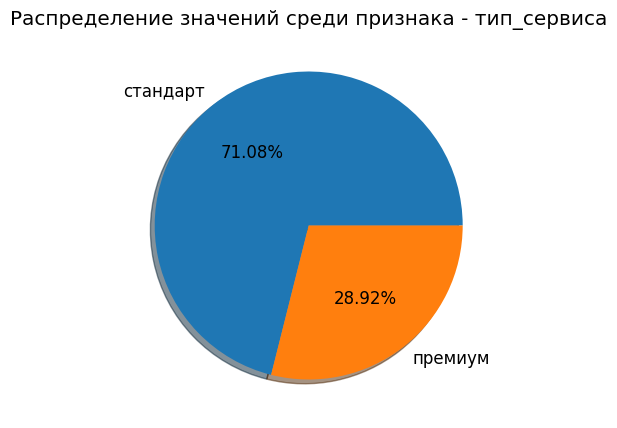

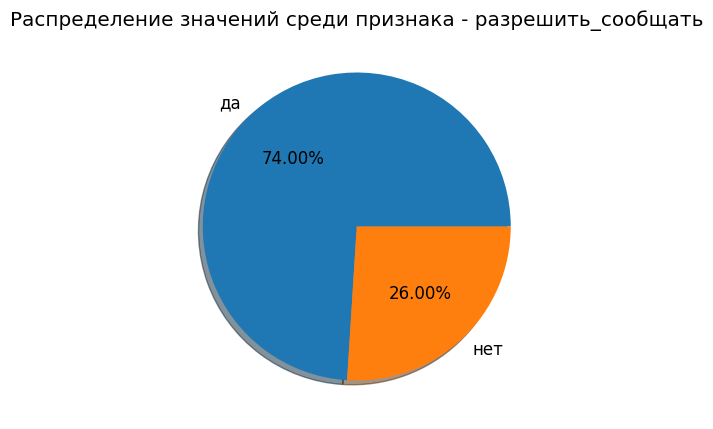

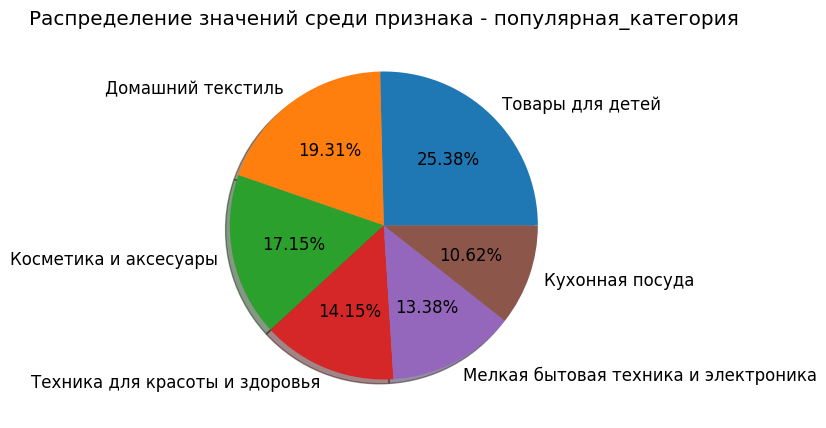

In [34]:
for i in cat_subset:
    show_piegraph(i)
    plt.show()

Покупательская активность остается на прежнем уровне в 61% случаях, при этом подавляющее количество пользователей (более 70%)  не используют подписку 'Премиум'. Наибольшим спросом пользуется категория 'Товары для детей'. Посмотрим на количественнные значения этого признака.

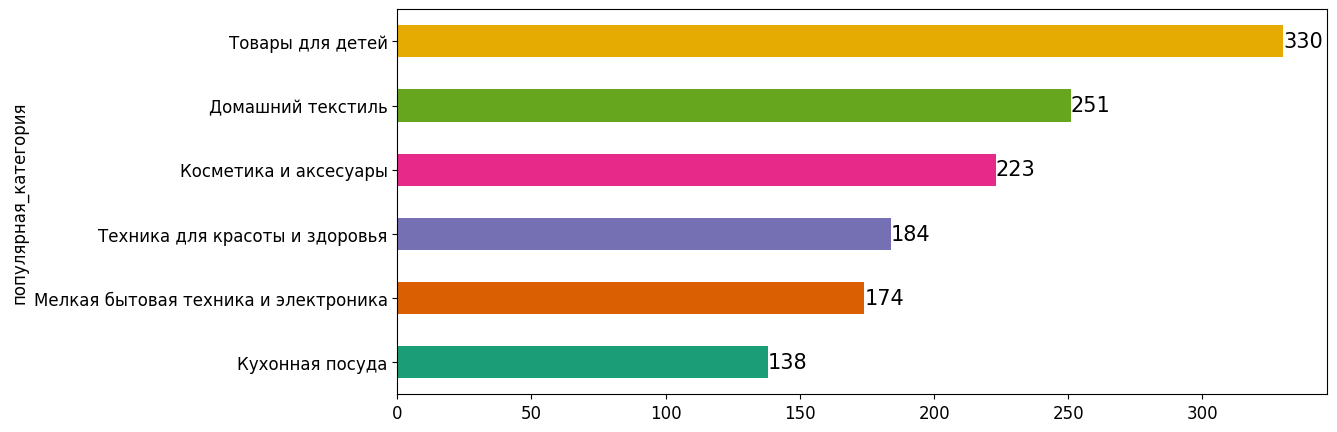

In [35]:
t = df.groupby('популярная_категория').size()
ax = t.sort_values().plot(kind='barh', 
                          color=sns.mpl_palette('Dark2'), 
                          figsize=(12, 5))
ax.bar_label(ax.containers[0], fontsize=15);

Построим графики для всех количественных признаков.

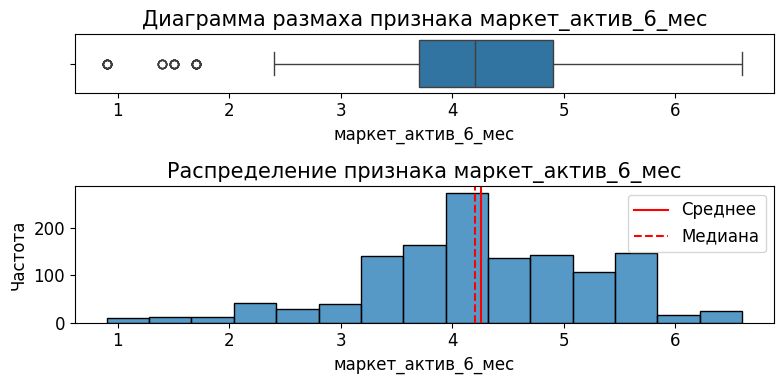

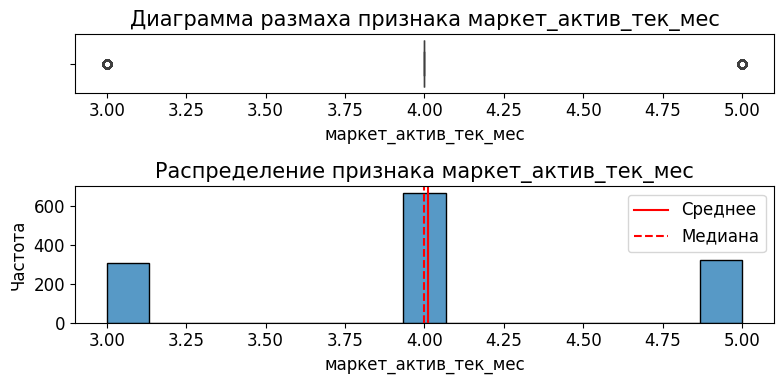

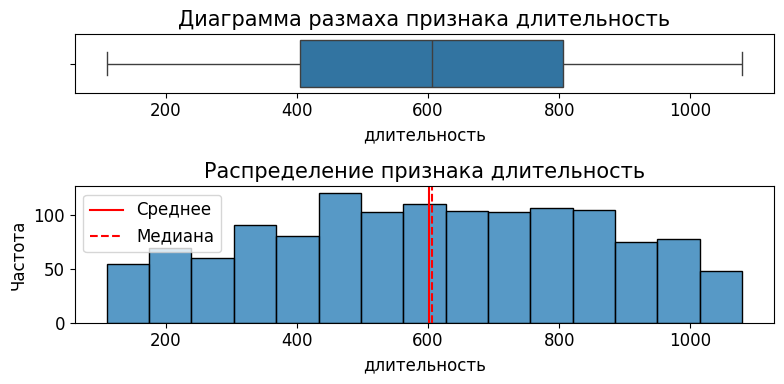

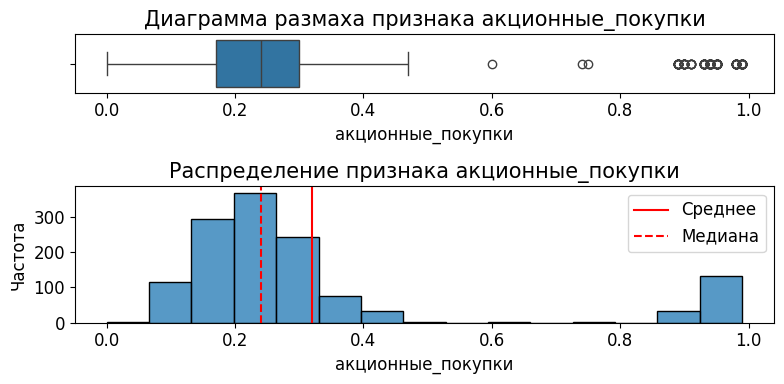

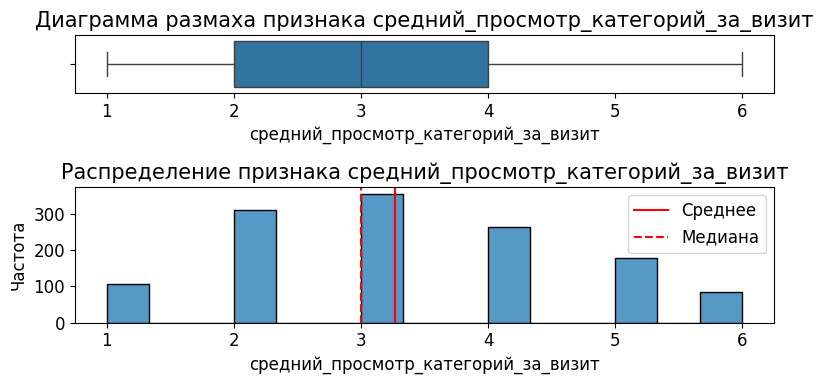

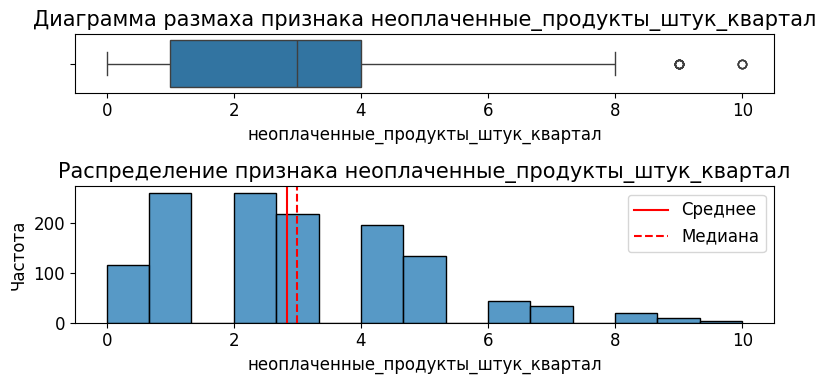

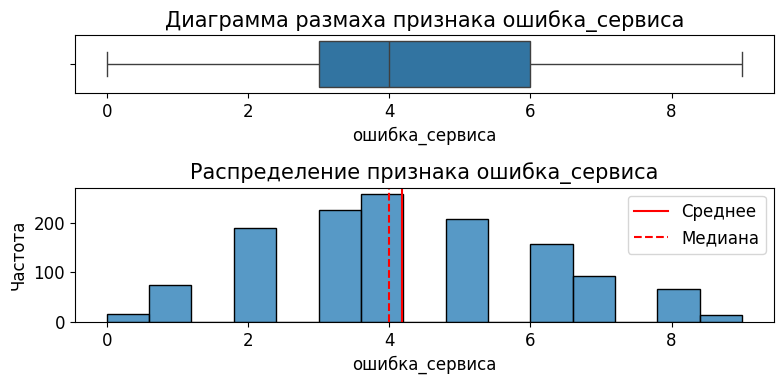

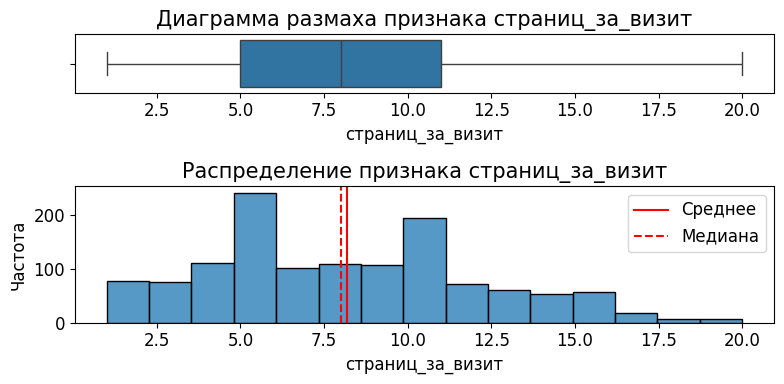

In [36]:
for i in num_subset[1:]:
    show_hist_box(i)

Среднемесячное значение маркетинговых коммуникаций с покупателем за последние полгода, сконцентрировано в районе 4 раз с выраженным пиком у этого значения. Что подтверждает и количество маркетинговых коммуникаций в текущем месяце, где также пик сконцентрирован в районе 4 раз. Также в признаке маркетинговой активности за последние полгода есть небольшие выбросы в районе 1-2 раз, возможно это связано с негативной реакцией клиента на подобную рекламу и после чего она прекратилась. Признак длительность имеет равномерное распределение со средним около 600 дней с момента регистрации на сайте. Это говорит о том, что пользователи довольно давно пользуются сайтом и остаются лояльны со вренем. Признак акционные покупки имеет два пика, основной расположен у 0.25, который говорит что только четверть товаров приобретается клиентом по акции, но также есть и близкие к 1, то есть есть часть клиентов которые покупают только по акции. Посмотрим отдельно сколько пользователей относится к этим категориям. В признаке неоплаченные товары, есть нормальное скопление вокруг до 5 товаров, однако есть и более 8 неоплаченных товаров. На них также посмотрим отдельно. Признак страниц за визит имеет два ярковыраженных пика в районе 5 и 10. 

In [37]:
print(f'Количество пользователей которые почти все товары покупают по акции - \
{df[df["акционные_покупки"] > 0.9]["id"].count()}')
print(f'Количество пользователей которые мало товаров покупают по акции - \
{df[df["акционные_покупки"] < 0.25]["id"].count()}')

Количество пользователей которые почти все товары покупают по акции - 138
Количество пользователей которые мало товаров покупают по акции - 683


In [38]:
unbuy = df.query('неоплаченные_продукты_штук_квартал > 8')
unbuy.head()

id покупательская_активность тип_сервиса разрешить_сообщать  \
72   215420                 Снизилась    стандарт                 да   
73   215421                 Снизилась     премиум                нет   
117  215465                 Снизилась    стандарт                 да   
118  215466                 Снизилась     премиум                нет   
176  215524                 Снизилась    стандарт                 да   

     маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
72                  3.5                     5           449   
73                  4.0                     5           523   
117                 3.5                     5           449   
118                 2.4                     5           523   
176                 3.0                     3           474   

     акционные_покупки            популярная_категория  \
72                0.35               Домашний текстиль   
73                0.94  Техника для красоты и здоровья   
117               0.28               Домашний текстиль   
118               0.30  Техника для красоты и здоровья   
176               0.23  Техника для красоты и здоровья   

     средний_просмотр_категорий_за_визит  неоплаченные_продукты_штук_квартал  \
72                                     1                                   9   
73                                     1                                  10   
117                                    1                                   9   
118                                    1                                  10   
176                                    1                                  10   

     ошибка_сервиса  страниц_за_визит  
72                2                 2  
73                7                 5  
117               2                 2  
118               1                 4  
176               4                 2

In [39]:
unbuy['id'].count()

14

Таких покупателей всего 14, у которых больше всего неоплаченных товаров в квартале. Между ними нет никакой закономерности, тут есть как пользователи с подпиской, так и без. Все пользователи зарегистрированы не меньше года, то есть давно. Возможно отказ от покупки связано с ошибкой сервиса возникшей в тот момент и покупатель просто не стал ждать пока починят.

Далее проведем анализ не по одному признаку, а рассмотрим данные по разным группам.

Сформируем первую группу по коммуникации сотрудников компании с клиентами.

In [40]:
df_group_comm = (df
                 .groupby(['покупательская_активность',
                            'тип_сервиса', 
                            'разрешить_сообщать', 
                            'маркет_актив_6_мес', 
                            'маркет_актив_тек_мес', 
                            'длительность'])
                 .agg(Количество=('id', 'count'))
                 .reset_index())
df_group_comm.head()

покупательская_активность тип_сервиса разрешить_сообщать  \
0           Прежний уровень     премиум                 да   
1           Прежний уровень     премиум                 да   
2           Прежний уровень     премиум                 да   
3           Прежний уровень     премиум                 да   
4           Прежний уровень     премиум                 да   

   маркет_актив_6_мес  маркет_актив_тек_мес  длительность  Количество  
0                 2.4                     4           768           1  
1                 2.4                     4           996           1  
2                 2.6                     4           346           1  
3                 2.6                     4           620           1  
4                 3.2                     3           763           1

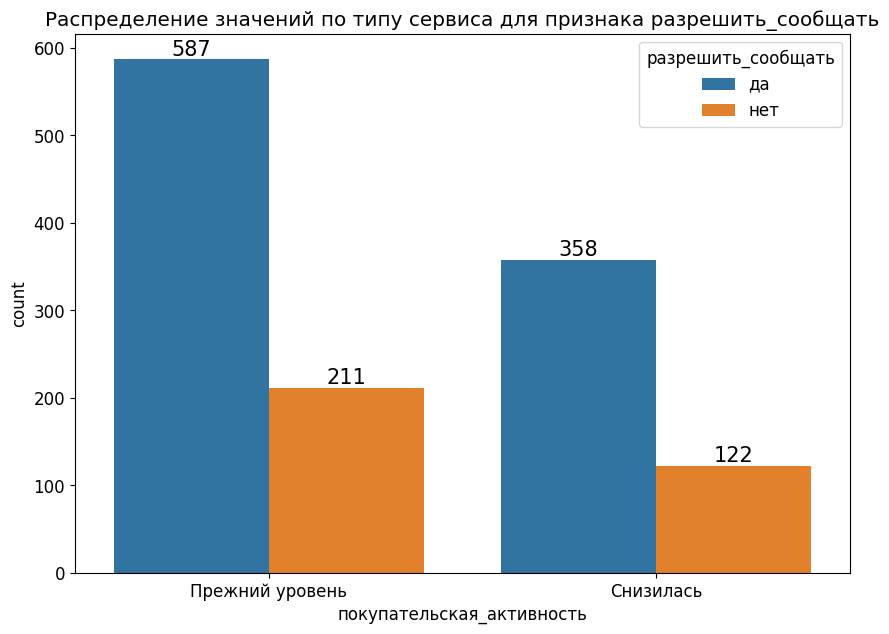

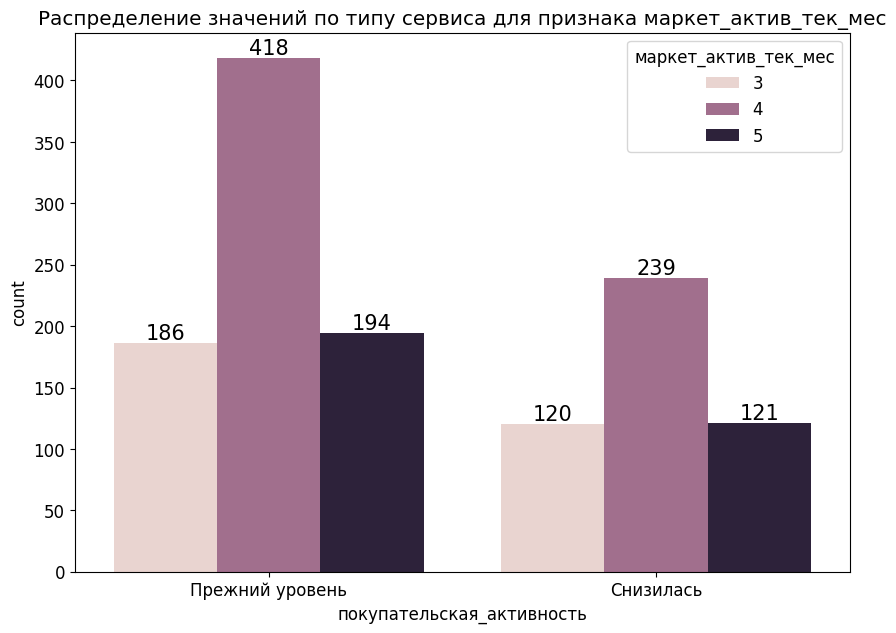

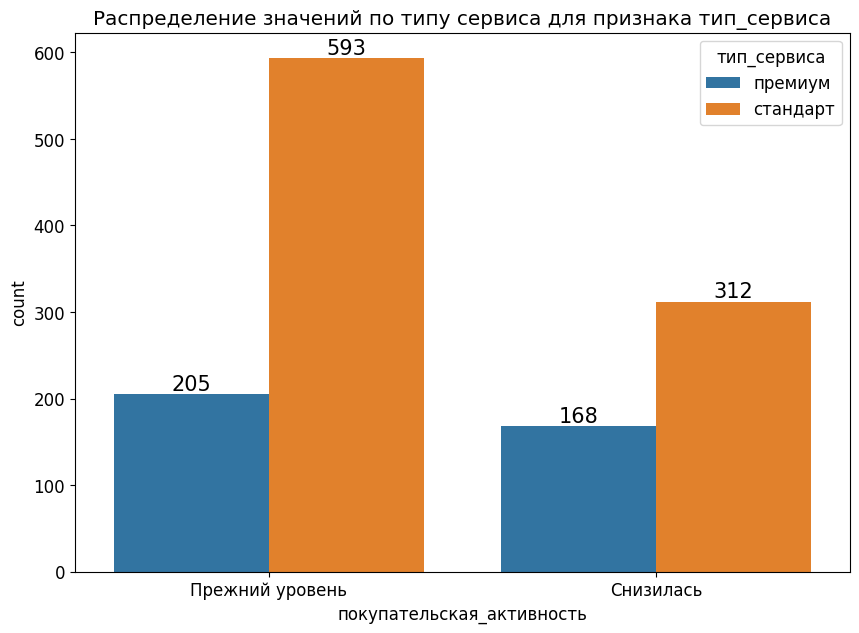

In [41]:
for i in df_group_comm[['разрешить_сообщать', 'маркет_актив_тек_мес', 'тип_сервиса']]:
    show_countplot('покупательская_активность', i)

Большинство пользователей разрешает отправлять сообщения, скорее всего с целью чтобы не пропустить какую-либо хорошую акцию. Чаще всего отправляют 4 маркетинговых акции в месяц, то есть раз в неделю. Стоит отметить что отсутствие подписки не влияет на покупательскую активность.

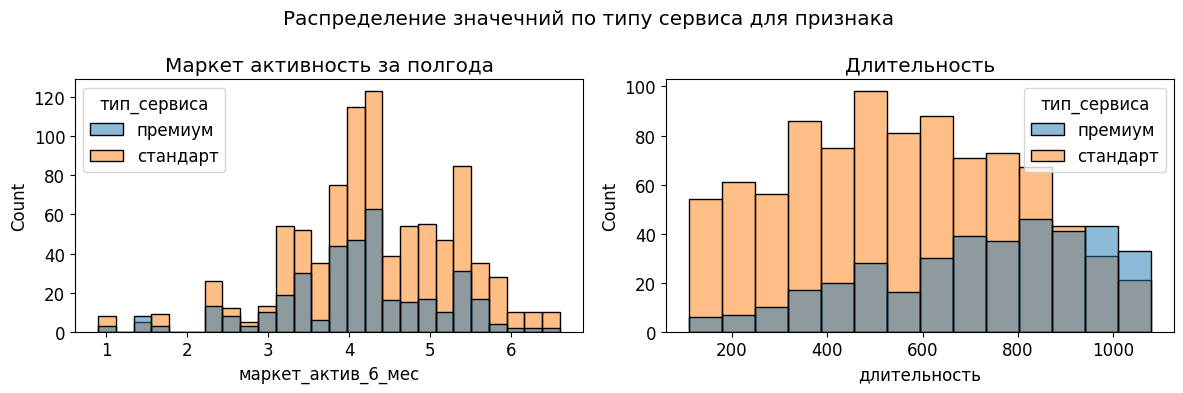

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
sns.histplot(data=df_group_comm, 
             x='маркет_актив_6_мес', 
             hue='тип_сервиса', 
             legend='auto', 
             ax=ax[0])
sns.histplot(data=df_group_comm, 
             x='длительность',
             hue='тип_сервиса', 
             legend='auto', 
             ax=ax[1])
fig.suptitle('Распределение значечний по типу сервиса для признака ')
ax[0].set_title('Маркет активность за полгода')
ax[1].set_title('Длительность')
plt.tight_layout()
plt.show()

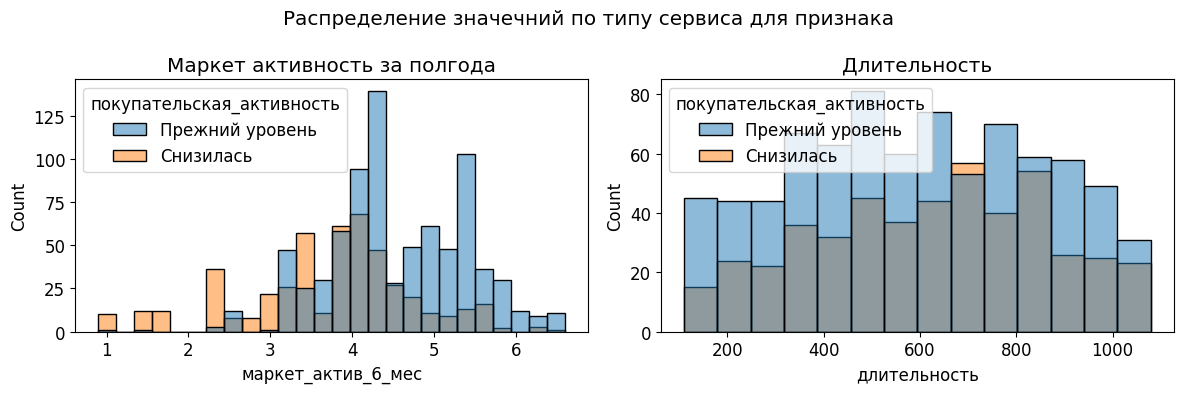

In [43]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
sns.histplot(data=df_group_comm, 
             x='маркет_актив_6_мес', 
             hue='покупательская_активность', 
             legend='auto', 
             ax=ax[0])
sns.histplot(data=df_group_comm, 
             x='длительность',
             hue='покупательская_активность', 
             legend='auto', 
             ax=ax[1])
fig.suptitle('Распределение значечний по типу сервиса для признака ')
ax[0].set_title('Маркет активность за полгода')
ax[1].set_title('Длительность')
plt.tight_layout()
plt.show()

Можно сказать, что для пользователей без премиум подписки идет больше маркетинговая коммуникация за последние полгода, возможно нацеленная как раз чтобы рассказать о выгоде Премиум подписки. Также стоит отметить что по мере увеличения времени с момента регистрации на сайте, растет число пользователей с подпиской "Премиум". 

Следующей группой будет группа связанная с продуктовым поведением

In [44]:
df_group_poved = (df
                  .groupby(['неоплаченные_продукты_штук_квартал', 
                             'средний_просмотр_категорий_за_визит', 
                             'популярная_категория'])
                  .agg(Количество=('id','count'))
                  .reset_index())
df_group_poved.head()

неоплаченные_продукты_штук_квартал  средний_просмотр_категорий_за_визит  \
0                                   0                                    1   
1                                   0                                    1   
2                                   0                                    2   
3                                   0                                    2   
4                                   0                                    2   

                   популярная_категория  Количество  
0                 Косметика и аксесуары           1  
1  Мелкая бытовая техника и электроника           1  
2                     Домашний текстиль           4  
3                 Косметика и аксесуары           3  
4                       Кухонная посуда           5

C:\Users\Admin\AppData\Local\Temp\ipykernel_17240\1931907328.py:3: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg(sum)


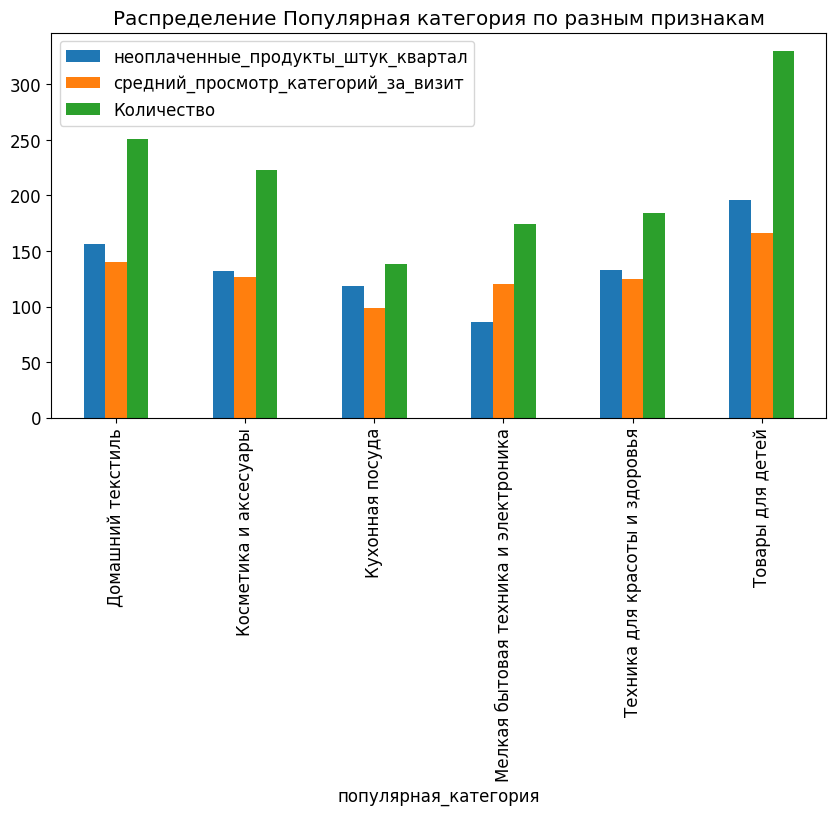

In [45]:
(df_group_poved
 .groupby('популярная_категория')
 .agg(sum)
 .plot(kind='bar', figsize=(10,5)))
plt.title('Распределение Популярная категория по разным признакам')
plt.show()

Здесь категория "Товары для детей" остается в лидерах по всем параметрам, как самые часто неоплаченные, так и наиболее популярная.

Далее рассмотрим группу связанную с поведением на сайте. Для этого нужно будет в первую очередь сделать значения признака `Период` отдельными признаками. 

In [46]:
df_group_site = pd.pivot_table(df_time, 
                               index='id', 
                               columns='период', 
                               values='минут')
df_group_site.head()

период  предыдущий_месяц  текущий_месяц
id                                     
215348              13.0           14.0
215349              12.0           10.0
215350               8.0           13.0
215351              11.0           13.0
215352               8.0           11.0

In [47]:
df_group_site = df_group_site.merge(df[['id','ошибка_сервиса', 'страниц_за_визит']], 
                                    how='left', 
                                    on='id')
df_group_site.head()

id  предыдущий_месяц  текущий_месяц  ошибка_сервиса  страниц_за_визит
0  215348              13.0           14.0               1                 5
1  215349              12.0           10.0               2                 5
2  215350               8.0           13.0               1                 5
3  215351              11.0           13.0               6                 4
4  215352               8.0           11.0               3                 2

C:\Users\Admin\AppData\Local\Temp\ipykernel_17240\2932413838.py:3: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg(sum)


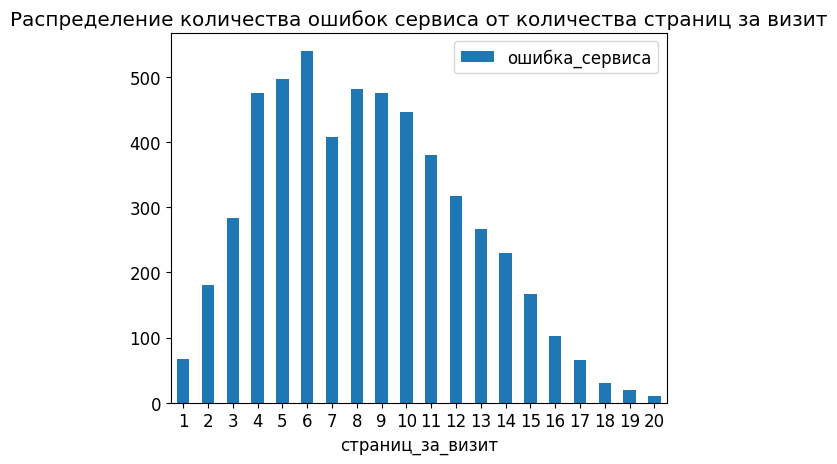

In [48]:
(df_group_site
 .groupby('страниц_за_визит')
 .agg(sum)
 .plot(kind='bar', y='ошибка_сервиса', rot=0))
plt.title('Распределение количества ошибок сервиса от количества страниц за визит')
plt.show()

По графику видно что нет тенденции что с увеличением страниц за визит увеличивается число ошибок сервиса. Возможно ошибки возникают при определенных категориях, а в других их нет вовсе. Посмотрим этот момент. 

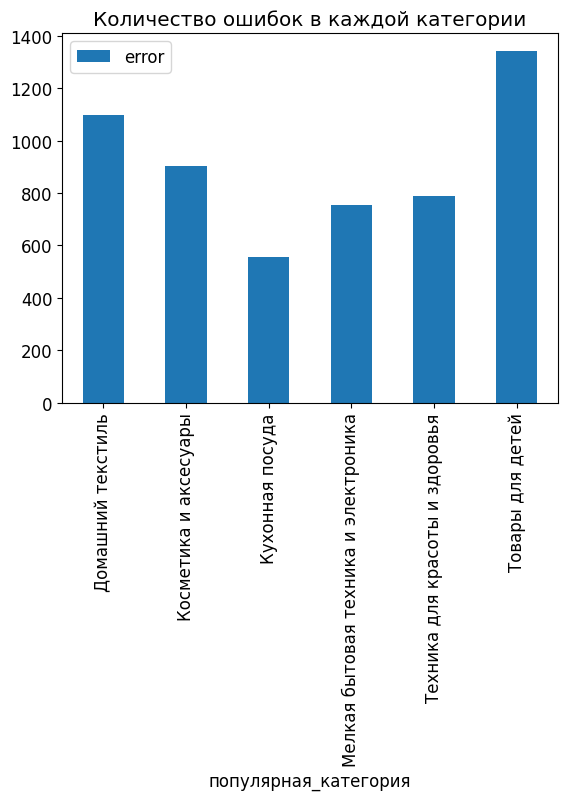

In [49]:
(df
 .groupby('популярная_категория')
 .agg(error=('ошибка_сервиса','sum'))
 .plot(kind='bar'))
plt.title('Количество ошибок в каждой категории')
plt.show()

Наименьшее число ошибок в категории "Кухонная посуда", возможно именно эти страницы посещались пользователями. 

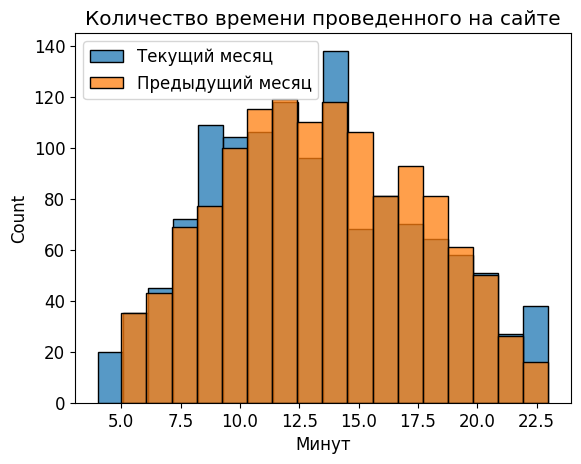

In [50]:
sns.histplot(data=df_group_site, x='текущий_месяц')
sns.histplot(data=df_group_site, x='предыдущий_месяц')
plt.legend(['Текущий месяц', 'Предыдущий месяц'])
plt.rcParams["figure.figsize"] = (10,4)
plt.title('Количество времени проведенного на сайте')
plt.xlabel('Минут')
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_17240\1893990366.py:10: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg({col: sum})


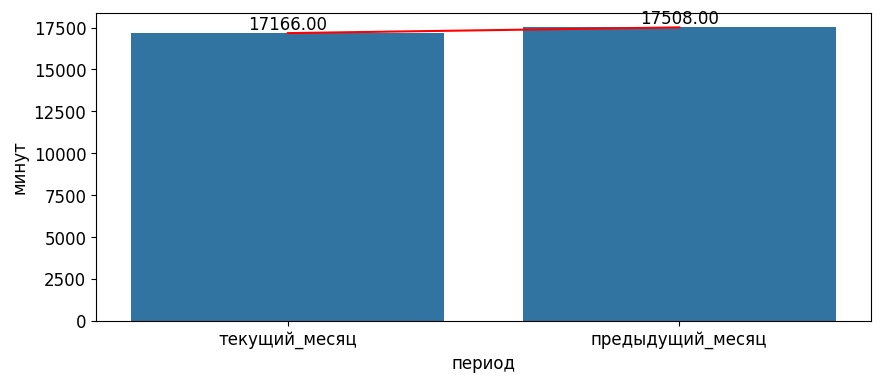

In [51]:
tt = plot_hist(df_time, 'период', 'минут')

Время проведенное на сайте в текущем и предыдущем месяце распределено примерно одинаково. Но в предыдущем месяце пользователи больше времени проводили на сайте.

Рассмотрим еще одну группу связанную с финансовым поведением.

C:\Users\Admin\AppData\Local\Temp\ipykernel_17240\1893990366.py:10: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg({col: sum})


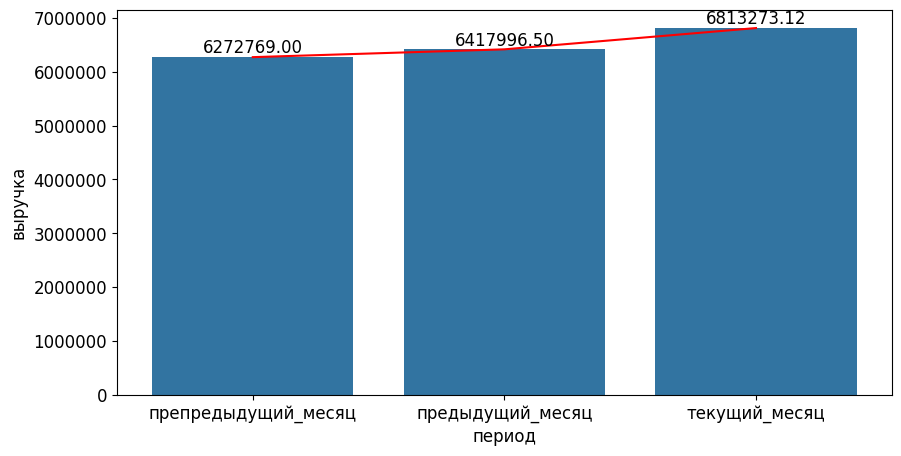

In [52]:
mm = plot_hist(df_mar_money, 'период', 'выручка')

In [53]:
pd.DataFrame({'Выручка в текущем месяце': [mm['выручка'][2]], 
              'Разница между текущим и предыдущим': [mm['выручка'].diff()[2]], 
              'Разница между предыдущим и препредыдущим': [mm['выручка'].diff()[1]]})

C:\Users\Admin\AppData\Local\Temp\ipykernel_17240\3376744234.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pd.DataFrame({'Выручка в текущем месяце': [mm['выручка'][2]],
C:\Users\Admin\AppData\Local\Temp\ipykernel_17240\3376744234.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Разница между текущим и предыдущим': [mm['выручка'].diff()[2]],
C:\Users\Admin\AppData\Local\Temp\ipykernel_17240\3376744234.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by po

Выручка в текущем месяце  Разница между текущим и предыдущим  \
0                6813273.12                           395276.62   

   Разница между предыдущим и препредыдущим  
0                                  145227.5

Можно сказать что выручка растет с каждым месяцем. 

<a id='report_research'></a>
## Предварительный вывод

На данном этапе мы провели исследовательский анализ в ходе которых отметили несколько интересных моментов. 
Покупательская активность остается на прежнем уровне в 61% случаях, при этом подавляющее количество пользователей (более 70%)  не используют подписку 'Премиум'. Наибольшим спросом пользуется категория 'Товары для детей' (330 против 251 у следующей категории "Домашний текстиль". 
Среднемесячное значение маркетинговых коммуникаций с покупателем за последние полгода, сконцентрировано в районе 4 раз с выраженным пиком у этого значения. Что подтверждает и количество маркетинговых коммуникаций в текущем месяце, где также пик сконцентрирован в районе 4 раз. Также в признаке маркетинговой активности за последние полгода есть небольшие выбросы в районе 1-2 раз, возможно это связано с негативной реакцией клиента на подобную рекламу и после чего она прекратилась. Признак длительность имеет равномерное распределение со средним около 600 дней с момента регистрации на сайте. Это говорит о том, что пользователи довольно давно пользуются сайтом и остаются лояльны со вренем. Признак акционные покупки имеет два пика, основной расположен у 0.25, который говорит что только четверть товаров приобретается клиентом по акции, но также есть и близкие к 1, то есть есть часть клиентов которые покупают только по акции. Посмотрим отдельно сколько пользователей относится к этим категориям. В признаке неоплаченные товары, есть нормальное скопление вокруг до 5 товаров, однако есть и более 8 неоплаченных товаров. На них также посмотрим отдельно. Признак страниц за визит имеет два ярковыраженных пика в районе 5 и 10.

Количество пользователей которые почти все товары покупают по акции - 138
Количество пользователей которые мало товаров покупают по акции - 683

Таких покупателей всего 14, у которых больше всего неоплаченных товаров в квартале. Между ними нет никакой закономерности, тут есть как пользователи с подпиской, так и без. Все пользователи зарегистрированы не меньше года, то есть давно. Возможно отказ от покупки связано с ошибкой сервиса возникшей в тот момент и покупатель просто не стал ждать пока починят.

Большинство пользователей разрешает отправлять сообщения, скорее всего с целью чтобы не пропустить какую-либо хорошую акцию. Чаще всего отправляют 4 маркетинговых акции в месяц, то есть раз в неделю. Стоит отметить что отсутствие подписки не влияет на покупательскую активность.

Можно сказать, что для пользователей без премиум подписки идет больше маркетинговая коммуникация за последние полгода, возможно нацеленная как раз чтобы рассказать о выгоде Премиум подписки. Также стоит отметить что по мере увеличения времени с момента регистрации на сайте, растет число пользователей с подпиской "Премиум".

Здесь категория "Товары для детей" остается в лидерах по всем параметрам, как самые часто неоплаченные, так и наиболее популярная.

По графику видно что нет тенденции что с увеличением страниц за визит увеличивается число ошибок сервиса. Возможно ошибки возникают при определенных категориях, а в других их нет вовсе. 

Наименьшее число ошибок в категории "Кухонная посуда", возможно именно эти страницы посещались пользователями.

Время проведенное на сайте в текущем и предыдущем месяце распределено примерно одинаково. Но в предыдущем месяце пользователи больше времени проводили на сайте.

Можно сказать что выручка растет с каждым месяцем.


<a id='merge'></a>
## Объединение таблиц

Объединим необходимые датафреймы для моделирования. Перед этим значения признака "Период" из `df_time` и `df_money` приведем к столбцам. 

In [54]:
time_pivot = pd.pivot_table(df_time, 
                            index='id', 
                            columns='период', 
                            values='минут').reset_index()
time_pivot = (time_pivot
              .rename(columns={'предыдущий_месяц': 'предыдущий_месяц_время', 
                                        'текущий_месяц': 'текущий_месяц_время'}))


In [55]:
time_pivot.head()

период      id  предыдущий_месяц_время  текущий_месяц_время
0       215348                    13.0                 14.0
1       215349                    12.0                 10.0
2       215350                     8.0                 13.0
3       215351                    11.0                 13.0
4       215352                     8.0                 11.0

In [56]:
money_pivot = pd.pivot_table(df_mar_money, 
                             index='id', 
                             columns='период', 
                             values='выручка').reset_index()
money_pivot = (money_pivot
               .rename(columns={'предыдущий_месяц': 'предыдущий_месяц_выручка', 
                                'текущий_месяц': 'текущий_месяц_выручка', 
                                'препредыдущий_месяц': 'препредыдущий_месяц_выручка'}))


In [57]:
money_pivot.head()

период      id  предыдущий_месяц_выручка  препредыдущий_месяц_выручка  \
0       215348                       0.0                          0.0   
1       215349                    5216.0                       4472.0   
2       215350                    5457.5                       4826.0   
3       215351                    6158.0                       4793.0   
4       215352                    5807.5                       4594.0   

период  текущий_месяц_выручка  
0                      3293.1  
1                      4971.6  
2                      5058.4  
3                      6610.4  
4                      5872.5

In [58]:
df_full = df.merge(time_pivot, 
                   how='left', 
                   on='id').merge(money_pivot, 
                                  how='left', 
                                  on='id').set_index('id')
df_full.shape

(1300, 17)

Количество объектов верное. Посмотрим на итоговый датафрейм.

In [59]:
df_full.head()

покупательская_активность тип_сервиса разрешить_сообщать  \
id                                                                
215348                 Снизилась     премиум                 да   
215349                 Снизилась     премиум                 да   
215350                 Снизилась    стандарт                нет   
215351                 Снизилась    стандарт                 да   
215352                 Снизилась    стандарт                нет   

        маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
id                                                               
215348                 3.4                     5           121   
215349                 4.4                     4           819   
215350                 4.9                     3           539   
215351                 3.2                     5           896   
215352                 5.1                     3          1064   

        акционные_покупки популярная_категория  \
id                                               
215348               0.00     Товары для детей   
215349               0.75     Товары для детей   
215350               0.14    Домашний текстиль   
215351               0.99     Товары для детей   
215352               0.94     Товары для детей   

        средний_просмотр_категорий_за_визит  \
id                                            
215348                                    6   
215349                                    4   
215350                                    5   
215351                                    5   
215352                                    3   

        неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
id                                                                             
215348                                   2               1                 5   
215349                                   4               2                 5   
215350                                   2               1                 5   
215351                                   0               6                 4   
215352                                   2               3                 2   

        предыдущий_месяц_время  текущий_месяц_время  предыдущий_месяц_выручка  \
id                                                                              
215348                    13.0                 14.0                       0.0   
215349                    12.0                 10.0                    5216.0   
215350                     8.0                 13.0                    5457.5   
215351                    11.0                 13.0                    6158.0   
215352                     8.0                 11.0                    5807.5   

        препредыдущий_месяц_выручка  текущий_месяц_выручка  
id                                                          
215348                          0.0                 3293.1  
215349                       4472.0                 4971.6  
215350                       4826.0                 5058.4  
215351                       4793.0                 6610.4  
215352                       4594.0                 5872.5

In [60]:
df_full = df_full.query('предыдущий_месяц_выручка > 0 & препредыдущий_месяц_выручка > 0 & текущий_месяц_выручка > 0')

<a id='report_merge'></a>
## Предварительный вывод

На данном этапе мы создали новый датафрейм `df_full` в котором объединили датафреймы `df`, `df_mar_money`, `df_time` в один. Перед этим мы сделали значения из признака "период" в виде отдельных признаков, за счет этого общее количество признаков увеличилось до 17. При этом мы убрали 3 пользователей у которых отсутствовала активность в одном из трех месяцев.

<a id='corr'></a>
## Корреляционный анализ

In [61]:
def from_phik(col):
    """
    Функция, которая принимает признак из phik матрицы 
    и выводит histplot и lineplot
    """
    fig, ax = plt.subplots(nrows=2, ncols=1)
    sns.histplot(phik_overview[col], ax=ax[0], bins=17)
    sns.lineplot(phik_overview[col], ax=ax[1], marker='o')
    ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
    ax[1].set_ylabel('Коэффициент')
    plt.suptitle('Значения корреляционной матрицы для признака ' + col)
    plt.show()

На данном этапе проведем корреляционный анализ, посмотрим присутствует ли тут мультиколлинеарность. При построении корреляционной матрицы будет использован метод Спирмена.

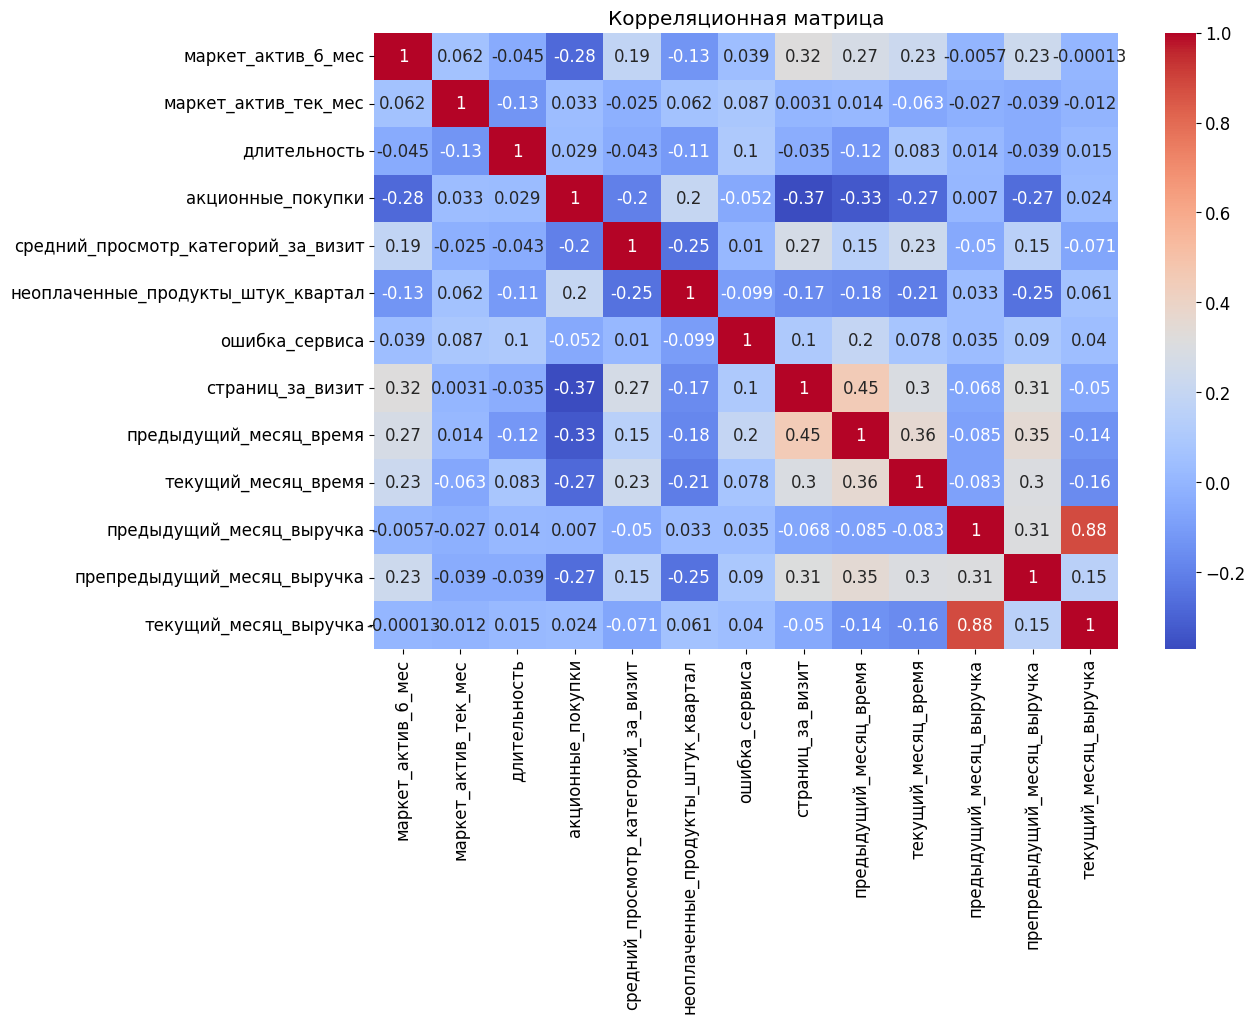

In [62]:
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(df_full.corr(method='spearman', numeric_only=True), annot=True, cmap='coolwarm', ax=ax)
plt.title('Корреляционная матрица');

Сложно сказать о наличии мультиколлинеарности тут, наибольшее значение по корреляции имеют признаки `Страниц за визит` и `Предыдущий месяц время` - 0.45, что не так много, а максимальное отрицательное значение составляет -0.36 между `Страниц за визит` и `Акционные покупки`. Стоит учесть что здесь рассматривались только количественные признаки, поэтому построим матрицу со всеми признаками.

In [63]:
interval_cols = ['маркет_актив_6_мес', 
                 'маркет_актив_тек_мес', 
                 'длительность', 
                 'акционные_покупки', 
                 'предыдущий_месяц_выручка',
                 'предыдущий_месяц_время',
                 'текущий_месяц_время',
                 'препредыдущий_месяц_выручка',
                 'текущий_месяц_выручка']

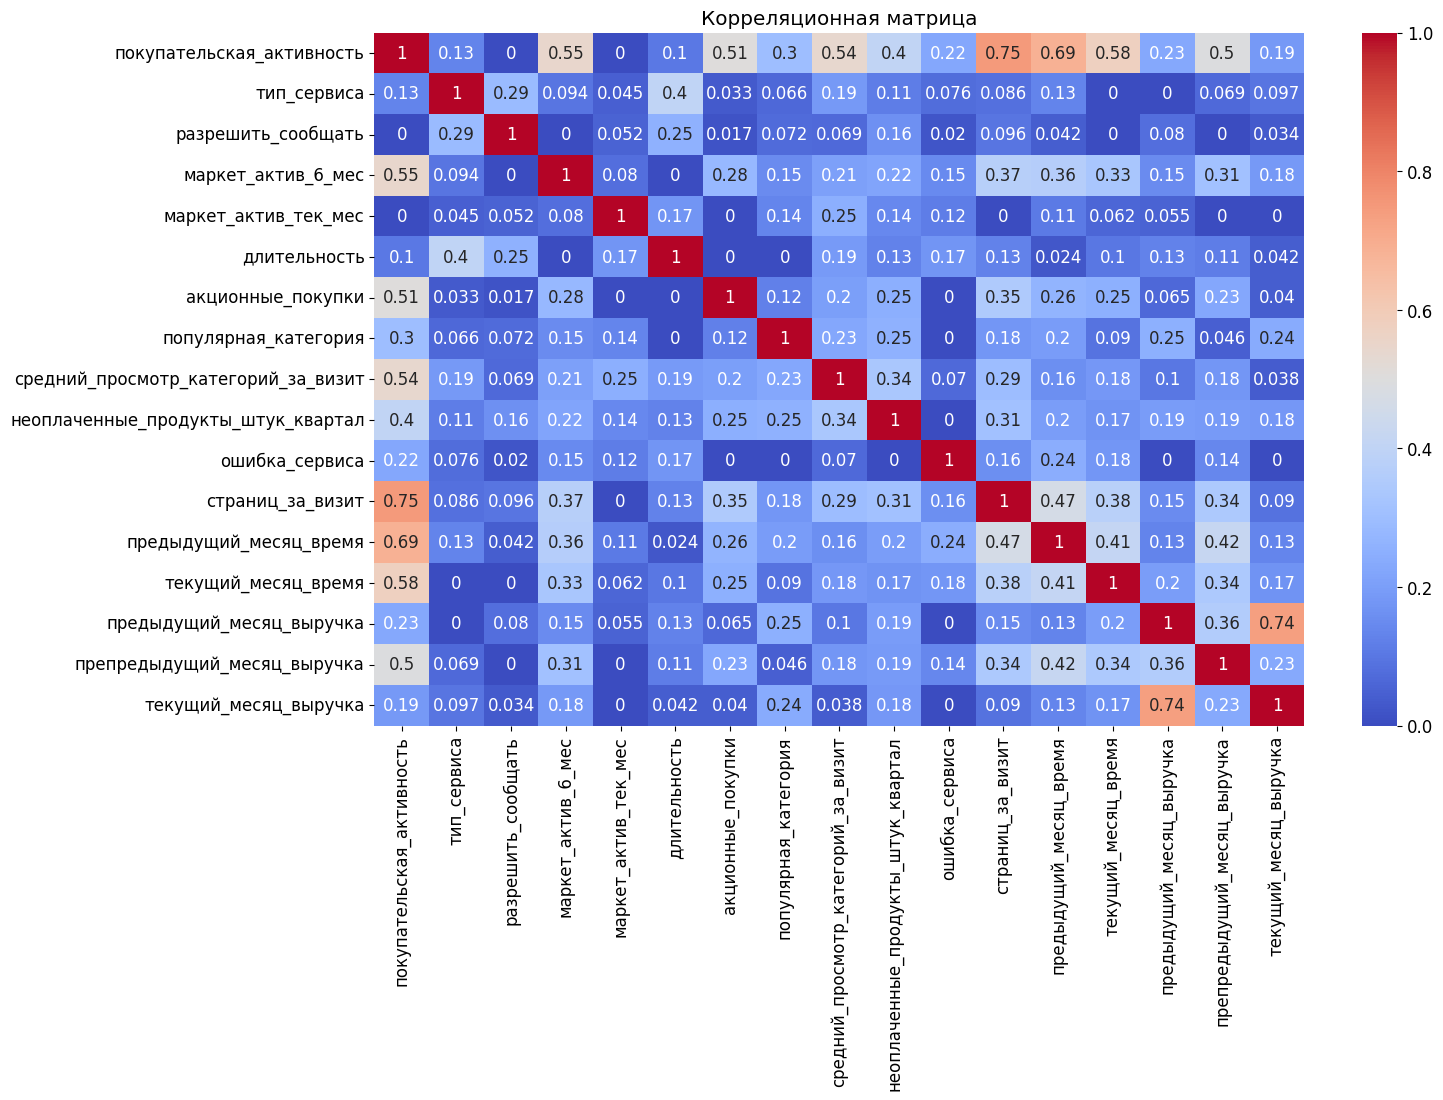

In [64]:
plt.rcParams["figure.figsize"] = (15,9)
(sns.heatmap(df_full
             .phik_matrix(interval_cols=interval_cols), annot=True, cmap='coolwarm'))
plt.title('Корреляционная матрица');

Здесь ситуация уже меняется. Здесь максимальное значение корреляции составляет уже 0.75 между признаками `покупательская активность` и `страниц за визит`, а также между `акционные покупки` и `препредыдущий месяц выручка`. Данное значение уже довольно большое, однако пока не будем утверждать о наличии мультиколлинеарности. Также стоит отметить признак `текущий месяц выручка` который не коррелирует почти ни с одним признаком. 

Посмотрим как эти признаки распредены в матрице по отдельности

In [65]:
phik_overview = df_full.phik_matrix(interval_cols=interval_cols)

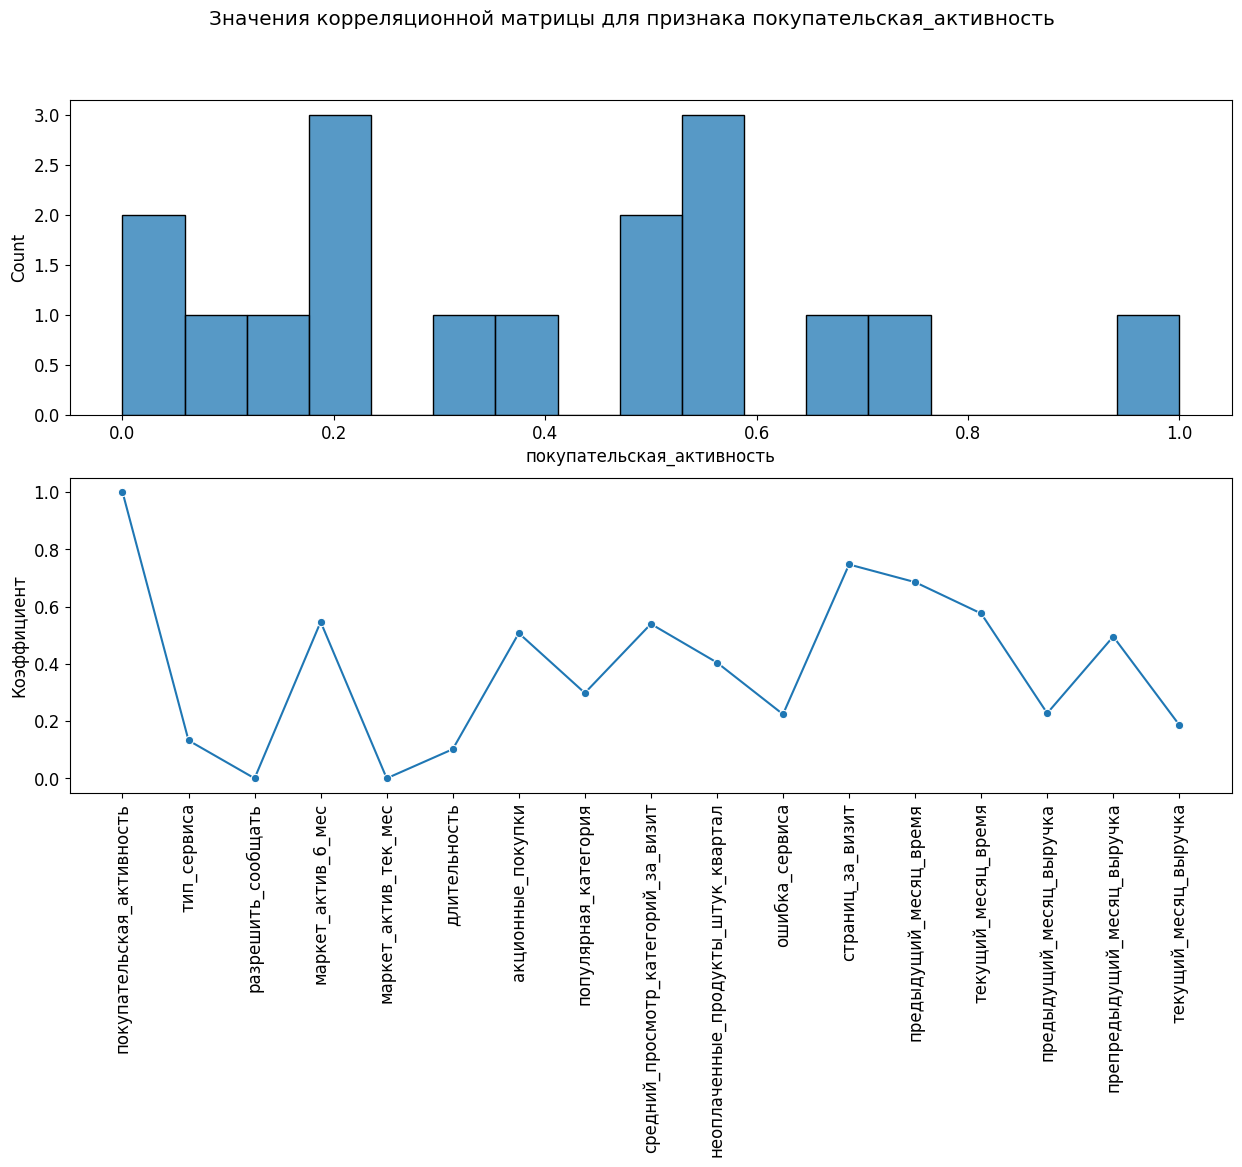

In [66]:
from_phik('покупательская_активность')

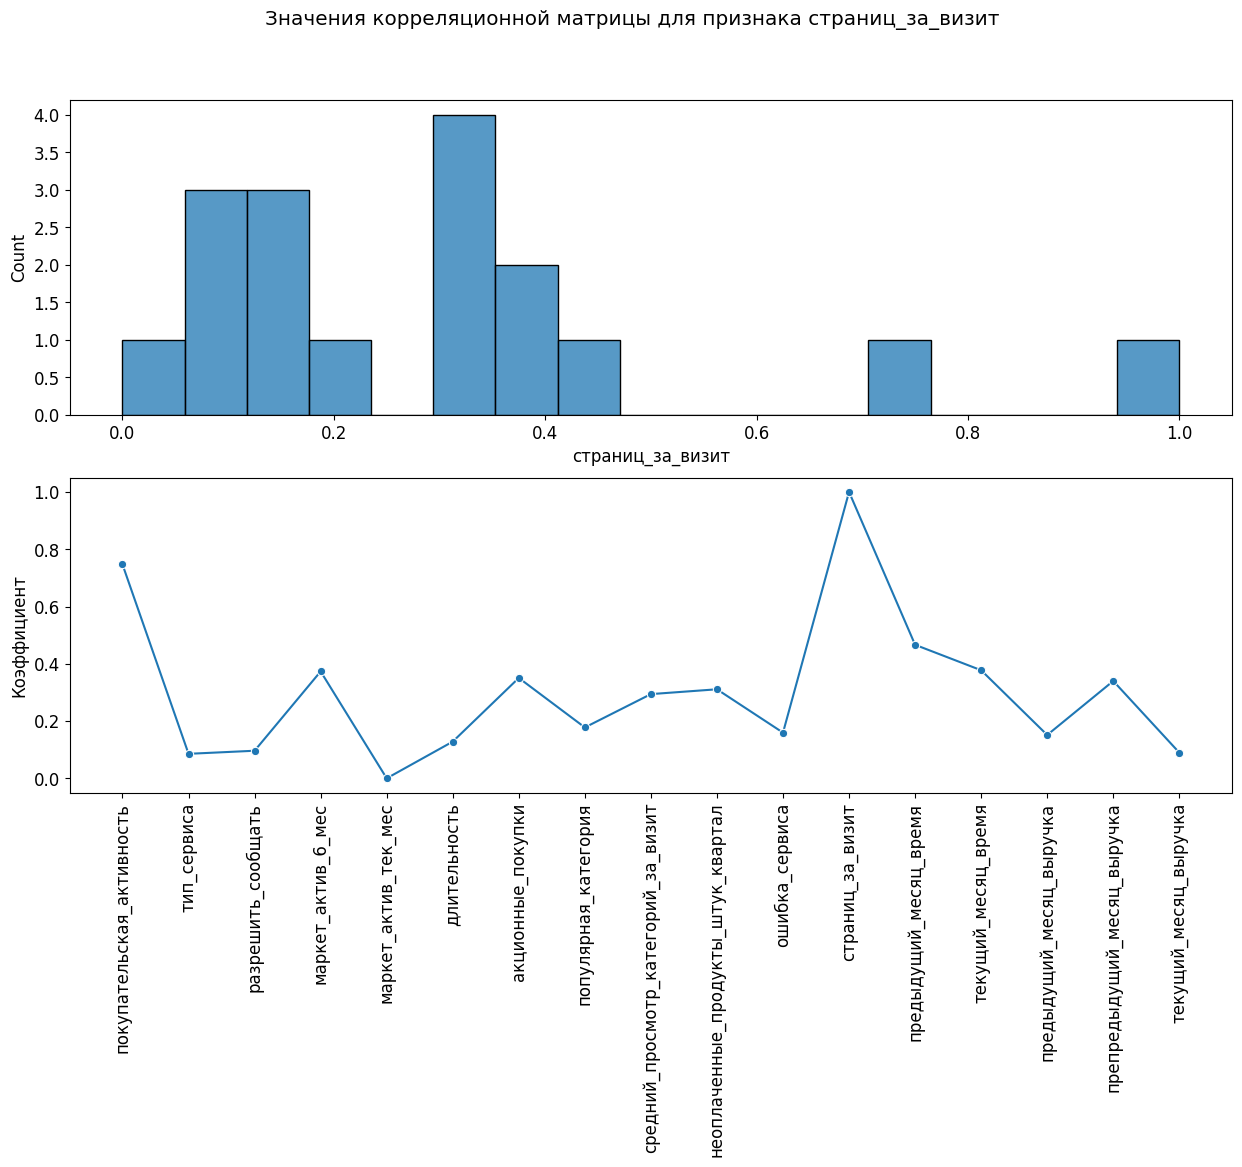

In [67]:
from_phik('страниц_за_визит')

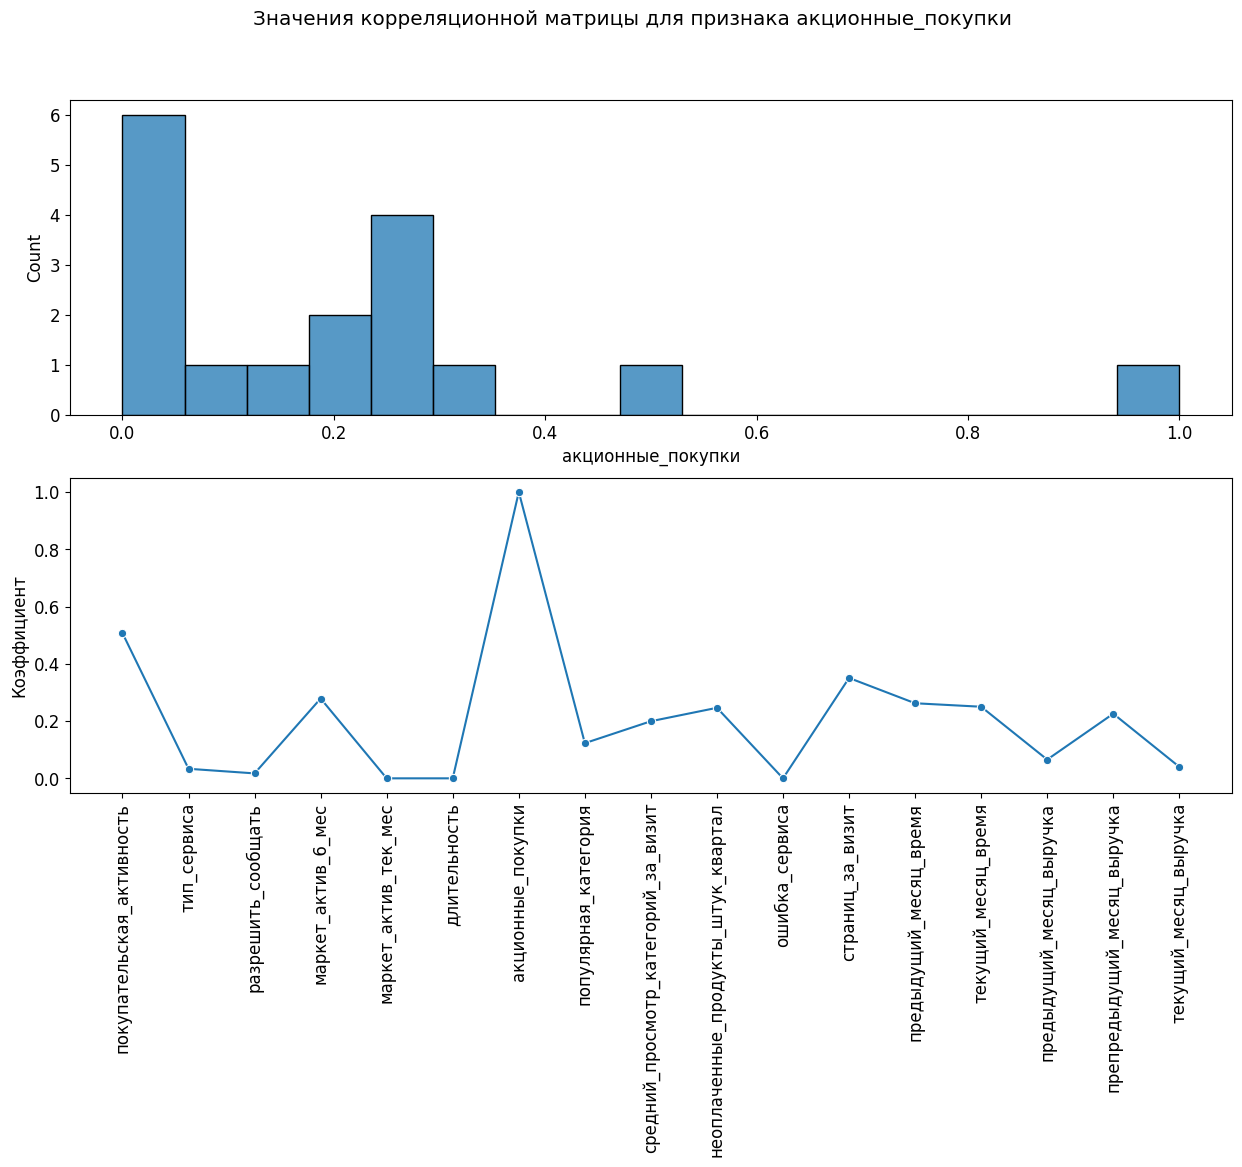

In [68]:
from_phik('акционные_покупки')

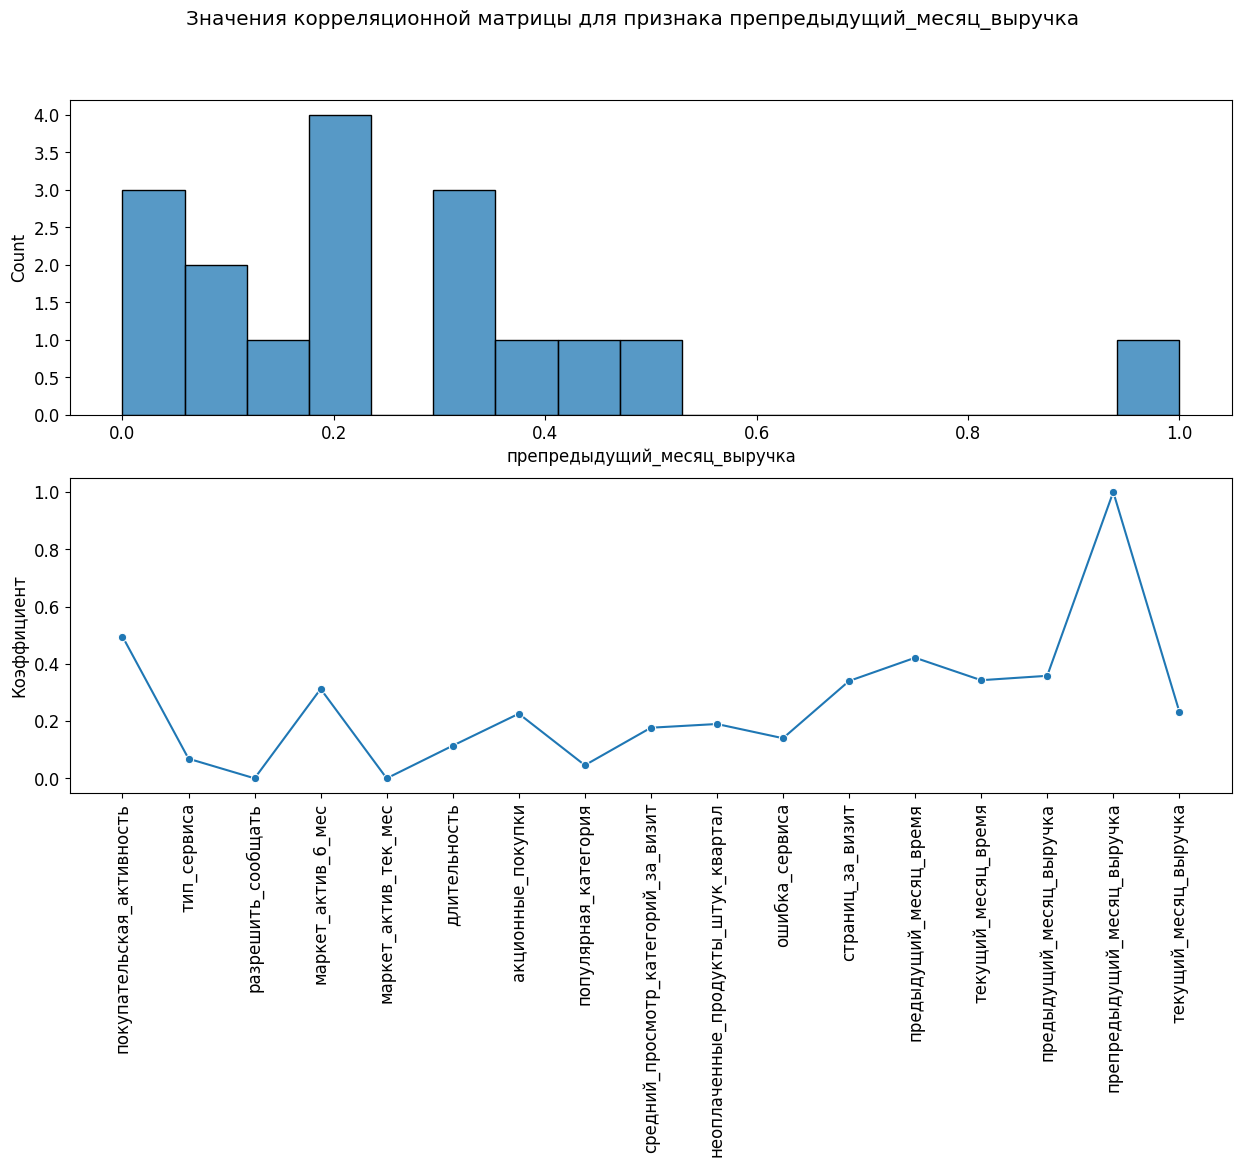

In [69]:
from_phik('препредыдущий_месяц_выручка')

Для дополнительной проверки на мультиколлинеарность рассчитаем коэффициент инфляции дисперсии (VIF)

In [70]:
df_vif = df_full.copy()

In [71]:
X = add_constant(df_vif[num_subset[1:]])
vif_data = pd.DataFrame()
vif_data["Column"] = X.columns
 
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

                                Column        VIF
0                                const  80.216564
1                   маркет_актив_6_мес   1.168204
2                 маркет_актив_тек_мес   1.037157
3                         длительность   1.051080
4                    акционные_покупки   1.155803
5  средний_просмотр_категорий_за_визит   1.151849
6   неоплаченные_продукты_штук_квартал   1.147670
7                       ошибка_сервиса   1.038889
8                     страниц_за_визит   1.234484


Признак `страниц_за_визит` имеет самый высокий коэффициент инфляции дисперсии - 1.23, но недостаточно высокий чтобы говорить о мультиколлинеарности. 

Посмотрим отдельно на каждое значение корреляционной матрицы для признака "Покупательская активность"

In [72]:
down = df_full[df_full['покупательская_активность']=='Снизилась']
down.head()

покупательская_активность тип_сервиса разрешить_сообщать  \
id                                                                
215349                 Снизилась     премиум                 да   
215350                 Снизилась    стандарт                нет   
215351                 Снизилась    стандарт                 да   
215352                 Снизилась    стандарт                нет   
215353                 Снизилась    стандарт                 да   

        маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
id                                                               
215349                 4.4                     4           819   
215350                 4.9                     3           539   
215351                 3.2                     5           896   
215352                 5.1                     3          1064   
215353                 3.3                     4           762   

        акционные_покупки популярная_категория  \
id                                               
215349               0.75     Товары для детей   
215350               0.14    Домашний текстиль   
215351               0.99     Товары для детей   
215352               0.94     Товары для детей   
215353               0.26    Домашний текстиль   

        средний_просмотр_категорий_за_визит  \
id                                            
215349                                    4   
215350                                    5   
215351                                    5   
215352                                    3   
215353                                    4   

        неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
id                                                                             
215349                                   4               2                 5   
215350                                   2               1                 5   
215351                                   0               6                 4   
215352                                   2               3                 2   
215353                                   1               1                 4   

        предыдущий_месяц_время  текущий_месяц_время  предыдущий_месяц_выручка  \
id                                                                              
215349                    12.0                 10.0                    5216.0   
215350                     8.0                 13.0                    5457.5   
215351                    11.0                 13.0                    6158.0   
215352                     8.0                 11.0                    5807.5   
215353                    10.0                 10.0                    4738.5   

        препредыдущий_месяц_выручка  текущий_месяц_выручка  
id                                                          
215349                       4472.0                 4971.6  
215350                       4826.0                 5058.4  
215351                       4793.0                 6610.4  
215352                       4594.0                 5872.5  
215353                       5124.0                 5388.5

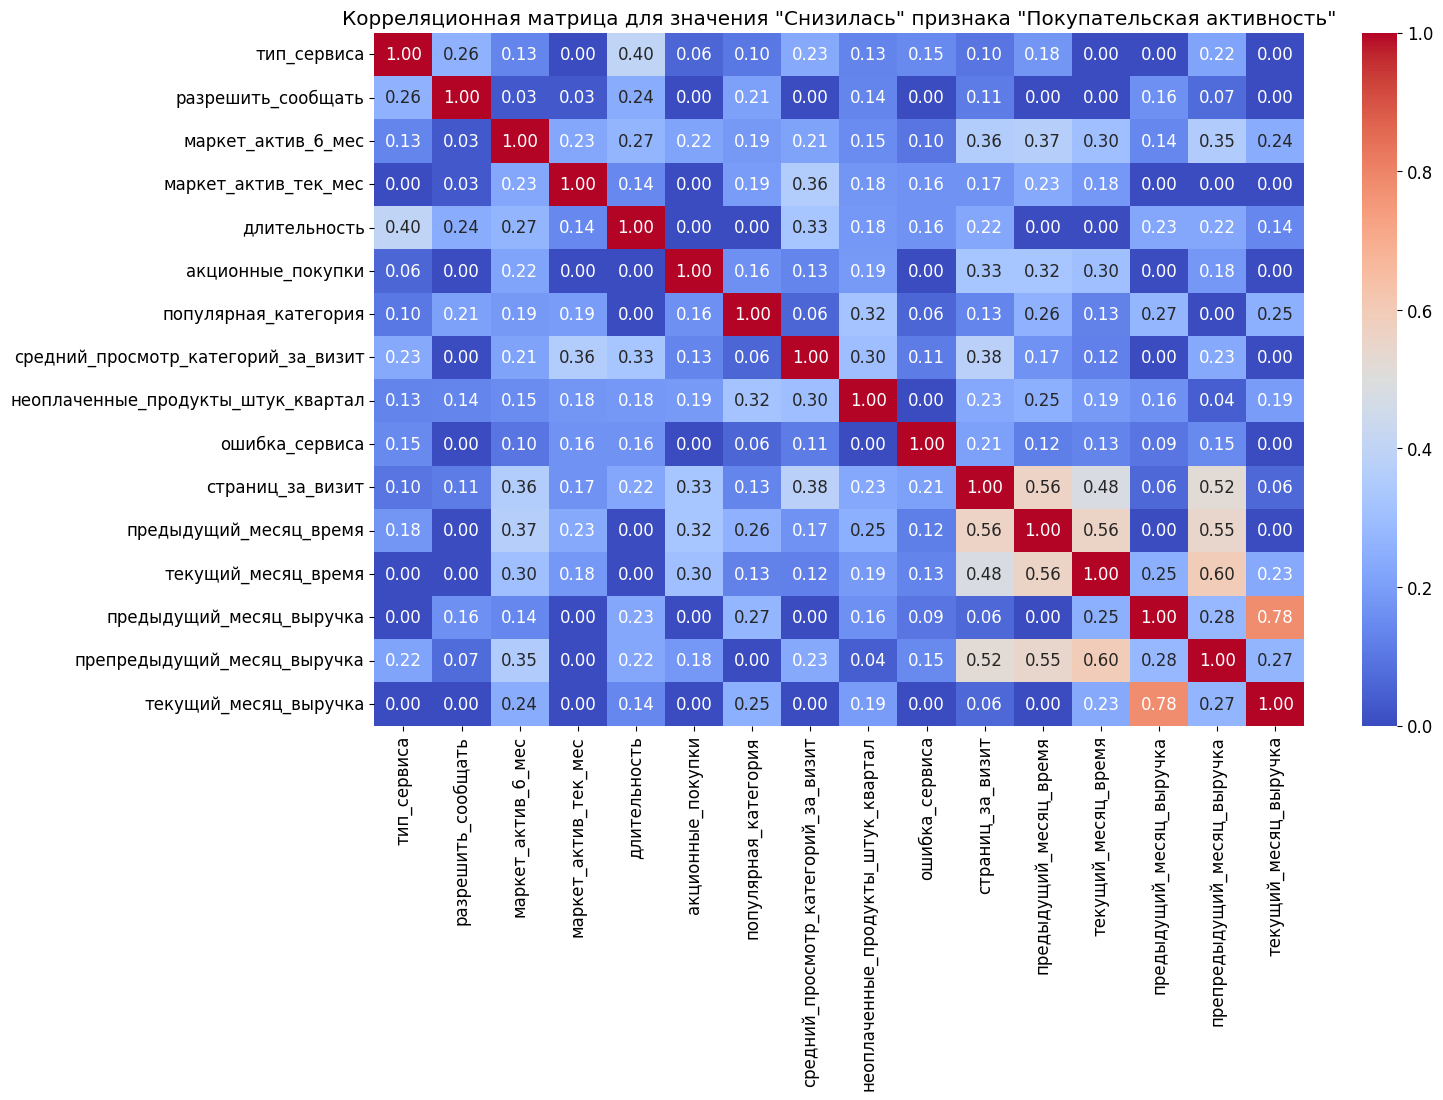

In [73]:
plt.rcParams["figure.figsize"] = (15,9)
(sns.heatmap(down
             .phik_matrix(interval_cols=interval_cols), 
             annot=True, 
             fmt='.2f', 
             cmap='coolwarm'))
plt.title('Корреляционная матрица для значения "Снизилась" признака "Покупательская активность"')
plt.show()

При такой фильтрации наблюдается сильная корреляция между `акционные покупки` и `препредыдущий месяц выручка`, что обуславливается скорее всего хорошими акционными предложениями в том периоде.

In [74]:
up = df_full[df_full['покупательская_активность']=='Прежний уровень']
up.head()

покупательская_активность тип_сервиса разрешить_сообщать  \
id                                                                
215748           Прежний уровень    стандарт                нет   
215749           Прежний уровень     премиум                 да   
215750           Прежний уровень    стандарт                 да   
215751           Прежний уровень    стандарт                 да   
215752           Прежний уровень    стандарт                нет   

        маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
id                                                               
215748                 4.3                     4           534   
215749                 5.8                     5           624   
215750                 4.8                     5           634   
215751                 4.1                     4           957   
215752                 4.0                     4           475   

        акционные_покупки                  популярная_категория  \
id                                                                
215748               0.18                       Кухонная посуда   
215749               0.30        Техника для красоты и здоровья   
215750               0.21                      Товары для детей   
215751               0.17        Техника для красоты и здоровья   
215752               0.30  Мелкая бытовая техника и электроника   

        средний_просмотр_категорий_за_визит  \
id                                            
215748                                    3   
215749                                    4   
215750                                    4   
215751                                    5   
215752                                    3   

        неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
id                                                                             
215748                                   1               4                10   
215749                                   3               6                14   
215750                                   5               3                10   
215751                                   2               6                 9   
215752                                   3               7                 7   

        предыдущий_месяц_время  текущий_месяц_время  предыдущий_месяц_выручка  \
id                                                                              
215748                    13.0                 13.0                    5083.0   
215749                    14.0                 17.0                    5190.0   
215750                    13.0                 14.0                    3319.0   
215751                    14.0                 12.0                    5340.0   
215752                    13.0                  8.0                    5188.5   

        препредыдущий_месяц_выручка  текущий_месяц_выручка  
id                                                          
215748                       4552.0                 5673.2  
215749                       4928.0                 5092.5  
215750                       4730.0                 4672.3  
215751                       4769.0                 5021.5  
215752                       4635.0                 5798.2

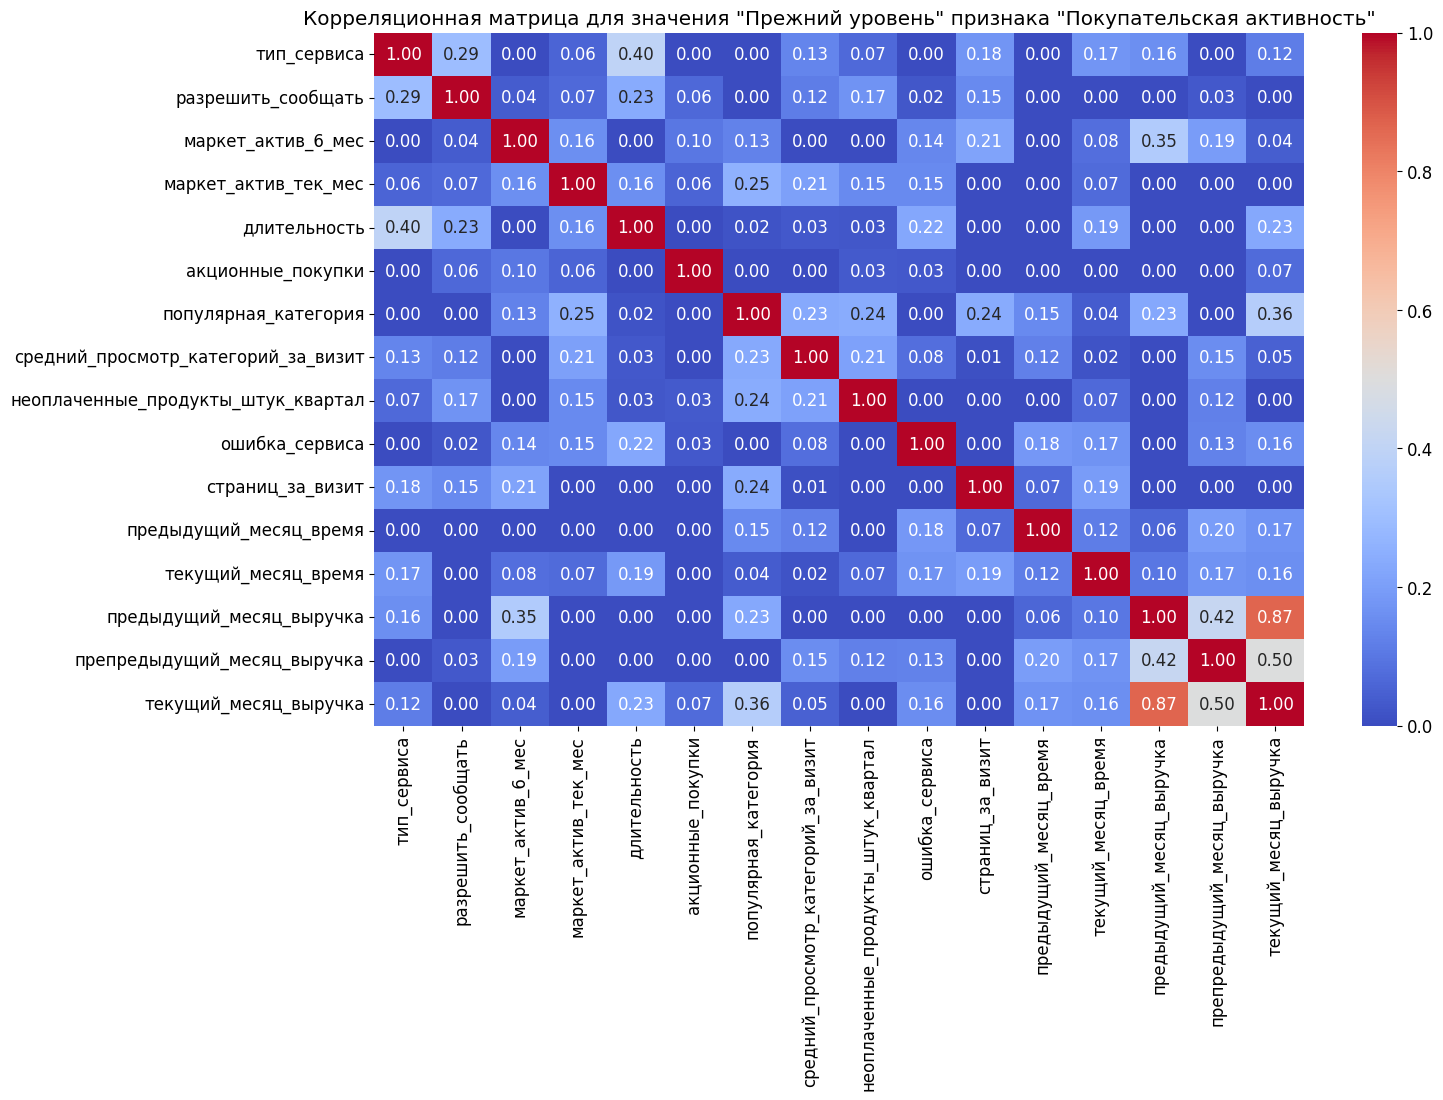

In [75]:
(sns.heatmap(up
             .phik_matrix(interval_cols=interval_cols), 
             annot=True, 
             fmt='.2f', 
             cmap='coolwarm'))
plt.rcParams["figure.figsize"] = (15,9)
plt.title('Корреляционная матрица для значения "Прежний уровень" признака "Покупательская активность"')
plt.show()

При такой фильтрации наблюдается сильная корреляция между `текущий месяц выручка` и `предыдущий месяц выручка`, что обуславливается скорее всего просто ростом выручки в последующем периоде. 

In [76]:
num_subset_full = df_full.select_dtypes('number').columns

In [77]:
num_subset_full

Index(['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит', 'предыдущий_месяц_время', 'текущий_месяц_время',
       'предыдущий_месяц_выручка', 'препредыдущий_месяц_выручка',
       'текущий_месяц_выручка'],
      dtype='object')

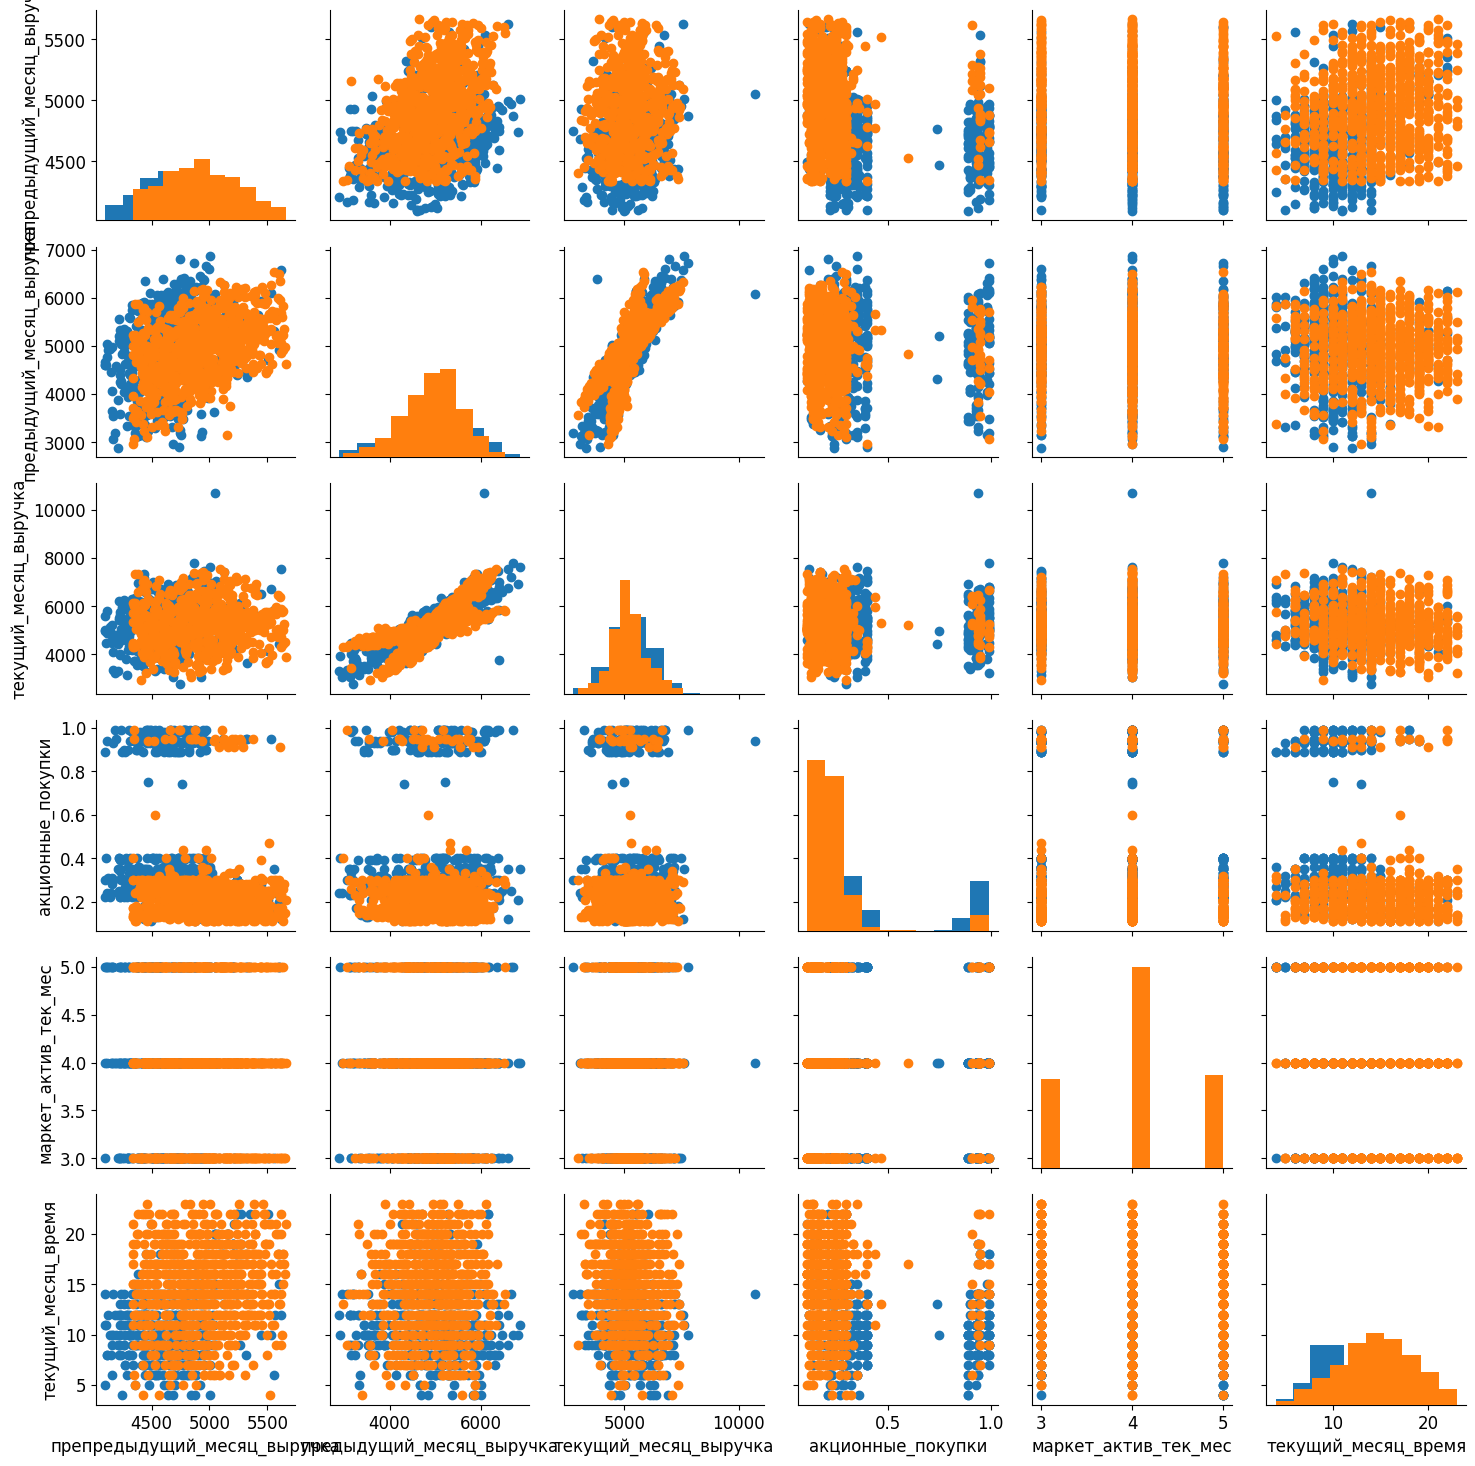

In [78]:
p = sns.PairGrid(df_full, vars=['препредыдущий_месяц_выручка', 'предыдущий_месяц_выручка', 'текущий_месяц_выручка', 'акционные_покупки', 'маркет_актив_тек_мес', 'текущий_месяц_время'], hue='покупательская_активность')
p.map_diag(plt.hist)
p.map_offdiag(plt.scatter)
plt.show()

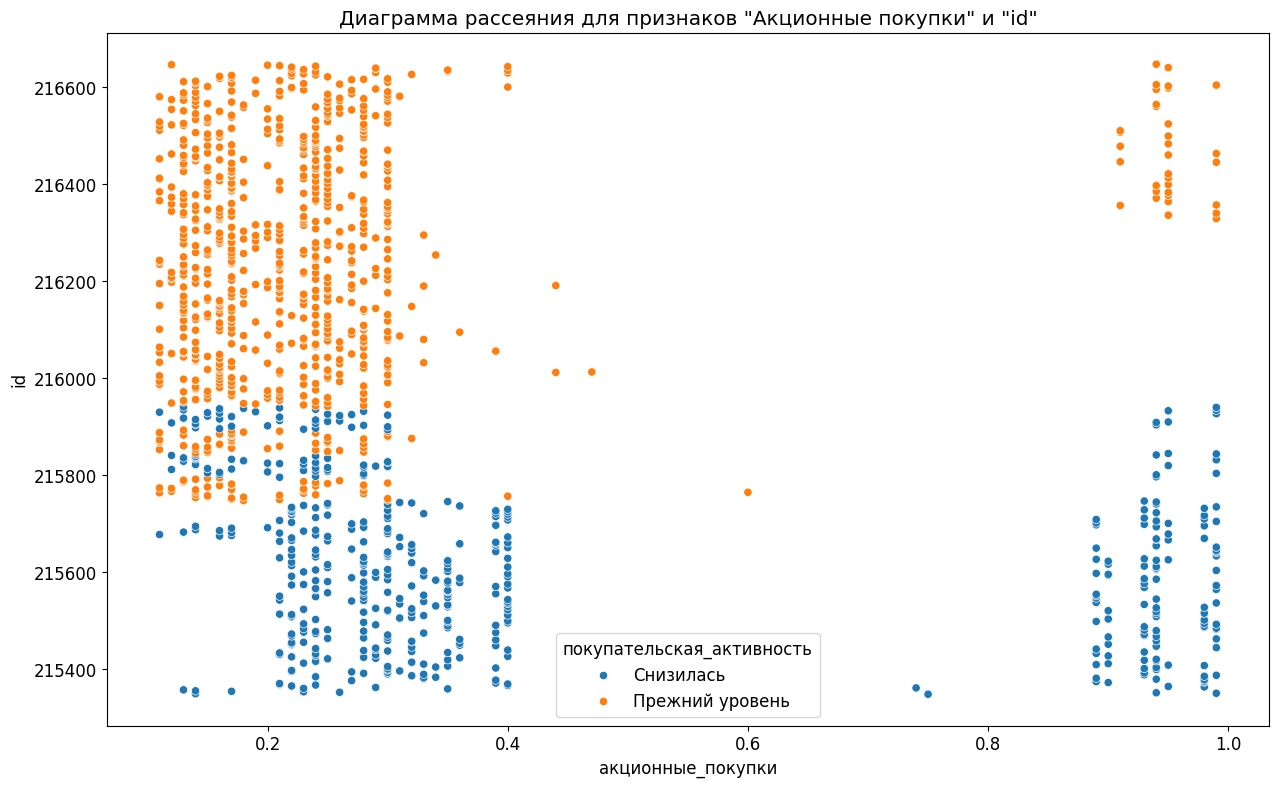

In [79]:
sns.scatterplot(data=df_full, y='id', x='акционные_покупки', hue='покупательская_активность')
plt.title('Диаграмма рассеяния для признаков "Акционные покупки" и "id"')
plt.show();

<a id='report_corr'></a>
## Предварительный вывод

На данном этапе был проведен корреляционный анализ. При построении корреляционной матрицы будет использован метод Пирсона, потому что большинство данных распределено нормально и не содержат большого количества выбросов.

При построении корреляционной матрицы только по количествым признакам, максимальное значение корреляции составило 0.45 между признаками `Страниц за визит` и `Предыдущий месяц время`, а минимальное составляет -0.36 между `страниц за визит` и `акционные покупки`. 

При построении матрицы со всеми признакми, максимальное значение корреляции составляет уже 0.75 между признаками `покупательская активность` и `страниц за визит`, а также между `акционные покупки` и `препредыдущий месяц выручка`. Также было отмечено что признак `текущий месяц выручка` не коррелирует почти ни с одним признаком.

Признак `страниц_за_визит` имеет самый высокий коэффициент инфляции дисперсии - 1.23, но недостаточно высокий чтобы говорить о мультиколлинеарности.

<a id='pipe'></a>
## Использование пайплайнов

Создадим пайплайн, который найдет лучшую модель с лучшими параметрами и на основе нее мы будем делать прогноз.

In [80]:
X_train, X_test, y_train, y_test = train_test_split(
    df_full.drop(['покупательская_активность'], axis=1),
    df_full['покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = df_full['покупательская_активность'])
print(y_train)

X_train.shape, X_test.shape

# создаём списки с названиями признаков
ohe_columns = ['тип_сервиса', 'разрешить_сообщать', 'популярная_категория']
num_columns = ['маркет_актив_6_мес', 
               'маркет_актив_тек_мес', 
               'длительность', 
               'акционные_покупки', 
               'средний_просмотр_категорий_за_визит', 
               'неоплаченные_продукты_штук_квартал', 
               'ошибка_сервиса', 'страниц_за_визит', 
               'предыдущий_месяц_время', 
               'текущий_месяц_время', 
               'предыдущий_месяц_выручка', 
               'препредыдущий_месяц_выручка', 
               'текущий_месяц_выручка']

# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, 
                                         strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', 
                           handle_unknown='error', 
                           sparse_output=False))
    ]
    )

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,5),
        'models__max_features': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  

    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
q = randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Самая высокая точность из всех построенных моделей:', randomized_search.best_score_)



id
215858    Прежний уровень
215361          Снизилась
215884    Прежний уровень
216563    Прежний уровень
215714          Снизилась
               ...       
216157    Прежний уровень
216177    Прежний уровень
215802          Снизилась
215863    Прежний уровень
216030    Прежний уровень
Name: покупательская_активность, Length: 972, dtype: object
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]

In [81]:
y_test_pred = randomized_search.predict(X_test)
pred = randomized_search.predict_proba(X_test)[:, 1]
print(f'Метрика ROC-AUC: {roc_auc_score(y_test, pred)}')


Метрика ROC-AUC: 0.9232867918472155


In [82]:
y_train

id
215858    Прежний уровень
215361          Снизилась
215884    Прежний уровень
216563    Прежний уровень
215714          Снизилась
               ...       
216157    Прежний уровень
216177    Прежний уровень
215802          Снизилась
215863    Прежний уровень
216030    Прежний уровень
Name: покупательская_активность, Length: 972, dtype: object

<a id='report_pipe'></a>
## Предварительный вывод

Лучшая модель **LogisticRegression** со следующими характеристиками *C=2, penalty='l1', random_state=42, solver='liblinear'*

Самая высокая точность из всех построенных моделей: 0.8986085548358276

Метрика ROC-AUC: 0.9232867918472155

<a id='important'></a>
## Анализ важности признаков

In [83]:
from sklearn import tree

In [84]:
randomized_search.get_params(['models'])

{'cv': 5,
 'error_score': nan,
 'estimator__memory': None,
 'estimator__steps': [('preprocessor',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('ohe',
                                    Pipeline(steps=[('simpleImputer_ohe',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('ohe',
                                                     OneHotEncoder(drop='first',
                                                                   sparse_output=False))]),
                                    ['тип_сервиса', 'разрешить_сообщать',
                                     'популярная_категория']),
                                   ('num', MinMaxScaler(),
                                    ['маркет_актив_6_мес', 'маркет_актив_тек_мес',
                                     'длительность', 'акционные_покупки',
                                     'средний_просмотр_кат

In [85]:
randomized_search.best_params_

{'preprocessor__num': MinMaxScaler(),
 'models__C': 2,
 'models': LogisticRegression(penalty='l1', random_state=42, solver='liblinear')}

In [86]:
randomized_search.best_score_

0.8986085548358276

In [87]:
best_model = randomized_search.best_estimator_
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['тип_сервиса',
                                                   'разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('num', MinMaxScaler(),
                                                  ['маркет_актив_6_мес',
                                                   'маркет_актив_...
                                                   'длительность',
                                                   'акционные_покупки',
                                                   'средний_просмотр_категорий_за_визит',
                                                   'неоплаченные_продукты_штук_квартал',
                                                   'ошибка_сервиса',
                                                   'страниц_за_визит',
                                                   'предыдущий_месяц_время',
                                                   'текущий_месяц_время',
                                                   'предыдущий_месяц_выручка',
                                                   'препредыдущий_месяц_выручка',
                                                   'текущий_месяц_выручка'])])),
                ('models',
                 LogisticRegression(C=2, penalty='l1', random_state=42,
                                    solver='liblinear'))])

In [88]:
decision_tree = best_model.named_steps['models']
decision_tree

LogisticRegression(C=2, penalty='l1', random_state=42, solver='liblinear')

In [89]:
pipe_final.named_steps['preprocessor']

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('simpleImputer_ohe',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False))]),
                                 ['тип_сервиса', 'разрешить_сообщать',
                                  'популярная_категория']),
                                ('num', MinMaxScaler(),
                                 ['маркет_актив_6_мес', 'маркет_актив_тек_мес',
                                  'длительность', 'акционные_покупки',
                                  'средний_просмотр_категорий_за_визит',
                                  'неоплаченные_продукты_штук_квартал',
                                  'ошибка_сервиса', 'страниц_за_визит',
                                  'предыдущий_месяц_время',
                                  'текущий_месяц_время',
                                  'предыдущий_месяц_выручка',
                                  'препредыдущий_месяц_выручка',
                                  'текущий_месяц_выручка'])])

In [90]:
#!pip install python-graphviz


In [91]:
def custom_f1(model, X,y):
    """
    Функция которая получает на вход модель и две выборки,
    рассчитывает f1_score и возвращает ее
    """
    y_pred = model.predict(X)
    score = f1_score(y, y_pred, pos_label='Прежний уровень')
    return score

Проведем анализ важности признаков

In [92]:
X_train_shap = (pipe_final
                .named_steps['preprocessor']
                .fit_transform(X_train))

In [93]:
explainer = (shap
             .LinearExplainer(randomized_search
                              .best_estimator_
                              .named_steps['models'], 
                              X_train_shap, 
                              feature_names=pipe_final
                              .named_steps['preprocessor']
                              .get_feature_names_out()))

In [94]:
X_test_shap = pipe_final.named_steps['preprocessor'].transform(X_test)

In [95]:
shap_values = explainer(X_test_shap)

Для начала построим график общей значимости признаков.

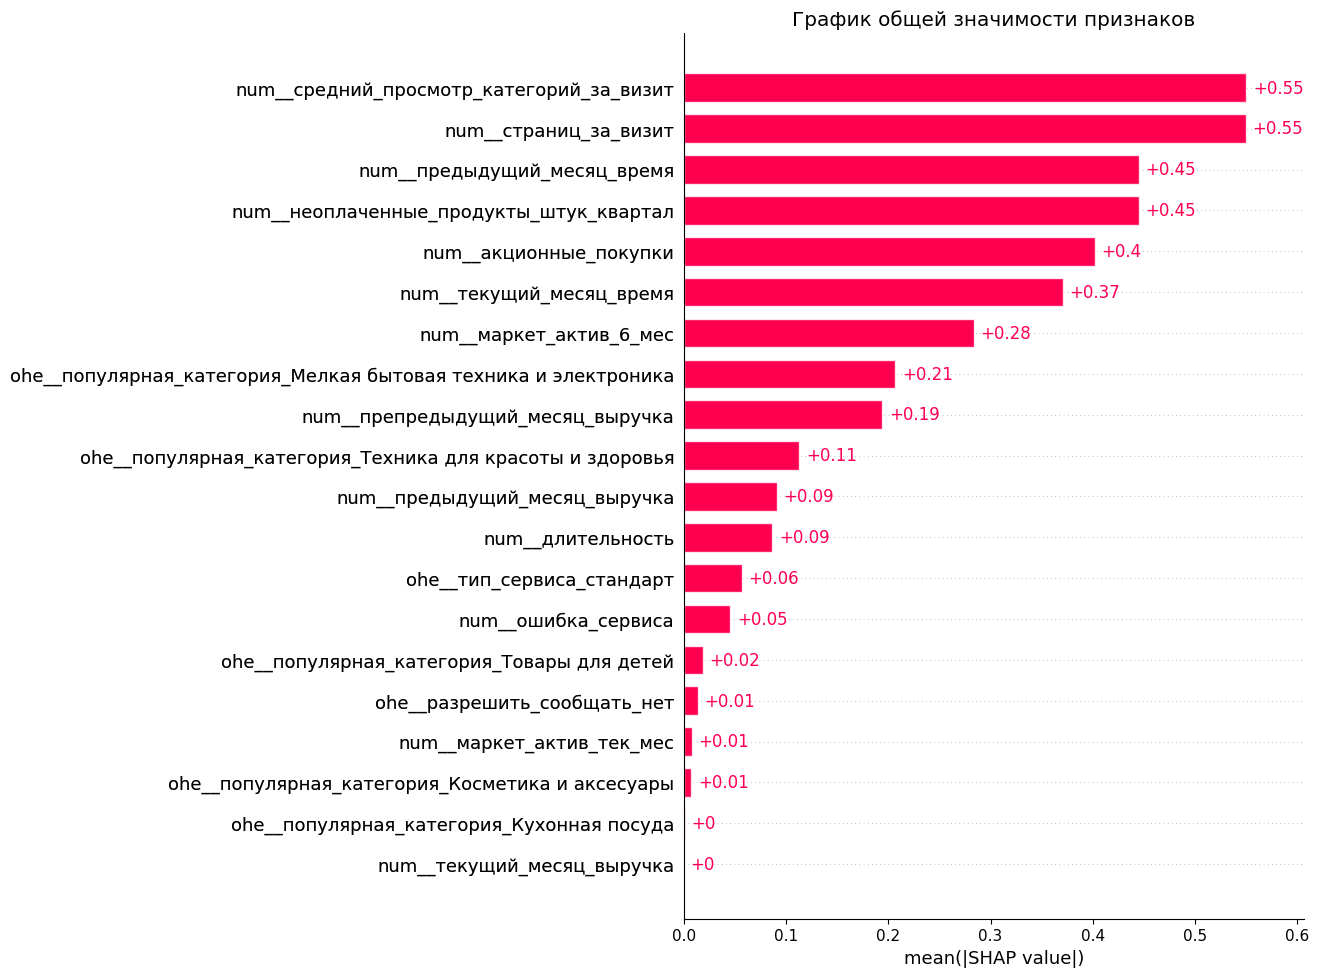

In [96]:
plt.title('График общей значимости признаков')
shap.plots.bar(shap_values, max_display = 20)

Наиболее высокие значения у признаков `Страниц за визит` и `Средний просмотр категорий за визит`. Если их убрать, то качество модели просядет сильнее всего.

Теперь посмотрим как признаки влияют на каждое предсказание модели

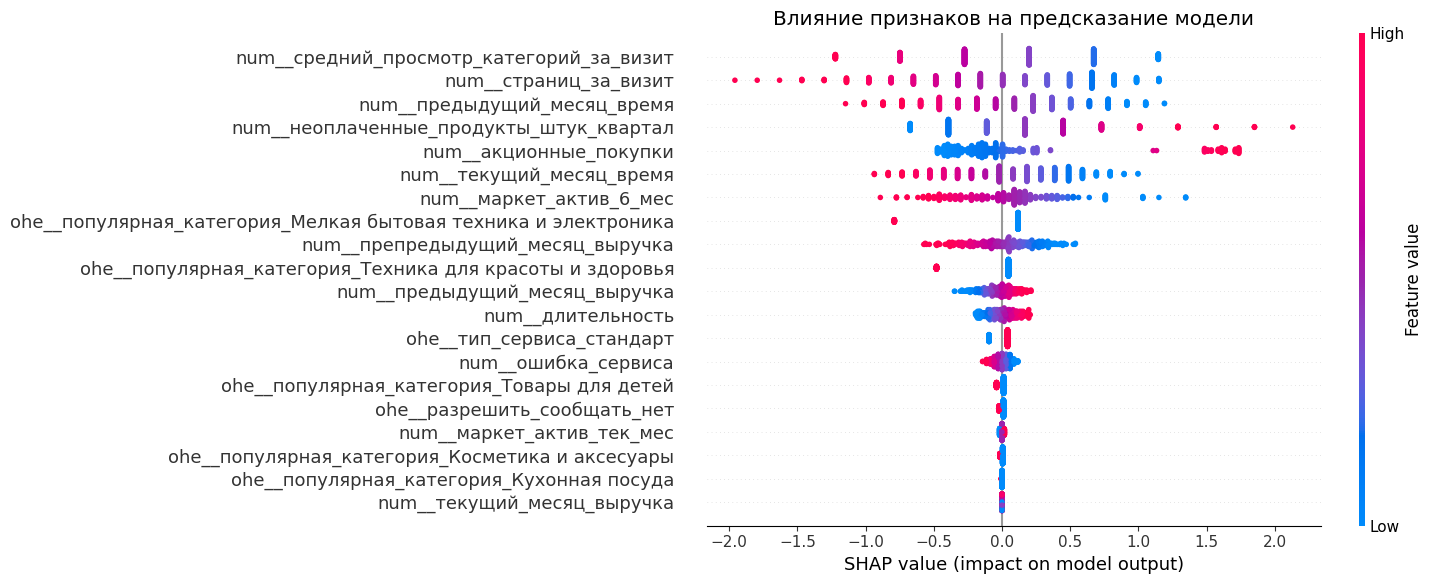

In [97]:
plt.title('Влияние признаков на предсказание модели')
(shap.summary_plot(shap_values,
                  X_test_shap,
                  show=False,
                  plot_size =[15,6], 
                  feature_names = pipe_final
                  .named_steps['preprocessor']
                  .get_feature_names_out()))

Признак `Страниц за визит` находится на первом месте по разбросу shap-values. Высокие значения по этому признаку сдвигают прогноз в сторону отнесения к классу 0. То есть чем меньше страниц открывается, тем большая вероятность отнесения к классу 0. 
Другой пример, признак `акционные товары` склоняет к отнесению к классу 1. 

Посмотрим в отдельности на некоторые объекты, какие признаки влияют на них, возьмем 3 объекта. 

In [98]:
expected_value = explainer.expected_value

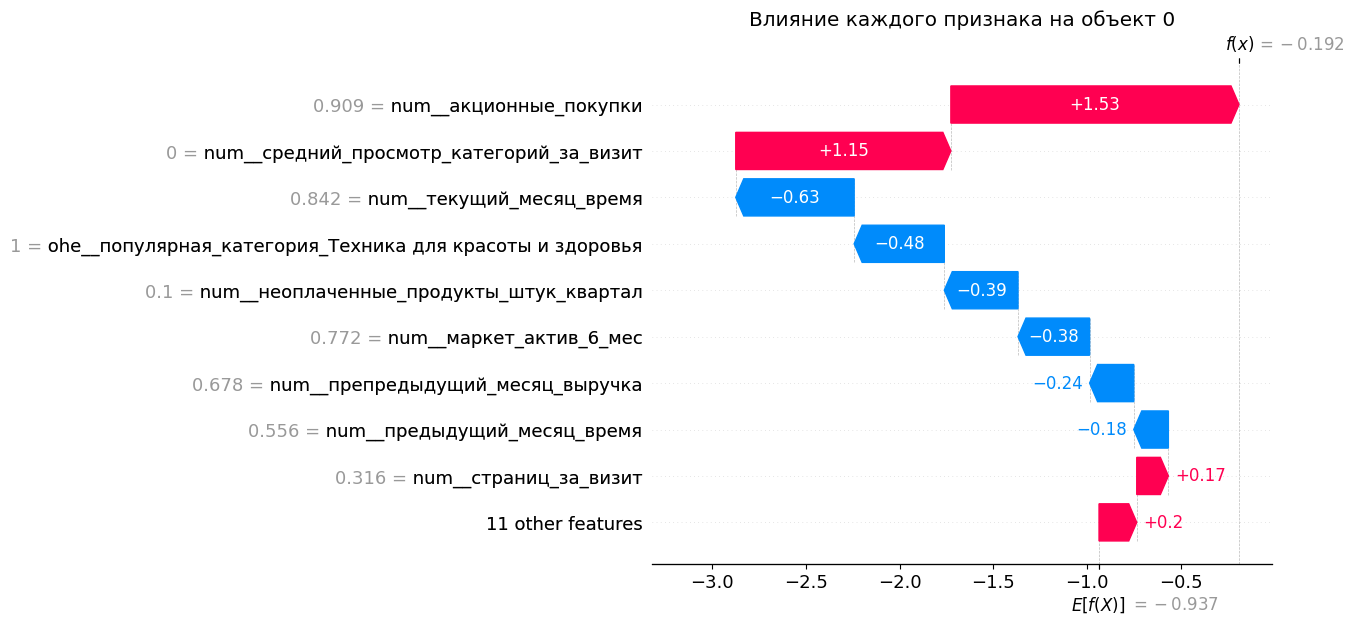

In [99]:
plt.title('Влияние каждого признака на объект 0')
shap.plots.waterfall(shap_values[0], max_display = 10)

In [100]:
(shap
 .force_plot(explainer
             .expected_value, 
             shap_values.values[0], 
             X_test_shap[0], 
             link='logit',
             feature_names = pipe_final
             .named_steps['preprocessor']
             .get_feature_names_out()))

Наибольшее влияние на объект 0 оказывает признак `средний просмотр категорий за визит` который сдвигает прогноз к классу 0.

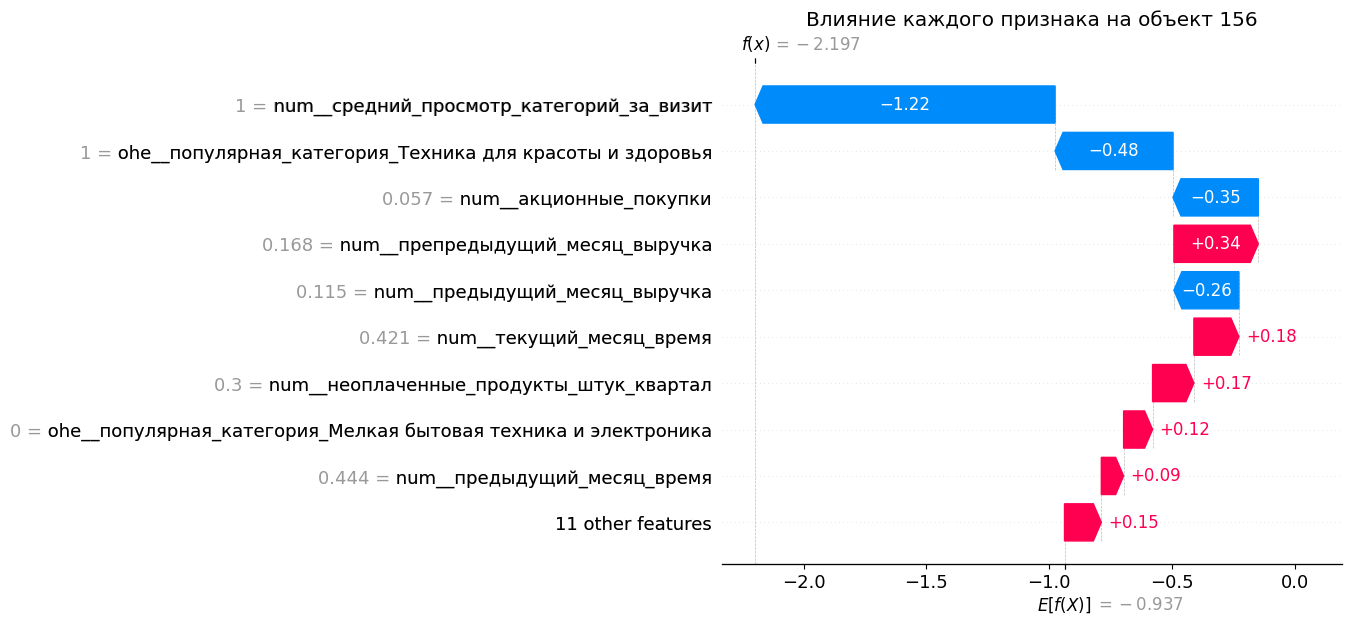

In [101]:
plt.title('Влияние каждого признака на объект 156')
shap.plots.waterfall(shap_values[156], max_display = 10)

In [102]:
(shap
 .force_plot(explainer
             .expected_value, 
             shap_values.values[156], 
             X_test_shap[156],
             link='logit',
             feature_names = pipe_final
             .named_steps['preprocessor']
             .get_feature_names_out()))

Наибольшее влияние на объекта 156 оказывает признак `средний просмотр категорий за визит` который сдвигает прогноз к классу 0.

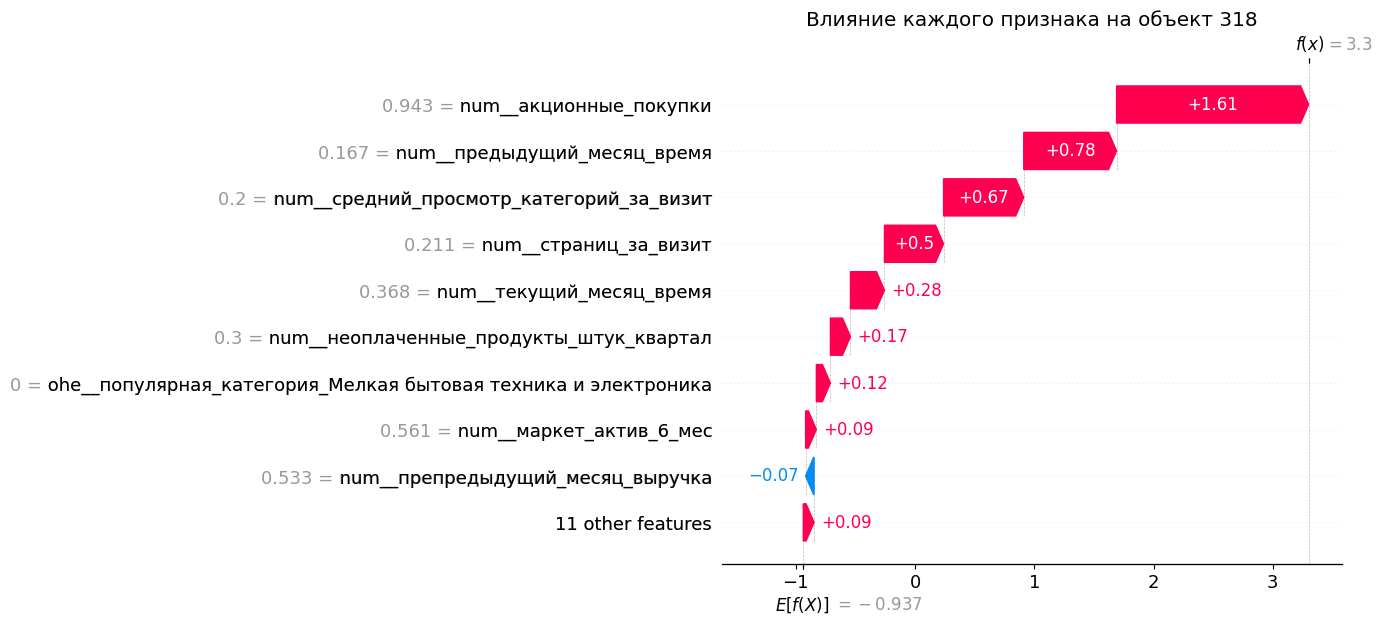

In [103]:
plt.title('Влияние каждого признака на объект 318')
shap.plots.waterfall(shap_values[318], max_display = 10)

In [104]:
(shap
 .force_plot(explainer
             .expected_value, 
             shap_values.values[318],  
             X_test_shap[318], 
             link='logit',
             feature_names = pipe_final
             .named_steps['preprocessor']
             .get_feature_names_out()))

Здесь уже другая ситуация. Наибольшее влияние на объект 318 оказывается признак `средний просмотр категорий за визит` который сдвигает прогноз к классу 1.

Выведем коэффициенты влияния признаков на модель

In [105]:
coefficients = randomized_search.best_estimator_.steps[1][1].coef_

                                              Feature  Importance
19                         num__текущий_месяц_выручка    0.000000
3           ohe__популярная_категория_Кухонная посуда    0.002994
2     ohe__популярная_категория_Косметика и аксесуары    0.020852
1                         ohe__разрешить_сообщать_нет    0.031850
8                           num__маркет_актив_тек_мес    0.033730
6          ohe__популярная_категория_Товары для детей    0.051910
0                           ohe__тип_сервиса_стандарт    0.135629
13                                num__ошибка_сервиса    0.257941
9                                   num__длительность    0.407853
5   ohe__популярная_категория_Техника для красоты ...    0.527703
17                      num__предыдущий_месяц_выручка    0.634454
4   ohe__популярная_категория_Мелкая бытовая техни...    0.907315
18                   num__препредыдущий_месяц_выручка    1.136929
16                           num__текущий_месяц_время    1.932630
10        

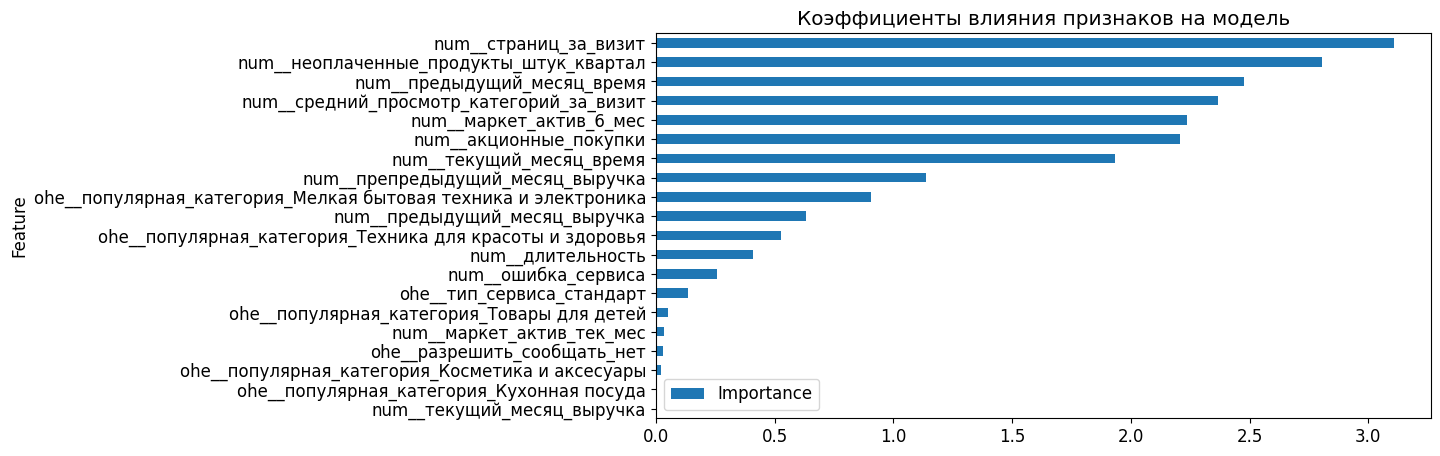

In [106]:
feature_imp = (pd.DataFrame({'Feature': pipe_final.
                             named_steps['preprocessor']
                             .get_feature_names_out(), 
                             'Importance': np
                             .abs(*coefficients)})
               .sort_values(by='Importance', ascending=True))
print(feature_imp)
feature_imp.plot(x='Feature', y='Importance', kind='barh', figsize=(10,5))
plt.title('Коэффициенты влияния признаков на модель')
plt.show()

Наибольшее влияние оказывают признаки `страниц за визит`, `неоплаченные продукты штук квартал` и `акционные покупки`.

Посмотрим насколько изменятся метрики, если поочередно рандомизировать каждый входной признак модели. 

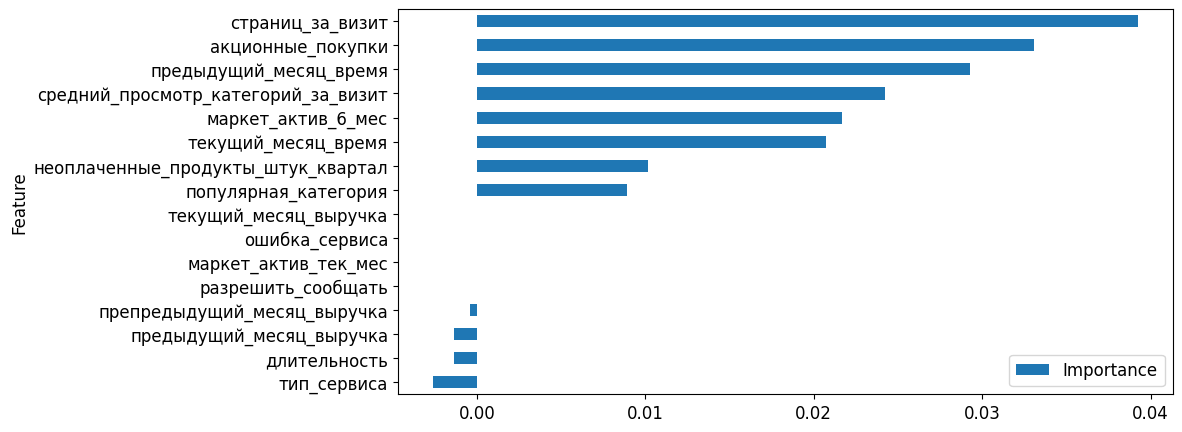

In [107]:
result = permutation_importance(randomized_search, 
                                X_test, 
                                y_test, 
                                scoring=custom_f1)
feature_names = X_test.columns
feature_imp = pd.DataFrame({'Feature': feature_names, 
                            'Importance': result.importances_mean})
feature_imp = feature_imp.sort_values(by='Importance', ascending=True)
feature_imp.plot(x='Feature', y='Importance', kind='barh', figsize=(10,5))
plt.show()

После перемешивания значений некоторые наиболее весомые признаки влияния на метрику f1 изменились, теперь в топе `Страниц за визит`,`Время на сайте в предыдущем месяце` и `Акционные покупки`. 

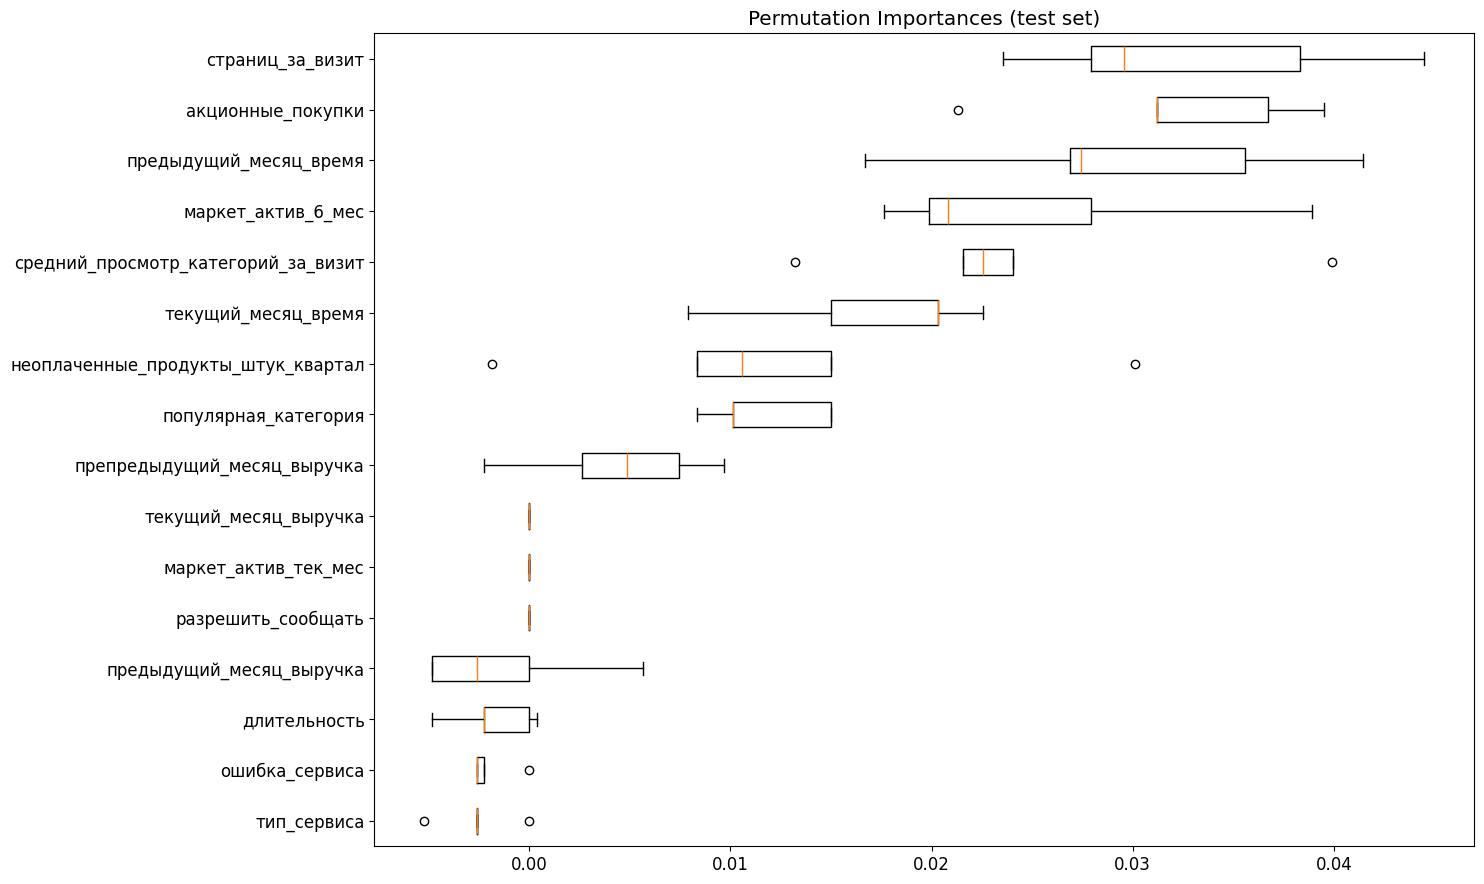

In [108]:
result = permutation_importance(randomized_search, X_test, y_test, scoring=custom_f1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

<a id='report_important'></a>
## Предварительный вывод

Этап анализа важности признаков показал что наиболее высокие значения у признаков `страниц за визит` и `средний просмотр категорий за визит`. Если их убрать, то качество модели просядет сильнее всего.

Признак `страниц за визит` находится на первом месте по разбросу shap-values. Высокие значения по этому признаку сдвигают прогноз в сторону отнесения к классу 0. 

Наибольшее коэффициенты влияния имеют признаки `страниц за визит`, `неоплаченные продукты штук квартал` и `акционные покупки`.

Если рандомизировать входные данные, то наиболее весомые признаки влияния на метрику f1 становятся `Страниц за визит`,`Время на сайте в предыдущем месяце` и `Акционные покупки`. 


<a id='segment'></a>
## Сегментация покупателей

In [109]:
def show_analys(df):
    """
    Функция которая принимает датафрейм и рисует 4 графика
    """    
    fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(15,12))
    
    df['тип_сервиса'].value_counts().plot(kind='bar', ax=ax1)
    
    sns.barplot(data=create_group(df), x='Category', y='Count', hue='Value', ax=ax2)
    
    df['акционные_покупки'].plot(kind='hist', ax=ax3)
    
    sns.barplot(create_money(df), ax=ax4)
    
    for container in ax4.containers:
        ax4.bar_label(container, fmt='%.2f')
    for container in ax2.containers:
        ax2.bar_label(container)
    ax1.bar_label(ax1.containers[0], fontsize=13);
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)    
    ax4.set_xticklabels(ax4.get_xticklabels(), rotation=90)
    ax1.set_title('Количество значений по типу сервиса')
    ax2.set_title('Изменение покупательской активности до и после прогноза')
    ax3.set_title('Частота доль покупок по акции')
    ax4.set_title('Выручка с распределением по месяцам')
    
def create_group(df):
    """
    Функция которая принимает датафрейм, преобразует его
    и возвращает новый
    """
    gr = (df
          .melt(value_vars=['покупательская_активность', 'predict'], 
                var_name='Category', 
                value_name='Value'))
    gr = gr.groupby(['Category', 'Value']).size().reset_index(name='Count')
    return gr

def create_money(df):
    """
    Функция которая принимает датафрейм, формирует новый датафрейм
    по рассчитанным показателям и возвращает его
    """
    cur = df['текущий_месяц_выручка'].sum()
    last = df['предыдущий_месяц_выручка'].sum()
    prelast = df['препредыдущий_месяц_выручка'].sum()
    money = (pd.DataFrame({'Выручка в текущем месяце': [cur], 
                           'Выручка в предыдущем месяце': [last], 
                           'Выручка в препредыдущем месяце': [prelast]}))
    return money

Теперь спрогнозируем наш целевой признак, затем выполним сегментацию покупателей и проанализируем полученные данные.

In [110]:
df_pred = df_full.copy()
df_pred.head()

покупательская_активность тип_сервиса разрешить_сообщать  \
id                                                                
215349                 Снизилась     премиум                 да   
215350                 Снизилась    стандарт                нет   
215351                 Снизилась    стандарт                 да   
215352                 Снизилась    стандарт                нет   
215353                 Снизилась    стандарт                 да   

        маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
id                                                               
215349                 4.4                     4           819   
215350                 4.9                     3           539   
215351                 3.2                     5           896   
215352                 5.1                     3          1064   
215353                 3.3                     4           762   

        акционные_покупки популярная_категория  \
id                                               
215349               0.75     Товары для детей   
215350               0.14    Домашний текстиль   
215351               0.99     Товары для детей   
215352               0.94     Товары для детей   
215353               0.26    Домашний текстиль   

        средний_просмотр_категорий_за_визит  \
id                                            
215349                                    4   
215350                                    5   
215351                                    5   
215352                                    3   
215353                                    4   

        неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
id                                                                             
215349                                   4               2                 5   
215350                                   2               1                 5   
215351                                   0               6                 4   
215352                                   2               3                 2   
215353                                   1               1                 4   

        предыдущий_месяц_время  текущий_месяц_время  предыдущий_месяц_выручка  \
id                                                                              
215349                    12.0                 10.0                    5216.0   
215350                     8.0                 13.0                    5457.5   
215351                    11.0                 13.0                    6158.0   
215352                     8.0                 11.0                    5807.5   
215353                    10.0                 10.0                    4738.5   

        препредыдущий_месяц_выручка  текущий_месяц_выручка  
id                                                          
215349                       4472.0                 4971.6  
215350                       4826.0                 5058.4  
215351                       4793.0                 6610.4  
215352                       4594.0                 5872.5  
215353                       5124.0                 5388.5

In [111]:
final = randomized_search.best_estimator_.predict(df_pred)

In [112]:
pred_proba = randomized_search.predict_proba(df_pred)

In [113]:
df_pred['predict'] = final
df_pred['proba'] = pred_proba[:,1]
df_pred.head()

покупательская_активность тип_сервиса разрешить_сообщать  \
id                                                                
215349                 Снизилась     премиум                 да   
215350                 Снизилась    стандарт                нет   
215351                 Снизилась    стандарт                 да   
215352                 Снизилась    стандарт                нет   
215353                 Снизилась    стандарт                 да   

        маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
id                                                               
215349                 4.4                     4           819   
215350                 4.9                     3           539   
215351                 3.2                     5           896   
215352                 5.1                     3          1064   
215353                 3.3                     4           762   

        акционные_покупки популярная_категория  \
id                                               
215349               0.75     Товары для детей   
215350               0.14    Домашний текстиль   
215351               0.99     Товары для детей   
215352               0.94     Товары для детей   
215353               0.26    Домашний текстиль   

        средний_просмотр_категорий_за_визит  \
id                                            
215349                                    4   
215350                                    5   
215351                                    5   
215352                                    3   
215353                                    4   

        неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
id                                                                             
215349                                   4               2                 5   
215350                                   2               1                 5   
215351                                   0               6                 4   
215352                                   2               3                 2   
215353                                   1               1                 4   

        предыдущий_месяц_время  текущий_месяц_время  предыдущий_месяц_выручка  \
id                                                                              
215349                    12.0                 10.0                    5216.0   
215350                     8.0                 13.0                    5457.5   
215351                    11.0                 13.0                    6158.0   
215352                     8.0                 11.0                    5807.5   
215353                    10.0                 10.0                    4738.5   

        препредыдущий_месяц_выручка  текущий_месяц_выручка          predict  \
id                                                                            
215349                       4472.0                 4971.6        Снизилась   
215350                       4826.0                 5058.4  Прежний уровень   
215351                       4793.0                 6610.4        Снизилась   
215352                       4594.0                 5872.5        Снизилась   
215353                       5124.0                 5388.5        Снизилась   

           proba  
id                
215349  0.875575  
215350  0.323936  
215351  0.804596  
215352  0.959864  
215353  0.596385

Сравним как спрогнозировалась "Покупательская активность" по сравнению с текущими значениями

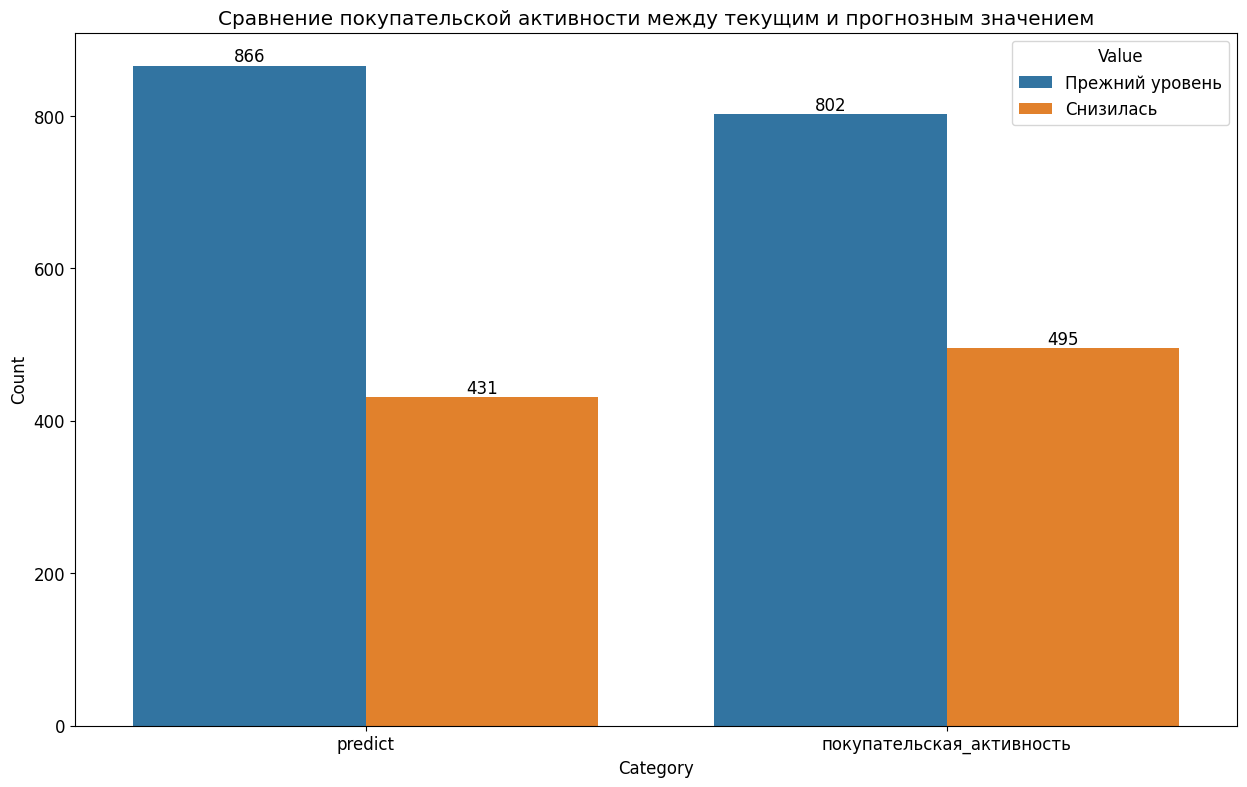

In [114]:
# Группировка данных
grouped_data = (df_pred
                .melt(value_vars=['покупательская_активность', 'predict'], 
                      var_name='Category', 
                      value_name='Value'))
grouped_data = (grouped_data
                .groupby(['Category', 'Value'])
                .size()
                .reset_index(name='Count'))

# Построение графика
ax = sns.barplot(x='Category', y='Count', hue='Value', data=grouped_data)
for container in ax.containers:
        ax.bar_label(container)
plt.title('Сравнение покупательской активности между текущим и прогнозным значением')
plt.show()

Посмотрим на эти данные сегментно. В качестве первого сегмента возьмем группу клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности. 

In [115]:
group_sale = df_pred.query('proba > 0.7 & акционные_покупки > 0.9')
group_sale.head()

покупательская_активность тип_сервиса разрешить_сообщать  \
id                                                                
215351                 Снизилась    стандарт                 да   
215352                 Снизилась    стандарт                нет   
215364                 Снизилась     премиум                 да   
215365                 Снизилась    стандарт                 да   
215374                 Снизилась    стандарт                нет   

        маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
id                                                               
215351                 3.2                     5           896   
215352                 5.1                     3          1064   
215364                 4.3                     4           708   
215365                 3.9                     4           167   
215374                 2.9                     5           268   

        акционные_покупки            популярная_категория  \
id                                                          
215351               0.99                Товары для детей   
215352               0.94                Товары для детей   
215364               0.98               Домашний текстиль   
215365               0.95  Техника для красоты и здоровья   
215374               0.98               Домашний текстиль   

        средний_просмотр_категорий_за_визит  \
id                                            
215351                                    5   
215352                                    3   
215364                                    3   
215365                                    6   
215374                                    6   

        неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
id                                                                             
215351                                   0               6                 4   
215352                                   2               3                 2   
215364                                   3               3                 3   
215365                                   4               2                 5   
215374                                   3               2                 2   

        предыдущий_месяц_время  текущий_месяц_время  предыдущий_месяц_выручка  \
id                                                                              
215351                    11.0                 13.0                    6158.0   
215352                     8.0                 11.0                    5807.5   
215364                    11.0                  9.0                    5795.5   
215365                     6.0                 10.0                    4577.0   
215374                    11.0                  8.0                    5762.5   

        препредыдущий_месяц_выручка  текущий_месяц_выручка    predict  \
id                                                                      
215351                       4793.0                 6610.4  Снизилась   
215352                       4594.0                 5872.5  Снизилась   
215364                       4942.0                 5484.8  Снизилась   
215365                       4190.0                 4799.3  Снизилась   
215374                       4666.0                 5720.9  Снизилась   

           proba  
id                
215351  0.804596  
215352  0.959864  
215364  0.954990  
215365  0.882011  
215374  0.931320

In [116]:
group_sale.describe()

маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
count          104.000000            104.000000     104.00000   
mean             3.693269              4.028846     600.87500   
std              1.028645              0.689121     237.75249   
min              0.900000              3.000000     167.00000   
25%              3.175000              4.000000     442.00000   
50%              3.950000              4.000000     622.50000   
75%              4.325000              4.250000     791.75000   
max              5.700000              5.000000    1064.00000   

       акционные_покупки  средний_просмотр_категорий_за_визит  \
count         104.000000                           104.000000   
mean            0.958173                             2.596154   
std             0.024246                             1.092954   
min             0.930000                             1.000000   
25%             0.940000                             2.000000   
50%             0.945000                             3.000000   
75%             0.982500                             3.000000   
max             0.990000                             6.000000   

       неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
count                          104.000000      104.000000        104.000000   
mean                             3.961538        4.057692          4.798077   
std                              2.468926        1.831901          2.333296   
min                              0.000000        1.000000          1.000000   
25%                              2.000000        3.000000          3.000000   
50%                              4.000000        4.000000          5.000000   
75%                              6.000000        5.000000          6.000000   
max                             10.000000        8.000000         14.000000   

       предыдущий_месяц_время  текущий_месяц_время  предыдущий_месяц_выручка  \
count              104.000000           104.000000                104.000000   
mean                10.326923            10.567308               5010.995192   
std                  2.877574             2.591114                857.914172   
min                  5.000000             5.000000               3061.000000   
25%                  8.000000             9.000000               4440.250000   
50%                 10.000000            10.000000               5202.250000   
75%                 12.000000            12.000000               5661.125000   
max                 19.000000            19.000000               6716.500000   

       препредыдущий_месяц_выручка  текущий_месяц_выручка       proba  
count                   104.000000             104.000000  104.000000  
mean                   4663.115385            5400.102115    0.930347  
std                     244.944230            1024.293659    0.077546  
min                    4119.000000            3232.200000    0.715342  
25%                    4470.750000            4799.300000    0.884017  
50%                    4669.500000            5434.500000    0.966849  
75%                    4809.000000            6085.875000    0.989202  
max                    5532.000000           10686.220000    0.997693

Таких пользователей всего 104, сильной разницы между среднее и медианной не наблюдается, что говорит об отсутствии аномалий.

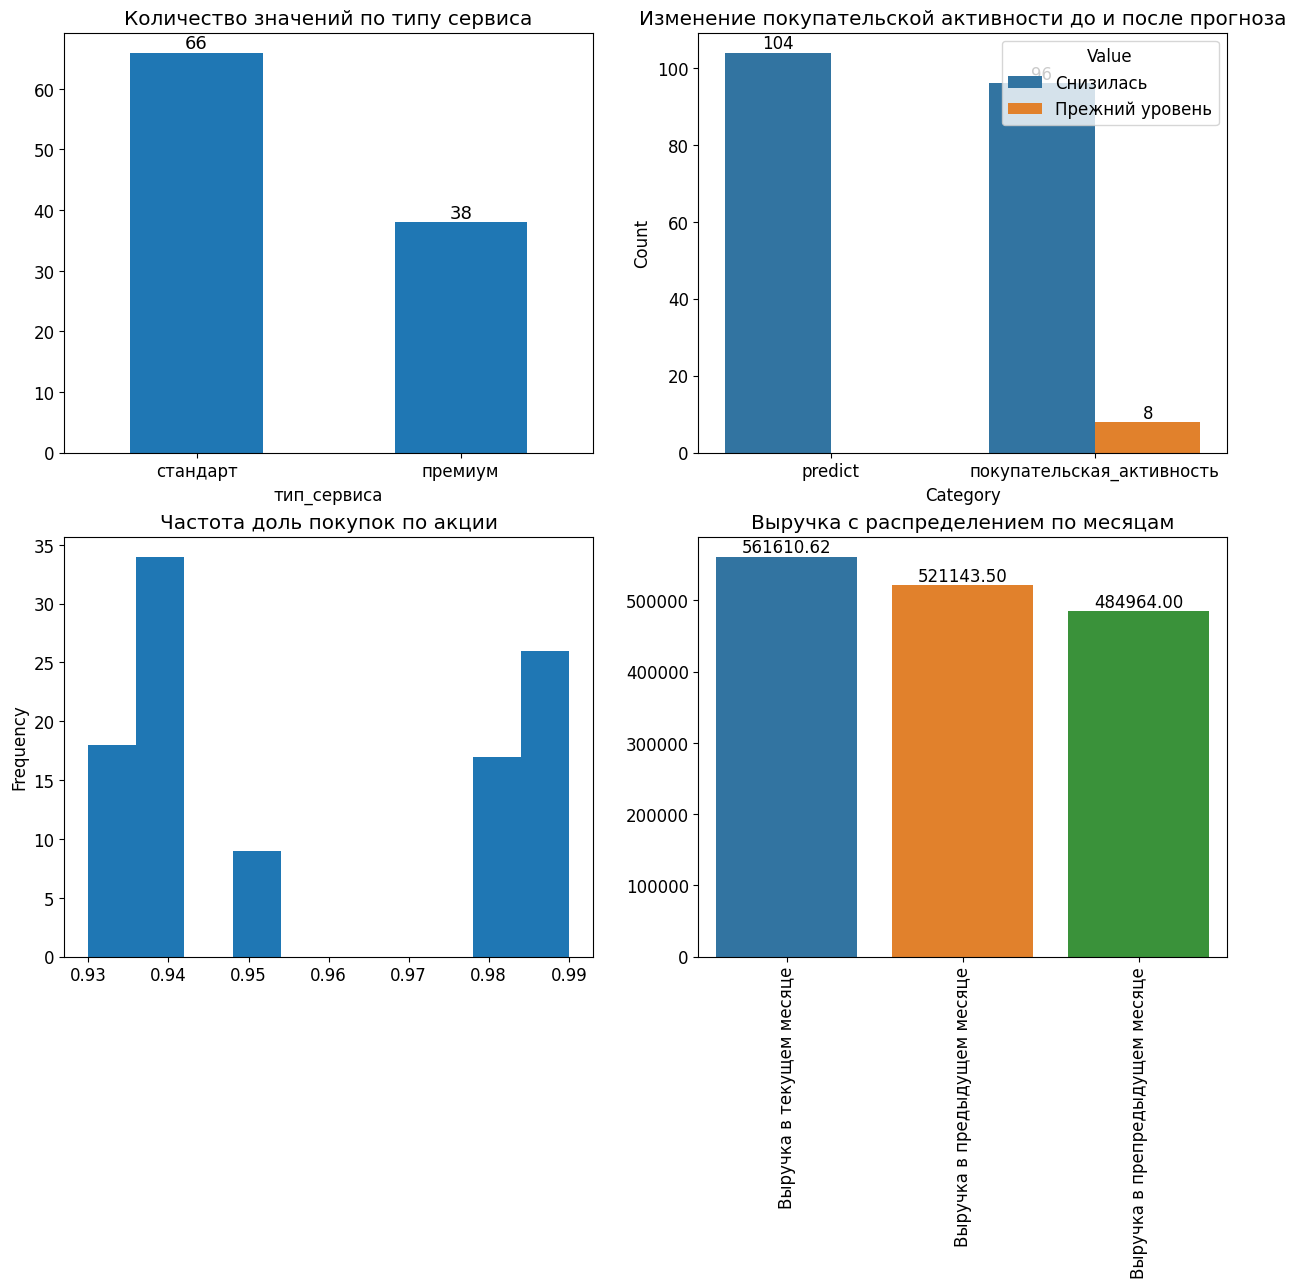

In [117]:
show_analys(group_sale)

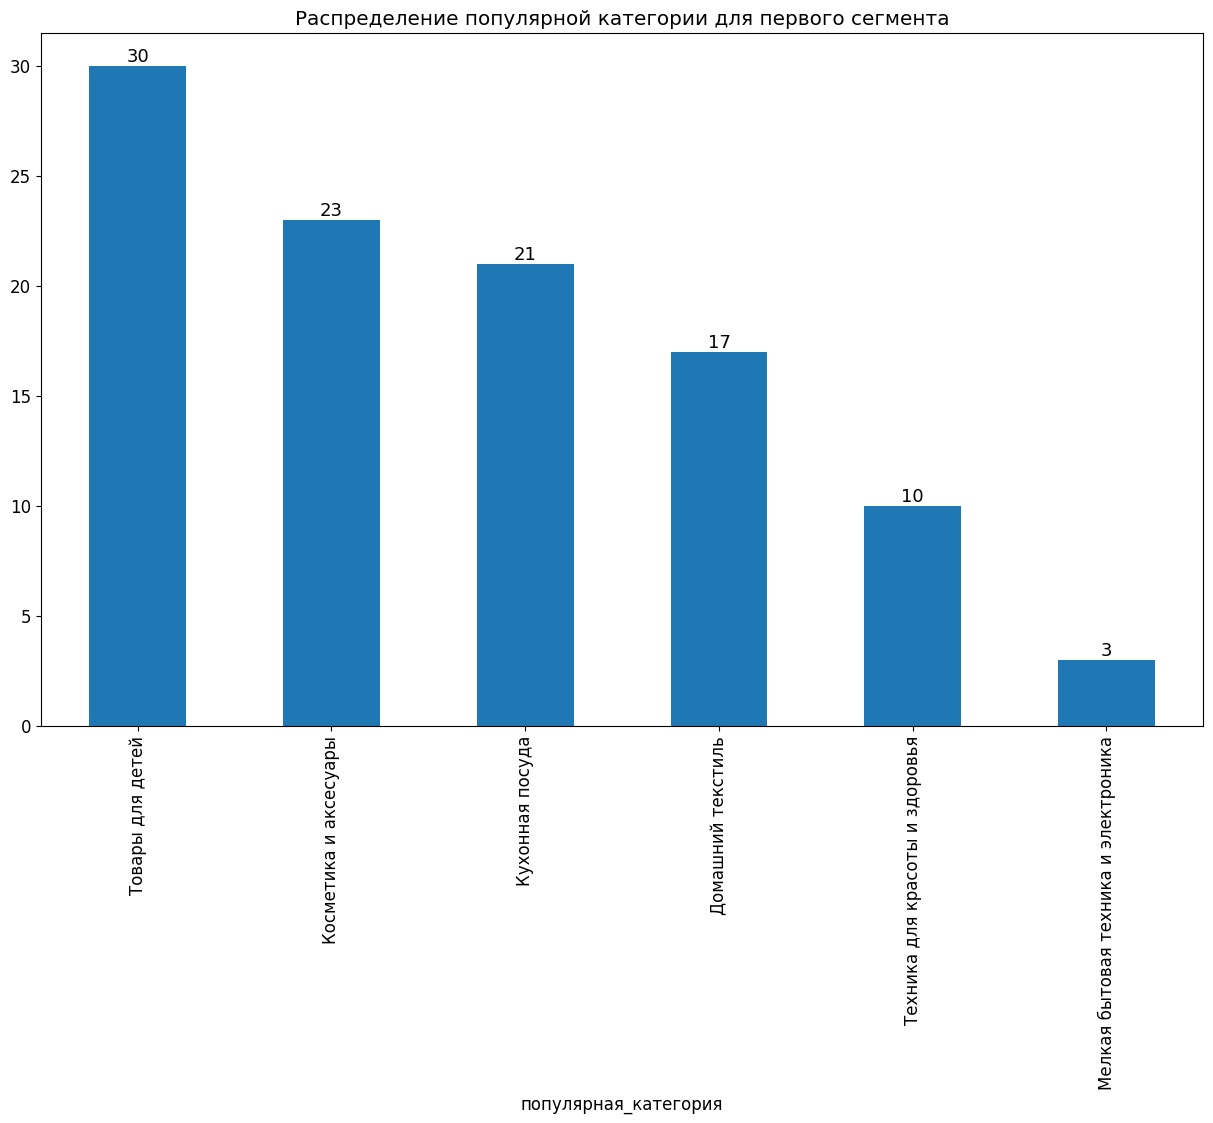

In [118]:
ax = group_sale['популярная_категория'].value_counts().plot(kind='bar')
ax.bar_label(ax.containers[0], fontsize=13);
plt.title('Распределение популярной категории для первого сегмента')
plt.show()

Первый сегмент клиентов состоит из пользователей с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности. 

Количество пользователей имеющих стандартную подписку превышает премиум в 1.8 раз (66 против 38). При этом по прогнозу ожидается что все у кого снизилась покупательская активность вернутся к прежнему уровню. Выручка в данном сегменте растет стабильно с каждым месяцем. 

Наиболее популярная категория "Товары для детей".

В виду того, что пользовательская активность прогнозируется восстановиться до прежнего уровня, а с ростом выручки и так все хорошо, стоит уделить внимание акциям в категориях которые меньше пользуются популярностью *мелкая бытовая техника* и *техника для красоты*.

Вторым сегментом возьмем клиентов, которые покупают только технику, то есть товары с длинным жизненным циклом.

In [119]:
group_tech = (df_pred
              .query('популярная_категория == "Техника для красоты и здоровья" |\
              популярная_категория == "Мелкая бытовая техника и электроника"'))
group_tech.head()

покупательская_активность тип_сервиса разрешить_сообщать  \
id                                                                
215361                 Снизилась    стандарт                 да   
215365                 Снизилась    стандарт                 да   
215368                 Снизилась     премиум                 да   
215378                 Снизилась    стандарт                 да   
215380                 Снизилась     премиум                нет   

        маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
id                                                               
215361                 5.1                     4           199   
215365                 3.9                     4           167   
215368                 3.8                     5           829   
215378                 1.7                     3           488   
215380                 1.7                     4           637   

        акционные_покупки            популярная_категория  \
id                                                          
215361               0.23  Техника для красоты и здоровья   
215365               0.95  Техника для красоты и здоровья   
215368               0.24  Техника для красоты и здоровья   
215378               0.39  Техника для красоты и здоровья   
215380               0.94  Техника для красоты и здоровья   

        средний_просмотр_категорий_за_визит  \
id                                            
215361                                    4   
215365                                    6   
215368                                    2   
215378                                    5   
215380                                    3   

        неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
id                                                                             
215361                                   5               2                 3   
215365                                   4               2                 5   
215368                                   2               6                 1   
215378                                   1               4                 3   
215380                                   2               4                 7   

        предыдущий_месяц_время  текущий_месяц_время  предыдущий_месяц_выручка  \
id                                                                              
215361                    11.0                 13.0                    6400.0   
215365                     6.0                 10.0                    4577.0   
215368                    11.0                  9.0                    5823.0   
215378                    12.0                  8.0                    3543.0   
215380                    12.0                 14.0                    6077.0   

        препредыдущий_месяц_выручка  текущий_месяц_выручка    predict  \
id                                                                      
215361                       4597.0                3789.70  Снизилась   
215365                       4190.0                4799.30  Снизилась   
215368                       4536.0                5591.60  Снизилась   
215378                       4302.0                4364.60  Снизилась   
215380                       5051.0               10686.22  Снизилась   

           proba  
id                
215361  0.576445  
215365  0.882011  
215368  0.841461  
215378  0.650444  
215380  0.851013

In [120]:
group_tech.describe()

маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
count          357.000000            357.000000    357.000000   
mean             4.442017              4.028011    612.420168   
std              0.940580              0.673995    251.551584   
min              0.900000              3.000000    129.000000   
25%              3.900000              4.000000    408.000000   
50%              4.300000              4.000000    626.000000   
75%              5.100000              4.000000    826.000000   
max              6.600000              5.000000   1072.000000   

       акционные_покупки  средний_просмотр_категорий_за_визит  \
count         357.000000                           357.000000   
mean            0.295014                             3.414566   
std             0.237050                             1.324620   
min             0.110000                             1.000000   
25%             0.160000                             2.000000   
50%             0.230000                             3.000000   
75%             0.280000                             4.000000   
max             0.990000                             6.000000   

       неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
count                          357.000000      357.000000        357.000000   
mean                             2.380952        4.294118          8.890756   
std                              1.873972        1.966087          3.662266   
min                              0.000000        0.000000          1.000000   
25%                              1.000000        3.000000          6.000000   
50%                              2.000000        4.000000          9.000000   
75%                              3.000000        6.000000         11.000000   
max                             10.000000        9.000000         19.000000   

       предыдущий_месяц_время  текущий_месяц_время  предыдущий_месяц_выручка  \
count              357.000000           357.000000                357.000000   
mean                14.383754            13.985994               4843.901961   
std                  3.591667             4.186297                737.382746   
min                  5.000000             4.000000               2890.000000   
25%                 12.000000            11.000000               4358.000000   
50%                 14.000000            14.000000               4902.000000   
75%                 17.000000            17.000000               5315.000000   
max                 23.000000            22.000000               6588.500000   

       препредыдущий_месяц_выручка  текущий_месяц_выручка       proba  
count                   357.000000             357.000000  357.000000  
mean                   4861.394958            5148.286331    0.225168  
std                     321.558526             887.796748    0.280108  
min                    4165.000000            2758.700000    0.002690  
25%                    4611.000000            4599.800000    0.041123  
50%                    4852.000000            5062.300000    0.094205  
75%                    5092.000000            5624.600000    0.284806  
max                    5663.000000           10686.220000    0.991896

Таких объектов 357, сильной разницы между среднее и медианной не наблюдается, что говорит об отсутствии аномалий.

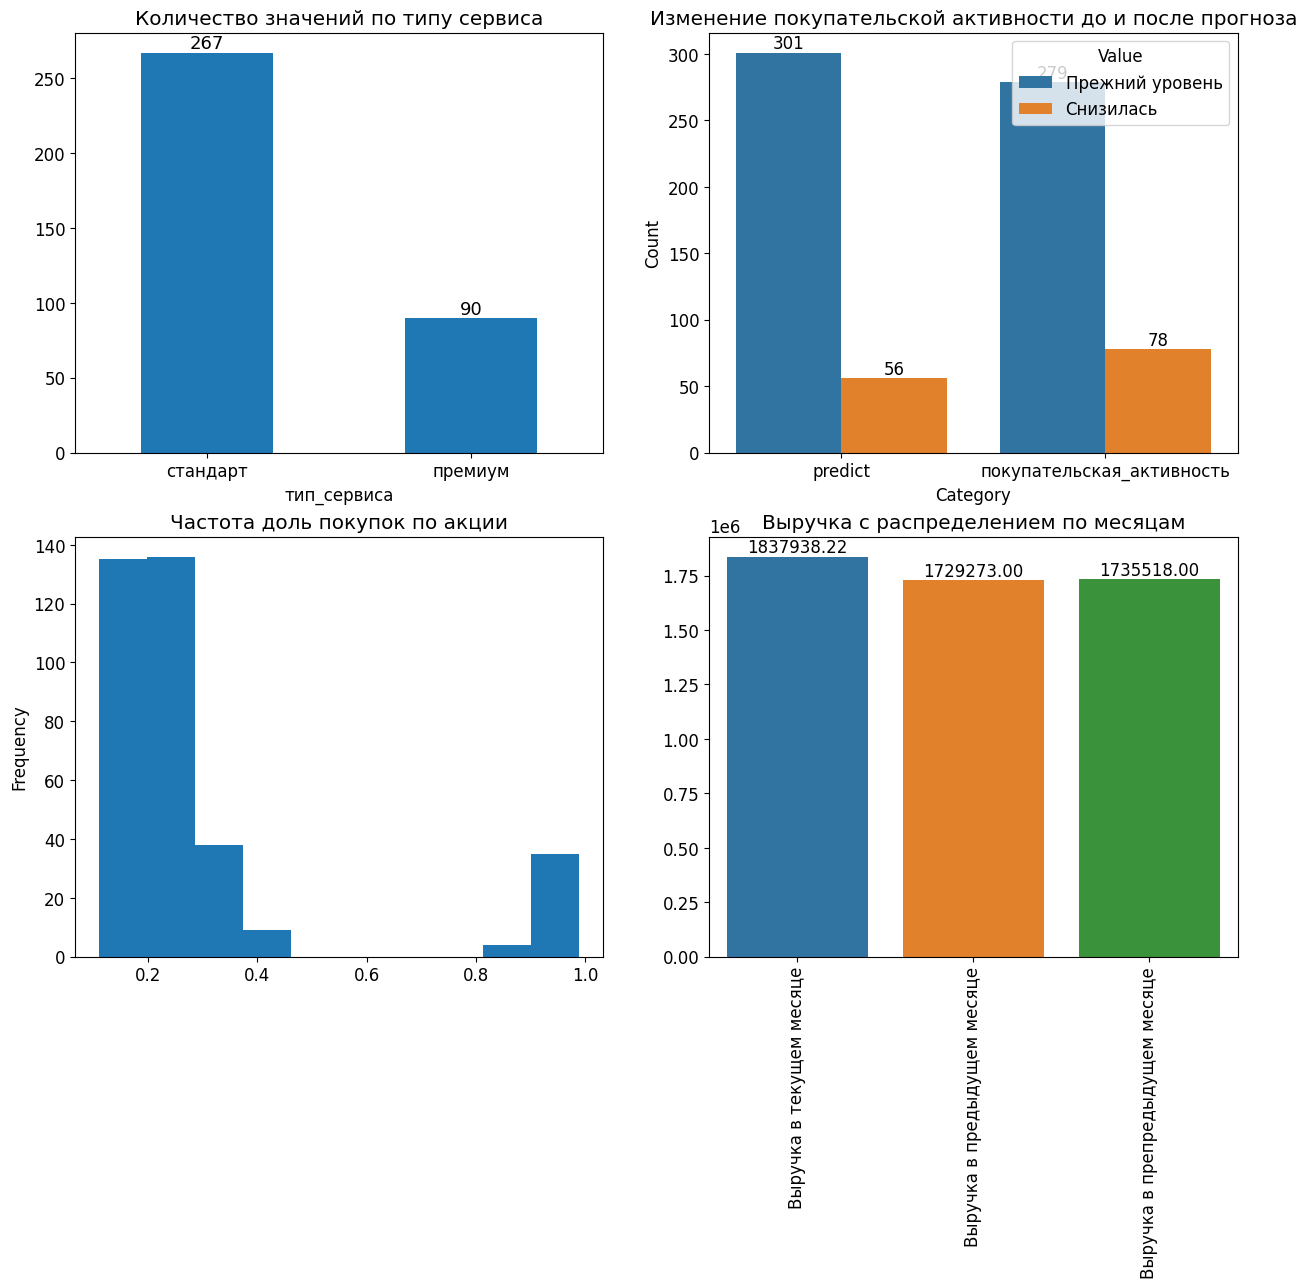

In [121]:
show_analys(group_tech)

Второй сегмент состоит из пользователей, которые покупают только технику, то есть товары с длинным жизненным циклом.

Тут количество пользователей имеющих стандартную подписку превышает премиум в 3 раза (267 против 90). При этом по прогнозу ожидается небольшое увеличение пользовательской активности (плюс 22 от текущего уровня "снизилась"). Доля покупок по акции составляет в среднем 0.2-0.3, что говорит о том, что данный сегмент довольно редко покупает по акциям. 
Стоит отметить сильное увеличение выручки в текущем месяце (1 837 938 руб.), что больше чем на 100 тысяч чем в предыдущем и препредыдущем месяце.

В качестве рекомендаций, стоит сделать упор на покупку премиум подписки, так как разница с обычной довольно существенна. Возможно имеет смысл сделать бесплатный пробный период или выгодную годовую подписку. 

Далее изучим категорию клиентов, которые покупают товары из категории "Товары для себя" или "Товары для детей".

In [122]:
group_third = (df_pred
               .query('популярная_категория == "Косметика и аксесуары" |\
               популярная_категория == "Товары для детей"'))
group_third.head()

покупательская_активность тип_сервиса разрешить_сообщать  \
id                                                                
215349                 Снизилась     премиум                 да   
215351                 Снизилась    стандарт                 да   
215352                 Снизилась    стандарт                нет   
215354                 Снизилась    стандарт                 да   
215355                 Снизилась    стандарт                нет   

        маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
id                                                               
215349                 4.4                     4           819   
215351                 3.2                     5           896   
215352                 5.1                     3          1064   
215354                 5.1                     3           431   
215355                 4.7                     4           284   

        акционные_покупки   популярная_категория  \
id                                                 
215349               0.75       Товары для детей   
215351               0.99       Товары для детей   
215352               0.94       Товары для детей   
215354               0.23  Косметика и аксесуары   
215355               0.17       Товары для детей   

        средний_просмотр_категорий_за_визит  \
id                                            
215349                                    4   
215351                                    5   
215352                                    3   
215354                                    2   
215355                                    5   

        неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
id                                                                             
215349                                   4               2                 5   
215351                                   0               6                 4   
215352                                   2               3                 2   
215354                                   3               7                 2   
215355                                   1               6                 4   

        предыдущий_месяц_время  текущий_месяц_время  предыдущий_месяц_выручка  \
id                                                                              
215349                    12.0                 10.0                    5216.0   
215351                    11.0                 13.0                    6158.0   
215352                     8.0                 11.0                    5807.5   
215354                    11.0                 12.0                    5685.0   
215355                    12.0                 10.0                    3263.0   

        препредыдущий_месяц_выручка  текущий_месяц_выручка          predict  \
id                                                                            
215349                       4472.0                 4971.6        Снизилась   
215351                       4793.0                 6610.4        Снизилась   
215352                       4594.0                 5872.5        Снизилась   
215354                       4503.0                 5869.6        Снизилась   
215355                       4749.0                 3772.6  Прежний уровень   

           proba  
id                
215349  0.875575  
215351  0.804596  
215352  0.959864  
215354  0.795350  
215355  0.177896

In [123]:
group_third.describe()

маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
count          552.000000            552.000000    552.000000   
mean             4.195652              4.028986    597.181159   
std              1.023809              0.707153    243.139291   
min              0.900000              3.000000    121.000000   
25%              3.600000              4.000000    419.750000   
50%              4.100000              4.000000    599.500000   
75%              4.900000              5.000000    788.250000   
max              6.600000              5.000000   1079.000000   

       акционные_покупки  средний_просмотр_категорий_за_визит  \
count         552.000000                           552.000000   
mean            0.335725                             3.141304   
std             0.255203                             1.326115   
min             0.110000                             1.000000   
25%             0.180000                             2.000000   
50%             0.250000                             3.000000   
75%             0.320000                             4.000000   
max             0.990000                             6.000000   

       неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
count                          552.000000      552.000000        552.000000   
mean                             2.860507        4.065217          7.748188   
std                              1.954222        1.917373          3.982265   
min                              0.000000        0.000000          1.000000   
25%                              1.000000        3.000000          5.000000   
50%                              3.000000        4.000000          7.000000   
75%                              4.000000        5.000000         11.000000   
max                              9.000000        9.000000         20.000000   

       предыдущий_месяц_время  текущий_месяц_время  предыдущий_месяц_выручка  \
count              552.000000           552.000000                552.000000   
mean                12.724638            12.960145               4884.719203   
std                  4.042457             4.261234                716.682806   
min                  5.000000             4.000000               2909.000000   
25%                 10.000000            10.000000               4438.750000   
50%                 12.000000            12.000000               4986.500000   
75%                 16.000000            16.000000               5371.625000   
max                 23.000000            23.000000               6869.500000   

       препредыдущий_месяц_выручка  текущий_месяц_выручка       proba  
count                   552.000000             552.000000  552.000000  
mean                   4819.266304            5168.837500    0.454525  
std                     332.418078             786.010701    0.365662  
min                    4098.000000            2952.200000    0.006396  
25%                    4563.500000            4682.575000    0.106852  
50%                    4779.000000            5130.700000    0.327427  
75%                    5042.000000            5606.400000    0.868723  
max                    5633.000000            7605.300000    0.999033

Таких объектов 552, сильной разницы между среднее и медианной не наблюдается, что говорит об отсутствии аномалий.

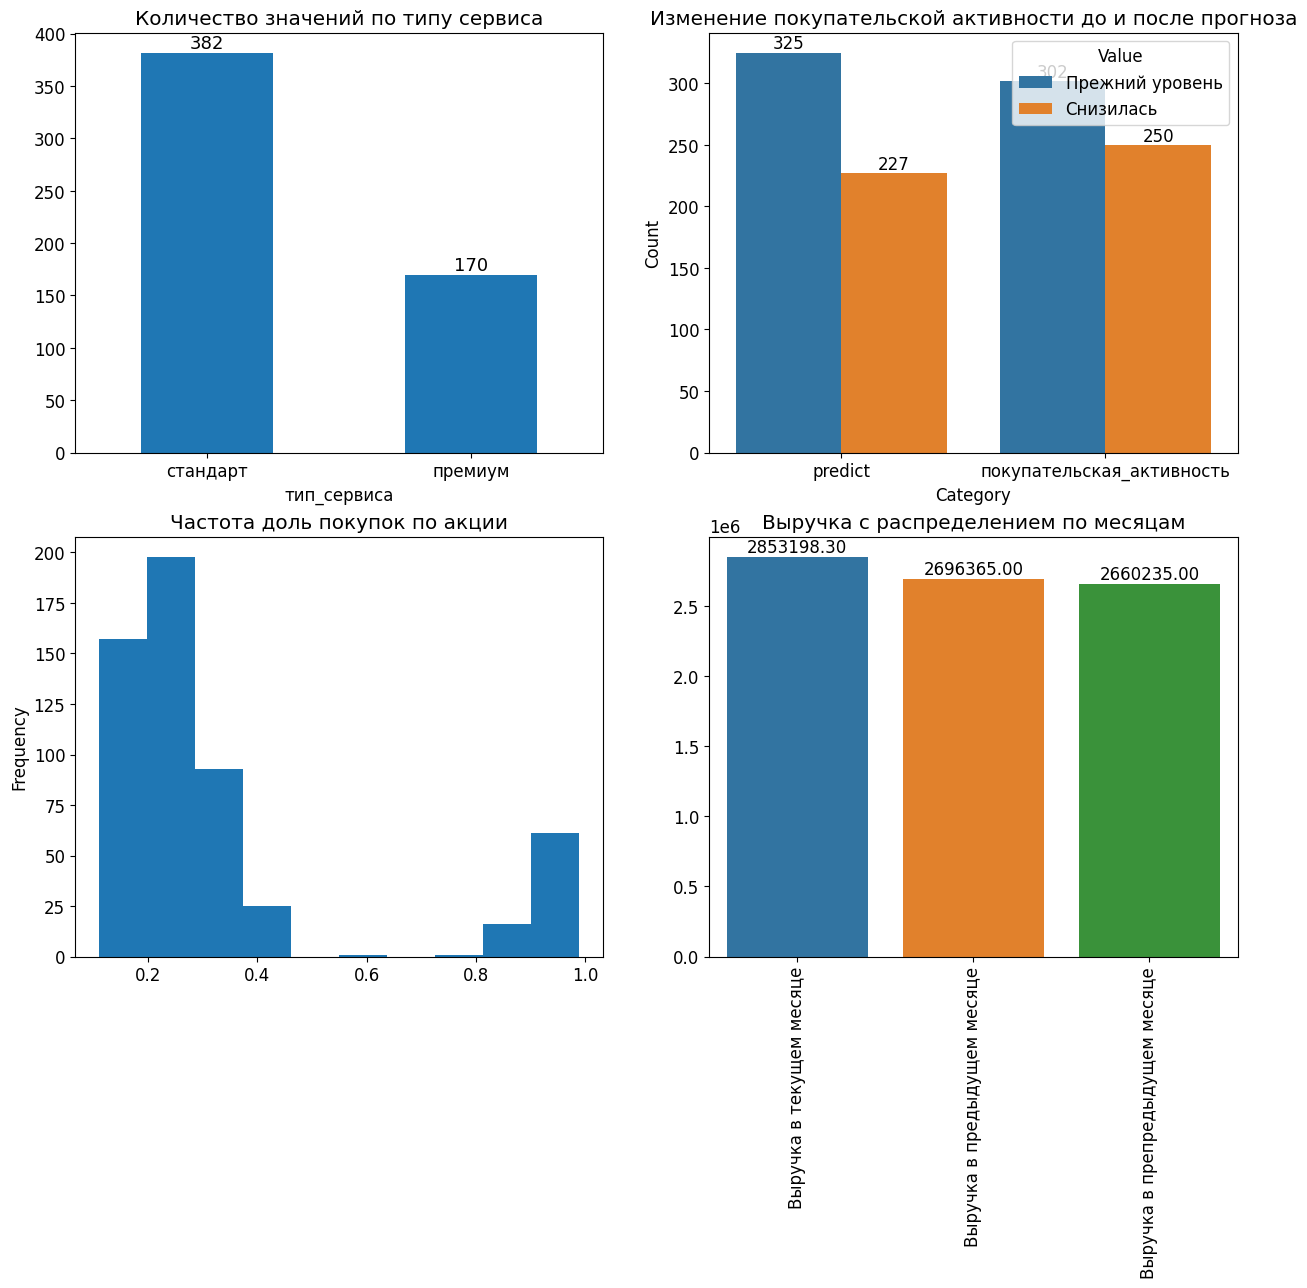

In [124]:
show_analys(group_third)

Третий сегмент состоит из пользователей, которые покупают товары из категории "Товары для себя" или "Товары для детей".

Тут количество пользователей имеющих стандартную подписку менее всех остальных групп превышает премиум, в 2.2 раза (382 против 170). При этом по прогнозу также ожидается небольшое увеличение пользовательской активности (плюс 23 от текущего уровня "снизилась"). Доля покупок по акции составляет в среднем 0.2-0.4, что говорит о том, что данный сегмент довольно редко покупает по акциям, но стоит отметить второй пик у 1, что говорит о том, что часть пользователей покупает товары только по акции. 
Тут наблюдается увеличение выручки, при чем постепенное от месяца к месяцу со скачком в + 150 тыс. руб. в текущем.

В качестве рекомендаций, стоит уделить внимание большому количеству пользователей у которых прогнозируется снижение пользовательской активности. Так как акции не особо интересуют данный сегмент, возможно нужно обратить внимание на количество и качество представленного товара, расширить ассортимент.

Далее рассмотрим группу клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью. Для этого добавим в наш датафрейм `df_money` с данными о прибыльности

In [125]:
df_pred = df_pred.merge(df_money, on='id', how='left')
df_pred.shape

(1297, 21)

In [126]:
df_pred.head()

id покупательская_активность тип_сервиса разрешить_сообщать  \
0  215349                 Снизилась     премиум                 да   
1  215350                 Снизилась    стандарт                нет   
2  215351                 Снизилась    стандарт                 да   
3  215352                 Снизилась    стандарт                нет   
4  215353                 Снизилась    стандарт                 да   

   маркет_актив_6_мес  маркет_актив_тек_мес  длительность  акционные_покупки  \
0                 4.4                     4           819               0.75   
1                 4.9                     3           539               0.14   
2                 3.2                     5           896               0.99   
3                 5.1                     3          1064               0.94   
4                 3.3                     4           762               0.26   

  популярная_категория  средний_просмотр_категорий_за_визит  ...  \
0     Товары для детей                                    4  ...   
1    Домашний текстиль                                    5  ...   
2     Товары для детей                                    5  ...   
3     Товары для детей                                    3  ...   
4    Домашний текстиль                                    4  ...   

   ошибка_сервиса  страниц_за_визит  предыдущий_месяц_время  \
0               2                 5                    12.0   
1               1                 5                     8.0   
2               6                 4                    11.0   
3               3                 2                     8.0   
4               1                 4                    10.0   

   текущий_месяц_время  предыдущий_месяц_выручка  препредыдущий_месяц_выручка  \
0                 10.0                    5216.0                       4472.0   
1                 13.0                    5457.5                       4826.0   
2                 13.0                    6158.0                       4793.0   
3                 11.0                    5807.5                       4594.0   
4                 10.0                    4738.5                       5124.0   

   текущий_месяц_выручка          predict     proba  прибыль  
0                 4971.6        Снизилась  0.875575     4.16  
1                 5058.4  Прежний уровень  0.323936     3.13  
2                 6610.4        Снизилась  0.804596     4.87  
3                 5872.5        Снизилась  0.959864     4.21  
4                 5388.5        Снизилась  0.596385     3.95  

[5 rows x 21 columns]

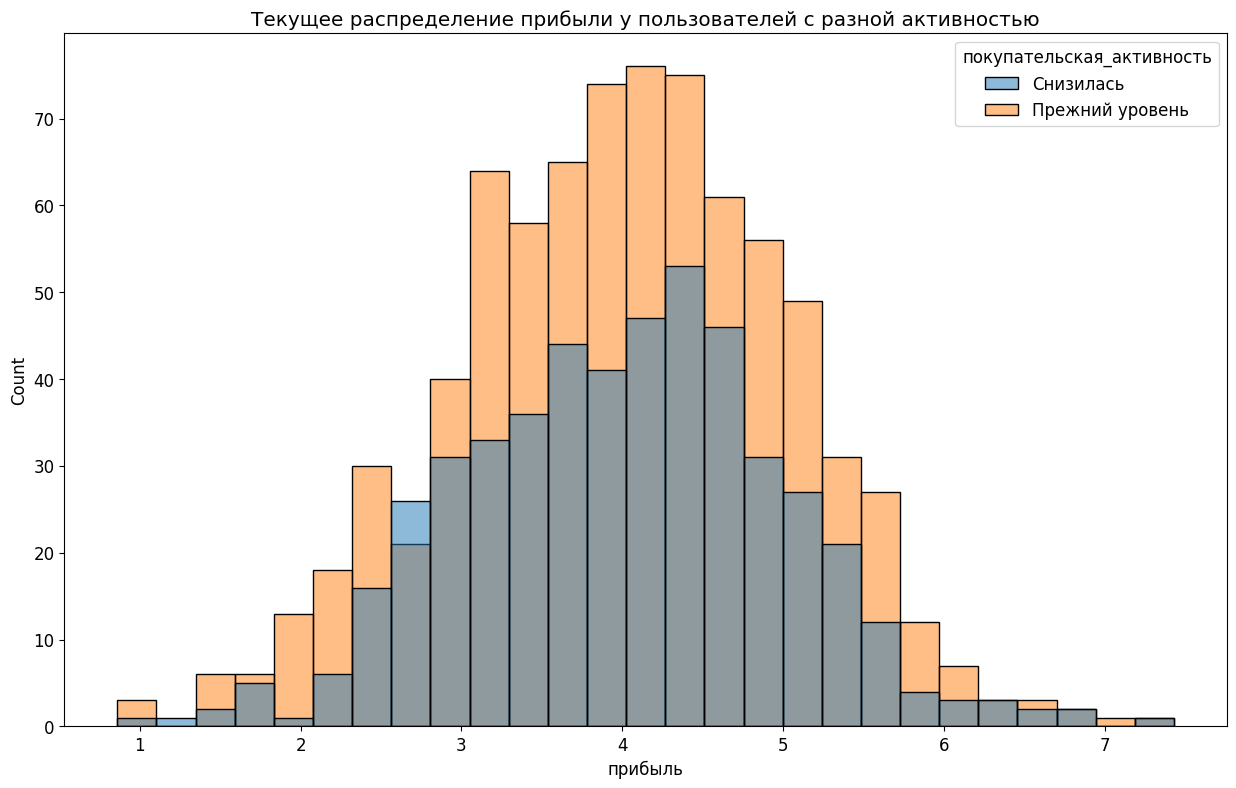

In [127]:
sns.histplot(data=df_pred, hue='покупательская_активность', x='прибыль')
plt.title('Текущее распределение прибыли у пользователей с разной активностью')
plt.show()

In [128]:
group_fourth = df_pred.query('proba > 0.7 & прибыль > 5')
group_fourth.head()

id покупательская_активность тип_сервиса разрешить_сообщать  \
17  215368                 Снизилась     премиум                 да   
37  215388                 Снизилась    стандарт                 да   
40  215391                 Снизилась     премиум                 да   
45  215396                 Снизилась    стандарт                 да   
49  215400                 Снизилась    стандарт                нет   

    маркет_актив_6_мес  маркет_актив_тек_мес  длительность  акционные_покупки  \
17                 3.8                     5           829               0.24   
37                 3.5                     4           663               0.99   
40                 3.5                     3           754               0.30   
45                 3.4                     5           706               0.22   
49                 4.4                     5           304               0.94   

              популярная_категория  средний_просмотр_категорий_за_визит  ...  \
17  Техника для красоты и здоровья                                    2  ...   
37               Домашний текстиль                                    4  ...   
40           Косметика и аксесуары                                    3  ...   
45               Домашний текстиль                                    2  ...   
49                Товары для детей                                    1  ...   

    ошибка_сервиса  страниц_за_визит  предыдущий_месяц_время  \
17               6                 1                    11.0   
37               2                 2                    10.0   
40               2                 1                    10.0   
45               8                 4                    12.0   
49               3                 2                    11.0   

    текущий_месяц_время  предыдущий_месяц_выручка  \
17                  9.0                    5823.0   
37                 12.0                    3188.0   
40                 11.0                    5928.5   
45                  6.0                    5876.0   
49                  9.0                    5681.0   

    препредыдущий_месяц_выручка  текущий_месяц_выручка    predict     proba  \
17                       4536.0                 5591.6  Снизилась  0.841461   
37                       4182.0                 3232.2  Снизилась  0.948419   
40                       4556.0                 5824.5  Снизилась  0.842390   
45                       4805.0                 6830.2  Снизилась  0.890874   
49                       4439.0                 5691.4  Снизилась  0.989549   

    прибыль  
17     6.27  
37     5.16  
40     5.44  
45     5.09  
49     6.73  

[5 rows x 21 columns]

In [129]:
group_fourth.describe()

id  маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
count      52.000000           52.000000             52.000000     52.000000   
mean   215654.557692            3.651923              4.076923    583.403846   
std       266.029957            1.086908              0.709768    240.663402   
min    215368.000000            0.900000              3.000000    163.000000   
25%    215491.750000            2.975000              4.000000    346.500000   
50%    215607.500000            3.850000              4.000000    664.500000   
75%    215705.500000            4.250000              5.000000    788.250000   
max    216564.000000            5.600000              5.000000    956.000000   

       акционные_покупки  средний_просмотр_категорий_за_визит  \
count          52.000000                            52.000000   
mean            0.495769                             2.096154   
std             0.311299                             0.891344   
min             0.120000                             1.000000   
25%             0.270000                             1.000000   
50%             0.350000                             2.000000   
75%             0.932500                             3.000000   
max             0.990000                             4.000000   

       неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
count                           52.000000       52.000000         52.000000   
mean                             3.942308        3.846154          4.307692   
std                              2.145798        1.637605          2.091425   
min                              0.000000        1.000000          1.000000   
25%                              2.000000        3.000000          3.000000   
50%                              4.000000        4.000000          4.000000   
75%                              5.250000        5.000000          6.000000   
max                              9.000000        8.000000          9.000000   

       предыдущий_месяц_время  текущий_месяц_время  предыдущий_месяц_выручка  \
count               52.000000            52.000000                 52.000000   
mean                10.019231            10.019231               4960.894231   
std                  2.380397             2.667821                742.982697   
min                  5.000000             5.000000               3188.000000   
25%                  9.000000             8.000000               4450.250000   
50%                 10.000000            10.000000               5055.000000   
75%                 11.000000            12.000000               5599.375000   
max                 17.000000            19.000000               6227.000000   

       препредыдущий_месяц_выручка  текущий_месяц_выручка      proba  \
count                    52.000000              52.000000  52.000000   
mean                   4590.500000            5309.944231   0.897040   
std                     286.566182             839.737411   0.079148   
min                    4119.000000            3232.200000   0.725000   
25%                    4347.750000            4749.775000   0.842158   
50%                    4553.000000            5460.300000   0.908660   
75%                    4802.750000            5864.750000   0.965473   
max                    5269.000000            6957.700000   0.997693   

         прибыль  
count  52.000000  
mean    5.495000  
std     0.540503  
min     5.010000  
25%     5.115000  
50%     5.320000  
75%     5.640000  
max     7.430000

Таких объектов 52, сильной разницы между среднее и медианной не наблюдается, что говорит об отсутствии аномалий.

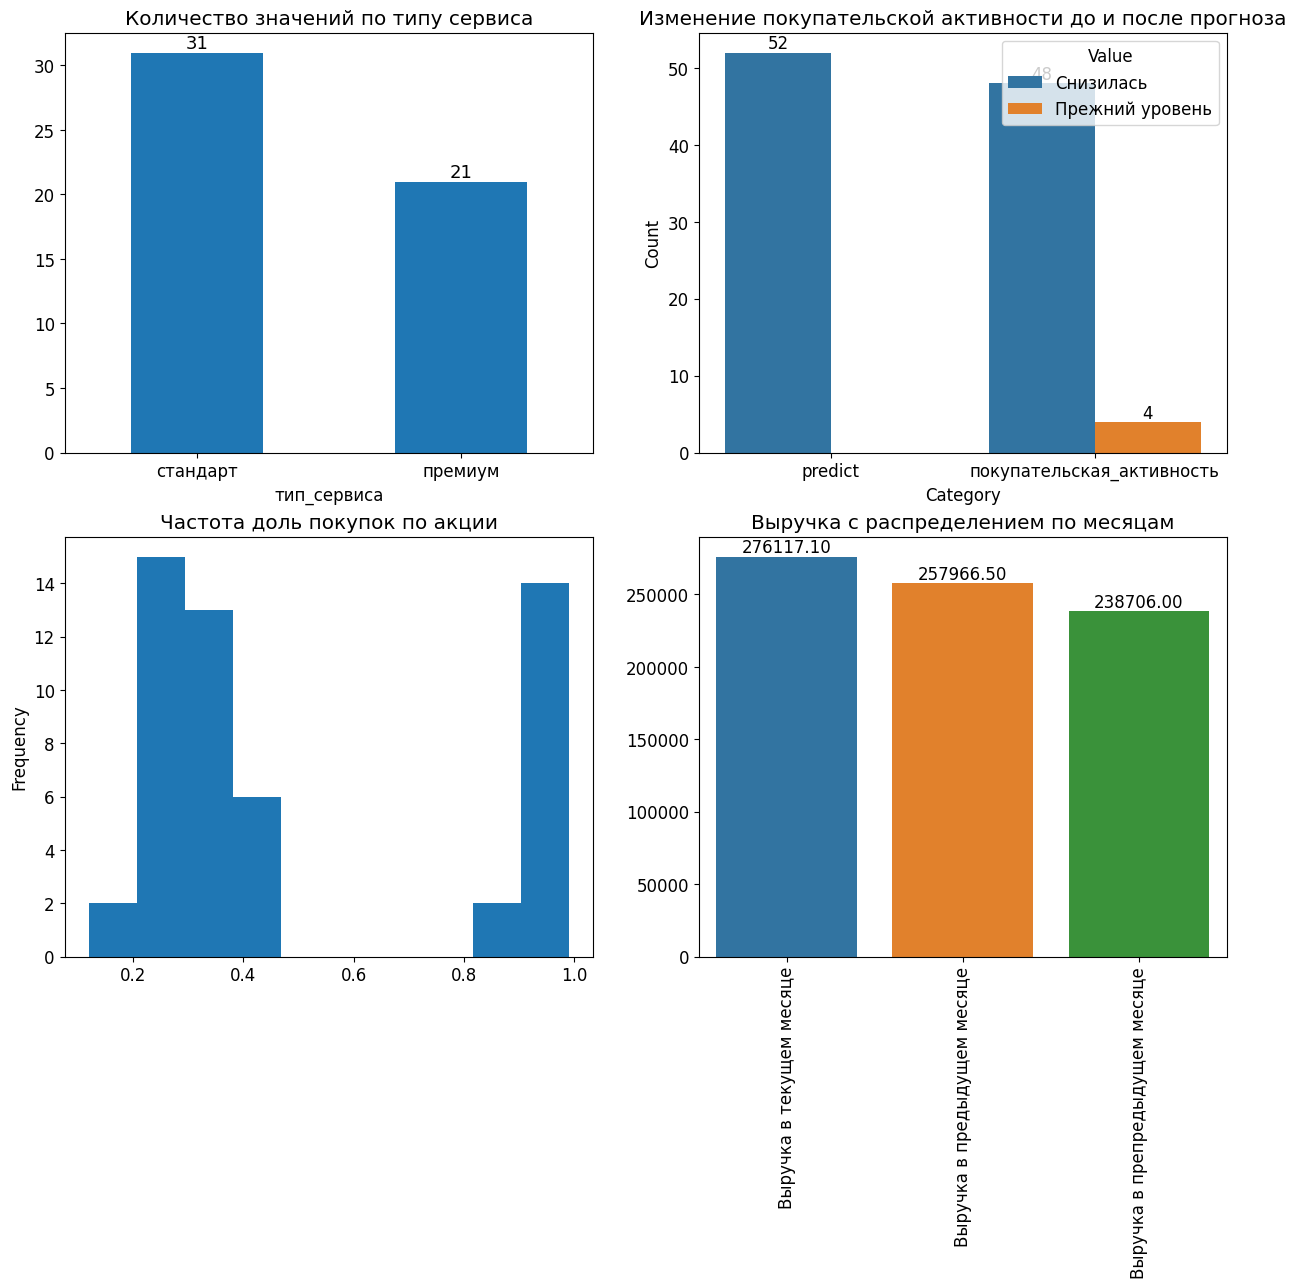

In [130]:
show_analys(group_fourth)

In [131]:
gg = (group_fourth
      .groupby('популярная_категория')
      .agg(текущая_выручка=('текущий_месяц_выручка', 'sum'), 
           предыдущая_выручка=('предыдущий_месяц_выручка', 'sum'),
           препредыдущая_выручка=('препредыдущий_месяц_выручка', 'sum')))
gg.head()

текущая_выручка  предыдущая_выручка  \
популярная_категория                                                        
Домашний текстиль                             36235.6             33022.0   
Косметика и аксесуары                         84026.6             77758.0   
Кухонная посуда                               44525.0             41548.0   
Мелкая бытовая техника и электроника          10571.8             10427.5   
Техника для красоты и здоровья                26339.6             24972.0   

                                      препредыдущая_выручка  
популярная_категория                                         
Домашний текстиль                                   32420.0  
Косметика и аксесуары                               67415.0  
Кухонная посуда                                     37335.0  
Мелкая бытовая техника и электроника                 9490.0  
Техника для красоты и здоровья                      27206.0

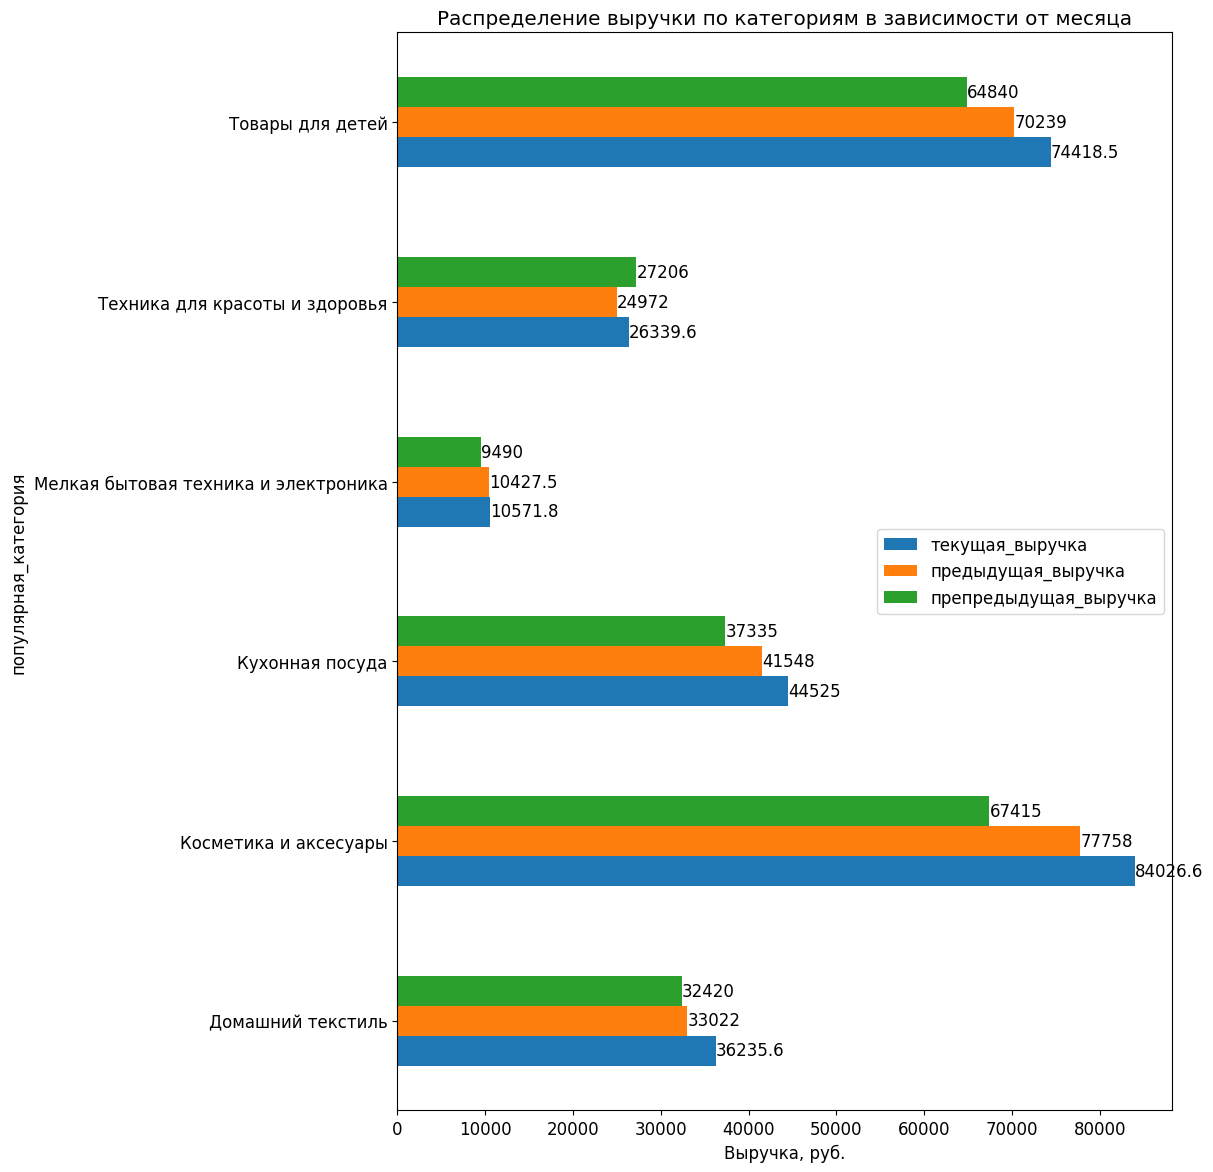

In [132]:
ax = gg.plot(kind='barh', figsize=(10,14))
plt.legend(loc='center right')
for container in ax.containers:
        ax.bar_label(container)
plt.xlabel('Выручка, руб.')
plt.title('Распределение выручки по категориям в зависимости от месяца')
plt.show()

Четвертый сегмент состоит из пользователей с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью.

В виду высокой прибыльности данного сегмента, тут наблюдается наименьшая разница в соотношении типа подписок (в 1.4 раза стандартная превышает премиум). Кроме того, прогнозируется что все пользователи со сниженным уровнем активности вернутся к прежнему. Несмотря на состоятельность сегмента, есть пользователи с максимальной долей покупок по акцям. При этом выручка растет стабильно в каждом месяце. Наибольшую выручку приносит категория "косметика и аксессуары", эта же категория имеет сильнейший рост от месяца к месяцу.

Возможно для данного состоятельно сегмента стоит поработать с ассортиментом, добавить премиум линейку товаров. Также не стоит забывать про высокую долю покупок по акции, периодически рассылать интересные маркенговые предложения, особенно для самой популярной категории "косметика". Также стоит обратить внимание на категорию "техника для красоты", так как это единственная где падала выручка в прошлом месяца. С учетом того популярности "косметики" и близкой к ней "техника для красоты", стоит рассмотреть совместный акционный набор, например, при покупке фена шампунь в подарок.


<a id='report_segment'></a>
## Предварительный вывод


Первый сегмент клиентов состоит из пользователей с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности. 

Количество пользователей имеющих стандартную подписку превышает премиум в 1.8 раз (66 против 38). При этом по прогнозу ожидается что все у кого снизилась покупательская активность вернутся к прежнему уровню. Выручка в данном сегменте растет стабильно с каждым месяцем. 

Наиболее популярная категория "Товары для детей".

В виду того, что пользовательская активность прогнозируется восстановиться до прежнего уровня, а с ростом выручки и так все хорошо, стоит уделить внимание акциям в категориях которые меньше пользуются популярностью *мелкая бытовая техника* и *техника для красоты*.


Второй сегмент состоит из пользователей, которые покупают только технику, то есть товары с длинным жизненным циклом.

Тут количество пользователей имеющих стандартную подписку превышает премиум в 3 раза (267 против 90). При этом по прогнозу ожидается небольшое увеличение пользовательской активности (плюс 22 от текущего уровня "снизилась"). Доля покупок по акции составляет в среднем 0.2-0.3, что говорит о том, что данный сегмент довольно редко покупает по акциям. 
Стоит отметить сильное увеличение выручки в текущем месяце (1 837 938 руб.), что больше чем на 100 тысяч чем в предыдущем и препредыдущем месяце.

В качестве рекомендаций, стоит сделать упор на покупку премиум подписки, так как разница с обычной довольно существенна. Возможно имеет смысл сделать бесплатный пробный период или выгодную годовую подписку. 


Третий сегмент состоит из пользователей, которые покупают товары из категории "Товары для себя" или "Товары для детей".

Тут количество пользователей имеющих стандартную подписку менее всех остальных групп превышает премиум, в 2.2 раза (382 против 170). При этом по прогнозу также ожидается небольшое увеличение пользовательской активности (плюс 23 от текущего уровня "снизилась"). Доля покупок по акции составляет в среднем 0.2-0.4, что говорит о том, что данный сегмент довольно редко покупает по акциям, но стоит отметить второй пик у 1, что говорит о том, что часть пользователей покупает товары только по акции. 
Тут наблюдается увеличение выручки, при чем постепенное от месяца к месяцу со скачком в + 150 тыс. руб. в текущем.

В качестве рекомендаций, стоит уделить внимание большому количеству пользователей у которых прогнозируется снижение пользовательской активности. Так как акции не особо интересуют данный сегмент, возможно нужно обратить внимание на количество и качество представленного товара, расширить ассортимент.


Четвертый сегмент состоит из пользователей с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью.

В виду высокой прибыльности данного сегмента, тут наблюдается наименьшая разница в соотношении типа подписок (в 1.4 раза стандартная превышает премиум). Кроме того, прогнозируется что все пользователи со сниженным уровнем активности вернутся к прежнему. Несмотря на состоятельность сегмента, есть пользователи с максимальной долей покупок по акцям. При этом выручка растет стабильно в каждом месяце. Наибольшую выручку приносит категория "косметика и аксессуары", эта же категория имеет сильнейший рост от месяца к месяцу.

Возможно для данного состоятельно сегмента стоит поработать с ассортиментом, добавить премиум линейку товаров. Также не стоит забывать про высокую долю покупок по акции, периодически рассылать интересные маркенговые предложения, особенно для самой популярной категории "косметика". Также стоит обратить внимание на категорию "техника для красоты", так как это единственная где падала выручка в прошлом месяца. С учетом того популярности "косметики" и близкой к ней "техника для красоты", стоит рассмотреть совместный акционный набор, например, при покупке фена шампунь в подарок.

<a id='total_review'></a>
## Общий вывод

В рамках данного проекта мы обучили модели и спрогнозировали с помощью нее средний удой и вкус молока, что поможет фермерам при покупке коров. 

В качестве **_первого этапа_** мы загрузили предоставленные датафреймы и получили общую информацию по ним. К датафрейму `df_money` мы сразу применили `dec` для корректной загрузки чисел с плавающей точкой. Определили общий признак `id` с помощью которого в дальнейшем объединяли датафреймы. Отметили что все признаки содержат одинаковое количество объектов и отсутствуют пустые строки. Обратили внимание какие типы данных используются в датафреймах. 

На этапе **_предобработки данных_**, мы привели к единому названию все признаки во всех датафреймах. Исправили неявные дубликаты в `df` и `df_time`. Основной датафрейм `df` после предобработки данных содержал 1300 объектов и 13 признаков.

Следующим этапом мы провели **_исследовательский анализ_** в ходе которых отметили несколько интересных моментов. `Покупательская активность` остается на прежнем уровне в **61%** случаях, при этом подавляющее количество пользователей **(более 70%)** не используют подписку *Премиум*. Наибольшим спросом пользуется категория *Товары для детей* (**330** против **251** у следующей категории *Домашний текстиль*. Среднемесячное значение маркетинговых коммуникаций с покупателем за последние полгода, сконцентрировано в районе **4 раз** с выраженным пиком у этого значения. Что подтверждает и количество маркетинговых коммуникаций в текущем месяце, где также пик сконцентрирован в районе **4 раз**. Также в признаке `маркетинговой активности за последние полгода` есть небольшие выбросы в районе **1-2 раз**, возможно это связано с негативной реакцией клиента на подобную рекламу и после чего она прекратилась. Признак `длительность` имеет равномерное распределение со средним около **600 дней** с момента регистрации на сайте. Это говорит о том, что пользователи довольно давно пользуются сайтом и остаются лояльны со вренем. Признак `акционные покупки` имеет два пика, основной расположен у **0.25**, который говорит что только четверть товаров приобретается клиентом по акции, но также есть и близкие к **1**, то есть есть часть клиентов которые покупают только по акции. В признаке `неоплаченные товары`, есть нормальное скопление вокруг до 5 товаров, однако есть и более 8 неоплаченных товаров.  Признак `страниц за визит` имеет два ярковыраженных пика в районе 5 и 10.

Количество пользователей которые почти *все товары покупают по акции* - 138 

Количество пользователей которые *мало товаров покупают по акции* - 683

Количество покупателей у которых много *неоплаченных товаров* всего 14. Между ними нет никакой закономерности, тут есть как пользователи с подпиской, так и без. Все пользователи зарегистрированы не меньше года, то есть давно. Возможно отказ от покупки связано с ошибкой сервиса возникшей в тот момент и покупатель просто не стал ждать пока починят.

Большинство пользователей *разрешает отправлять сообщения*, скорее всего с целью чтобы не пропустить какую-либо хорошую акцию. Чаще всего отправляют **4 маркетинговых акции в месяц, то есть раз в неделю.** Стоит отметить что отсутствие подписки не влияет на покупательскую активность.

Можно сказать, что для пользователей **без премиум подписки** идет больше маркетинговая коммуникация за последние полгода, возможно нацеленная как раз чтобы рассказать о выгоде Премиум подписки. Также стоит отметить что **по мере увеличения времени с момента регистрации** на сайте, **растет** число пользователей с подпиской "Премиум".

Меньше всего **ошибки сервиса** возникают при работе с категорий *Кухонная посуда.*
Наименьшее число ошибок в категории "Кухонная посуда", возможно именно эти страницы посещались пользователями.

Также было отмечено что **выручка растет** с каждым месяцем и **время проведенной на сайте** было выше в прошлом месяце.

На этапе **_объединения данных_** мы создали новый датафрейм `df_full` в котором объединили датафреймы `df`, `df_mar_money`, `df_time` в один. Общее **количество признаков увеличилось** до 17. При этом мы убрали 3 пользователей у которых отсутствовала активность в одном из трех месяцев.



На следующем этапе был проведен **_корреляционный анализ_**.

При построении корреляционной матрицы только по количествым признакам, мы использовали метод Спирмена, максимальное значение корреляции составило 0.45 между признаками `Страниц за визит` и `Предыдущий месяц время`, а минимальное составляет -0.36 между `страниц за визит` и `акционные покупки`. 

При построении матрицы со всеми признакми, максимальное значение корреляции составило уже **0.75** между признаками `покупательская активность` и `страниц за визит`, а также между `акционные покупки` и `препредыдущий месяц выручка`. Также было отмечено что признак `текущий месяц выручка` не коррелирует почти ни с одним признаком.

Признак `страниц_за_визит` имеет самый высокий **коэффициент инфляции дисперсии - 1.23**, но недостаточно высокий чтобы говорить о мультиколлинеарности.

На этапе **_использование пайплайнов_** мы создали пайплайн который показал следующе:

Лучшая модель LogisticRegression со следующими характеристиками C=2, penalty='l1', random_state=42, solver='liblinear'

Самая высокая точность из всех построенных моделей: 0.8986085548358276

Метрика ROC-AUC: 0.9232867918472155

Этап **_анализа важности признаков_** показал что наиболее высокие значения у признаков `страниц за визит` и `средний просмотр категорий за визит`. Если их убрать, то качество модели просядет сильнее всего.

Признак `страниц за визит` находится на первом месте по разбросу shap-values. Высокие значения по этому признаку сдвигают прогноз в сторону отнесения к классу 0.

Наибольшее коэффициенты влияния имеют признаки `страниц за визит`, `неоплаченные продукты штук квартал` и `акционные покупки`.

Если рандомизировать входные данные, то наиболее весомые признаки влияния на метрику f1 становятся `Страниц за визит`, `Время на сайте в предыдущем месяце` и `Акционные покупки`.

При проведении этапа **_Сегментация покупателей_**, мы разбили пользователей на четыре сегмента и провели анализ по каждому из них. 


**Первый сегмент** клиентов состоит из пользователей с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности. 

Количество пользователей имеющих стандартную подписку превышает премиум в 1.8 раз (66 против 38). При этом по прогнозу ожидается что все у кого снизилась покупательская активность вернутся к прежнему уровню. Выручка в данном сегменте растет стабильно с каждым месяцем. 

Наиболее популярная категория "Товары для детей".

В виду того, что пользовательская активность прогнозируется восстановиться до прежнего уровня, а с ростом выручки и так все хорошо, ***в качестве рекомендаций*** стоит уделить внимание акциям в категориях которые меньше пользуются популярностью *мелкая бытовая техника* и *техника для красоты*.


**Второй сегмент** состоит из пользователей, которые покупают только технику, то есть товары с длинным жизненным циклом.

Тут количество пользователей имеющих стандартную подписку превышает премиум в 3 раза (267 против 90). При этом по прогнозу ожидается небольшое увеличение пользовательской активности (плюс 22 от текущего уровня "снизилась"). Доля покупок по акции составляет в среднем 0.2-0.3, что говорит о том, что данный сегмент довольно редко покупает по акциям. 
Стоит отметить сильное увеличение выручки в текущем месяце (1 837 938 руб.), что больше чем на 100 тысяч чем в предыдущем и препредыдущем месяце.

***В качестве рекомендаций***, стоит сделать упор на покупку премиум подписки, так как разница с обычной довольно существенна. Возможно имеет смысл сделать бесплатный пробный период или выгодную годовую подписку. 



**Третий сегмент** состоит из пользователей, которые покупают товары из категории "Товары для себя" или "Товары для детей".

Тут количество пользователей имеющих стандартную подписку менее всех остальных групп превышает премиум, в 2.2 раза (382 против 170). При этом по прогнозу также ожидается небольшое увеличение пользовательской активности (плюс 23 от текущего уровня "снизилась"). Доля покупок по акции составляет в среднем 0.2-0.4, что говорит о том, что данный сегмент довольно редко покупает по акциям, но стоит отметить второй пик у 1, что говорит о том, что часть пользователей покупает товары только по акции. 
Тут наблюдается увеличение выручки, при чем постепенное от месяца к месяцу со скачком в + 150 тыс. руб. в текущем.

***В качестве рекомендаций***, стоит уделить внимание большому количеству пользователей у которых прогнозируется снижение пользовательской активности. Так как акции не особо интересуют данный сегмент, возможно нужно обратить внимание на количество и качество представленного товара, расширить ассортимент.


**Четвертый сегмент** состоит из пользователей с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью.

В виду высокой прибыльности данного сегмента, тут наблюдается наименьшая разница в соотношении типа подписок (в 1.4 раза стандартная превышает премиум). Кроме того, прогнозируется что все пользователи со сниженным уровнем активности вернутся к прежнему. Несмотря на состоятельность сегмента, есть пользователи с максимальной долей покупок по акцям. При этом выручка растет стабильно в каждом месяце. Наибольшую выручку приносит категория "косметика и аксессуары", эта же категория имеет сильнейший рост от месяца к месяцу.

***В качестве рекомендаций*** для данного состоятельно сегмента стоит поработать с ассортиментом, добавить премиум линейку товаров. Также не стоит забывать про высокую долю покупок по акции, периодически рассылать интересные маркенговые предложения, особенно для самой популярной категории "косметика". Также стоит обратить внимание на категорию "техника для красоты", так как это единственная где падала выручка в прошлом месяца. С учетом того популярности "косметики" и близкой к ней "техника для красоты", стоит рассмотреть совместный акционный набор, например, при покупке фена шампунь в подарок.
